In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', None)

import joblib

In [2]:
ori = pd.read_csv('bank-additional-full.csv', delimiter=';')
ori

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campaign  pdays  previous  \
0      telephone   may         mon       261         1    999         0   
1      telephone   may         mon       149         1    999         0   
2      telephone   may         mon       226         1    999         0   
3      telephone   may         mon       151         1    999         0   
4      telephone   may         mon       307         1    999         0   
...          ...   ...         ...       ...       ...    ...       ...   
41183   cellular   nov         fri       334         1    999         0   
41184   cellular   nov         fri       383         1    999         0   
41185   cellular   nov         fri       189         2    999         0   
41186   cellular   nov         fri       442         1    999         0   
41187   cellular   nov         fri       239         3    999         1   

          poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent           1.1          93.994          -36.4      4.857   
1      nonexistent           1.1          93.994          -36.4      4.857   
2      nonexistent           1.1          93.994          -36.4      4.857   
3      nonexistent           1.1          93.994          -36.4      4.857   
4      nonexistent           1.1          93.994          -36.4      4.857   
...            ...           ...             ...            ...        ...   
41183  nonexistent          -1.1          94.767          -50.8      1.028   
41184  nonexistent          -1.1          94.767          -50.8      1.028   
41185  nonexistent          -1.1          94.767          -50.8      1.028   
41186  nonexistent          -1.1          94.767          -50.8      1.028   
41187      failure          -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

In [3]:
df = ori.copy(deep=True)

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
df.pdays.unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20], dtype=int64)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
# Mengecek informasi statistik dari kolom yang berisi data numerik
df_num = df.drop(columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'])
df_num.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [8]:
# Mengecek null, unique, dan unique sample
dataDesc = []

for i in df.columns:
    dataDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum()) / len(df)) * 100), 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(1).values
    ])
    
pd.DataFrame(dataDesc, columns=[
    "Data Features",
    "Data Types",
    "Null",
    "Null Percentage",
    "Unique",
    "Unique Sample"
])

Data Features Data Types  Null  Null Percentage  Unique  Unique Sample
0              age      int64     0              0.0      78           [89]
1              job     object     0              0.0      12       [admin.]
2          marital     object     0              0.0       4       [single]
3        education     object     0              0.0       8   [illiterate]
4          default     object     0              0.0       3           [no]
5          housing     object     0              0.0       3           [no]
6             loan     object     0              0.0       3      [unknown]
7          contact     object     0              0.0       2     [cellular]
8            month     object     0              0.0      10          [oct]
9      day_of_week     object     0              0.0       5          [mon]
10        duration      int64     0              0.0    1544          [703]
11        campaign      int64     0              0.0      42           [16]
12           pdays      int64     0              0.0      27            [8]
13        previous      int64     0              0.0       8            [0]
14        poutcome     object     0              0.0       3  [nonexistent]
15    emp.var.rate    float64     0              0.0      10          [1.4]
16  cons.price.idx    float64     0              0.0      26       [94.027]
17   cons.conf.idx    float64     0              0.0      26        [-36.4]
18       euribor3m    float64     0              0.0     316        [1.048]
19     nr.employed    float64     0              0.0      11       [5191.0]
20               y     object     0              0.0       2          [yes]

In [9]:
# Mengecek outliers
Desc_outliers = []
hitung = 0

for i in df_num:
    Q1 = df.describe()[i]['25%']
    Q3 = df.describe()[i]['75%']
    IQR = Q3 - Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    hitung = 0
    temp = []
    for j in df[i]:
        if (j < lower_fence) | (j > upper_fence) :
            hitung+=1
            temp.append(j)
    Desc_outliers.append([
        i,
        hitung,
    ])

pd.DataFrame(Desc_outliers, columns=[
    "Data Features",
    "Jumlah Outliers"
])

Data Features  Jumlah Outliers
0             age              469
1        duration             2963
2        campaign             2406
3           pdays             1515
4        previous             5625
5    emp.var.rate                0
6  cons.price.idx                0
7   cons.conf.idx              447
8       euribor3m                0
9     nr.employed                0

In [10]:
df['y'].value_counts()/len(df)*100

no     88.734583
yes    11.265417
Name: y, dtype: float64

In [11]:
df_num.corr()

age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754        0.127836      -0.013733   0.135133   
pdays               0.271004        0.078889      -0.091342   0.296899   
previous           -0.420489       -0.203130      -0.050936  -0.454494   
emp.var.rate        1.000000        0.775334       0.196041   0.972245   
cons.price.idx      0.775334        1.000000       0.058986   0.688230   
cons.conf.idx       0.196041        0.058986       1.000000   0.277686   
euribor3m           0.972245        0.688230       0.277686   1.000000   
nr.employed         0.906970        0.522034       0.100513   0.945154   

                nr.employed  
age               -0.017725  
duration          -0.044703  
campaign           0.144095  
pdays              0.372605  
previous          -0.501333  
emp.var.rate       0.906970  
cons.price.idx     0.522034  
cons.conf.idx      0.100513  
euribor3m          0.945154  
nr.employed        1.000000

In [12]:
df_cat = df.drop(columns=df_num.columns)

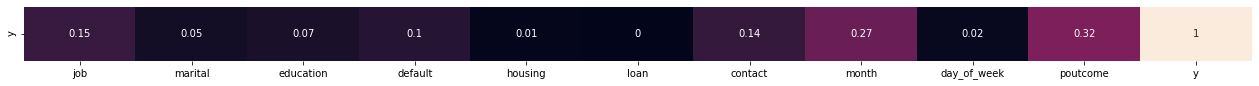

In [13]:
assoc_cramers = []
for i in df_cat.columns:
    assoc = round(cramers_v(df['y'], df_cat[i]), 2)
    assoc_cramers.append(assoc)

data_cramers = pd.DataFrame(data = [assoc_cramers], columns = df_cat.columns, index = ['y'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_cramers, annot=True, cbar=False)
plt.show()

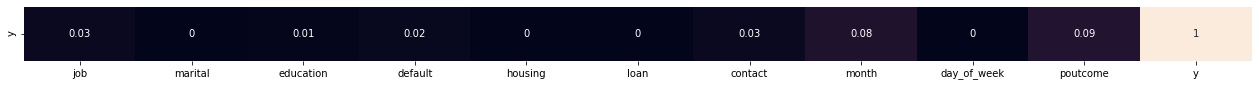

In [14]:
assoc_theils = []
for i in df_cat.columns:
    assoc = round(theils_u(df['y'], df_cat[i]), 2)
    assoc_theils.append(assoc)

data_theils = pd.DataFrame(data = [assoc_theils], columns = df_cat.columns, index = ['y'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_theils, annot=True, cbar=False)
plt.show()

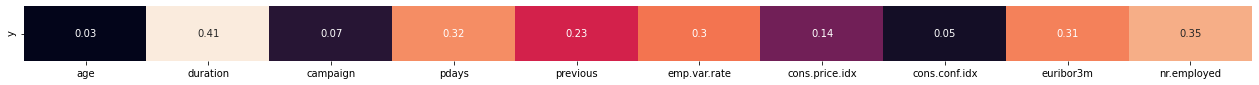

In [15]:
corr_rat = []
for i in df_num.columns:
    a = round(correlation_ratio(df['y'], df_num[i]), 2)
    corr_rat.append(a)

data_corr_rat = pd.DataFrame(data = [corr_rat], columns = df_num.columns, index = ['y'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_corr_rat, annot=True, cbar=False)
plt.show()

In [16]:
df.education = df.education.apply(lambda x : x.replace(".", " "))
df_cat.education = df.education.apply(lambda x : x.replace(".", " "))

In [17]:
df

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic 4y       no      no   no   
1       57     services  married          high school  unknown      no   no   
2       37     services  married          high school       no     yes   no   
3       40       admin.  married             basic 6y       no      no   no   
4       56     services  married          high school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional course       no     yes   no   
41184   46  blue-collar  married  professional course       no      no   no   
41185   56      retired  married    university degree       no     yes   no   
41186   44   technician  married  professional course       no      no   no   
41187   74      retired  married  professional course       no     yes   no   

         contact month day_of_week  duration  campaign  pdays  previous  \
0      telephone   may         mon       261         1    999         0   
1      telephone   may         mon       149         1    999         0   
2      telephone   may         mon       226         1    999         0   
3      telephone   may         mon       151         1    999         0   
4      telephone   may         mon       307         1    999         0   
...          ...   ...         ...       ...       ...    ...       ...   
41183   cellular   nov         fri       334         1    999         0   
41184   cellular   nov         fri       383         1    999         0   
41185   cellular   nov         fri       189         2    999         0   
41186   cellular   nov         fri       442         1    999         0   
41187   cellular   nov         fri       239         3    999         1   

          poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent           1.1          93.994          -36.4      4.857   
1      nonexistent           1.1          93.994          -36.4      4.857   
2      nonexistent           1.1          93.994          -36.4      4.857   
3      nonexistent           1.1          93.994          -36.4      4.857   
4      nonexistent           1.1          93.994          -36.4      4.857   
...            ...           ...             ...            ...        ...   
41183  nonexistent          -1.1          94.767          -50.8      1.028   
41184  nonexistent          -1.1          94.767          -50.8      1.028   
41185  nonexistent          -1.1          94.767          -50.8      1.028   
41186  nonexistent          -1.1          94.767          -50.8      1.028   
41187      failure          -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

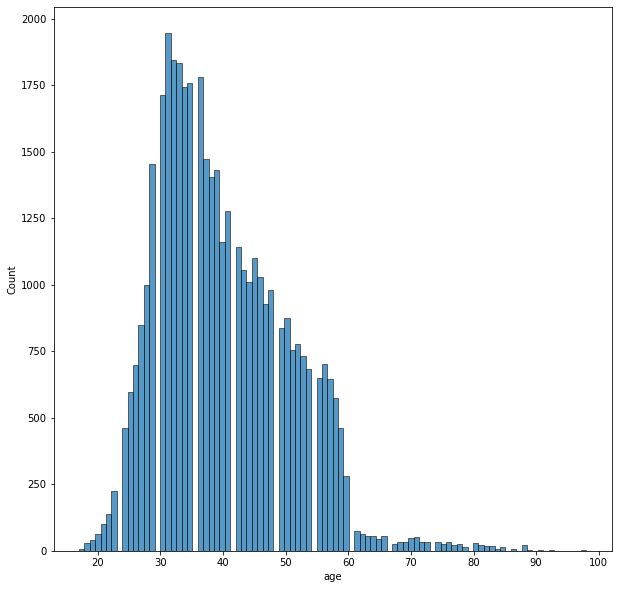

In [18]:
plt.figure(figsize=(10,10))
sns.histplot(x=df['age'])
plt.show()

In [19]:
job = pd.crosstab(index = df["job"], columns = 'Jumlah')
job['Persentase'] = ''
persen = []
for a in job["Jumlah"]:
    persen.append(a/job['Jumlah'].sum()*100)
job['Persentase'] = persen
job

col_0          Jumlah  Persentase
job                              
admin.          10422   25.303486
blue-collar      9254   22.467709
entrepreneur     1456    3.535010
housemaid        1060    2.573565
management       2924    7.099155
retired          1720    4.175974
self-employed    1421    3.450034
services         3969    9.636302
student           875    2.124405
technician       6743   16.371273
unemployed       1014    2.461882
unknown           330    0.801204

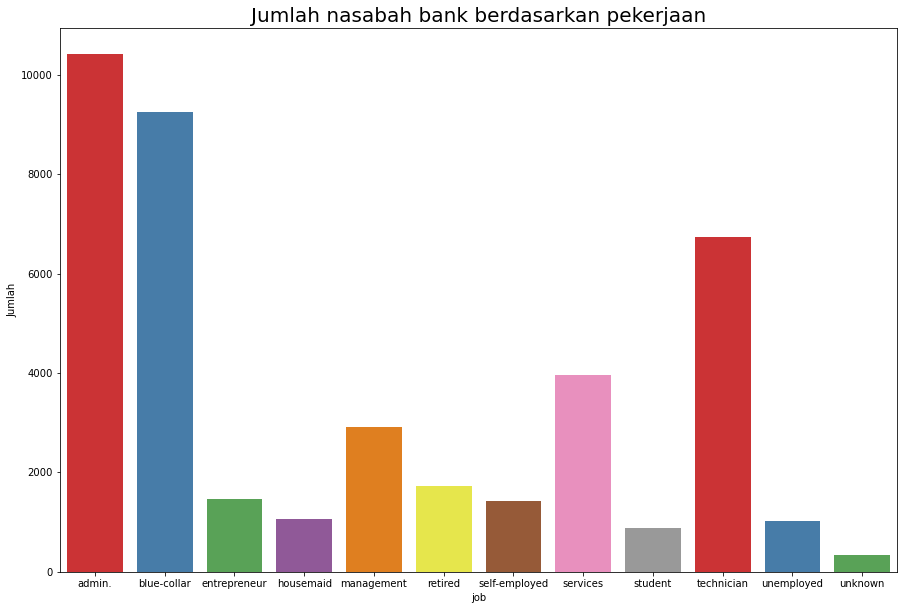

In [20]:
plt.figure(figsize=(15,10))
sns.barplot(data= job.reset_index(), x='job', y='Jumlah', palette='Set1')
plt.title("Jumlah nasabah bank berdasarkan pekerjaan", size=20)
plt.show()

In [21]:
mar = pd.crosstab(index = df["marital"], columns = 'Jumlah')
mar['Persentase'] = ''
persen = []
for a in mar["Jumlah"]:
    persen.append(a/mar['Jumlah'].sum()*100)
mar['Persentase'] = persen
mar

col_0     Jumlah  Persentase
marital                     
divorced    4612   11.197436
married    24928   60.522482
single     11568   28.085850
unknown       80    0.194231

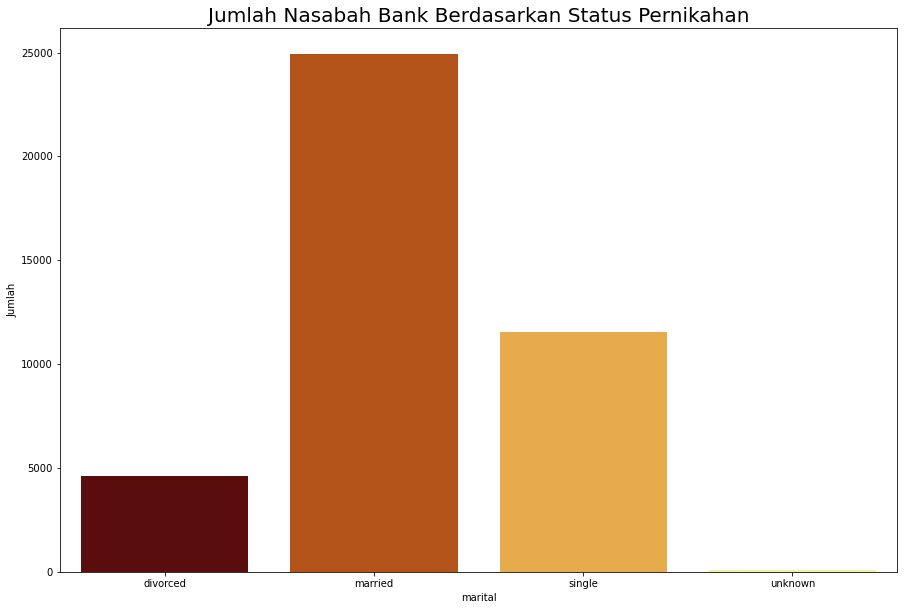

In [22]:
plt.figure(figsize=(15,10))
sns.barplot(data= mar.reset_index(), x='marital', y='Jumlah', palette='afmhot')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Pernikahan", size=20)
plt.show()

In [23]:
edu = pd.crosstab(index = df["education"], columns = 'Jumlah')
edu['Persentase'] = ''
persen = []
for a in edu["Jumlah"]:
    persen.append(a/edu['Jumlah'].sum()*100)
edu['Persentase'] = persen
edu

col_0                Jumlah  Persentase
education                              
basic 4y               4176   10.138875
basic 6y               2292    5.564728
basic 9y               6045   14.676605
high school            9515   23.101389
illiterate               18    0.043702
professional course    5243   12.729436
university degree     12168   29.542585
unknown                1731    4.202680

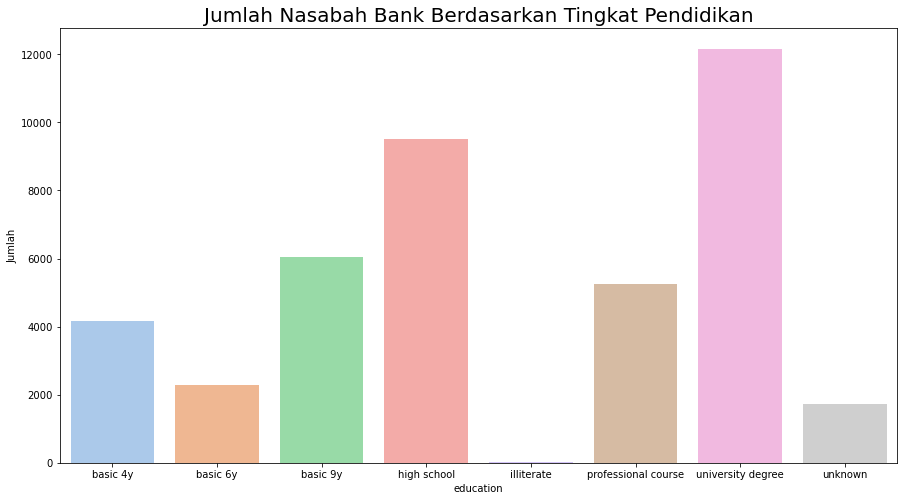

In [24]:
plt.figure(figsize=(15,8))
sns.barplot(data = edu.reset_index(), x='education', y='Jumlah', palette='pastel')
plt.title("Jumlah Nasabah Bank Berdasarkan Tingkat Pendidikan", size=20)
plt.show()

In [25]:
de = pd.crosstab(index = df["default"], columns = 'Jumlah')
de['Persentase'] = ''
persen = []
for a in de["Jumlah"]:
    persen.append(a/de['Jumlah'].sum()*100)
de['Persentase'] = persen
de

col_0    Jumlah  Persentase
default                    
no        32588   79.120132
unknown    8597   20.872584
yes           3    0.007284

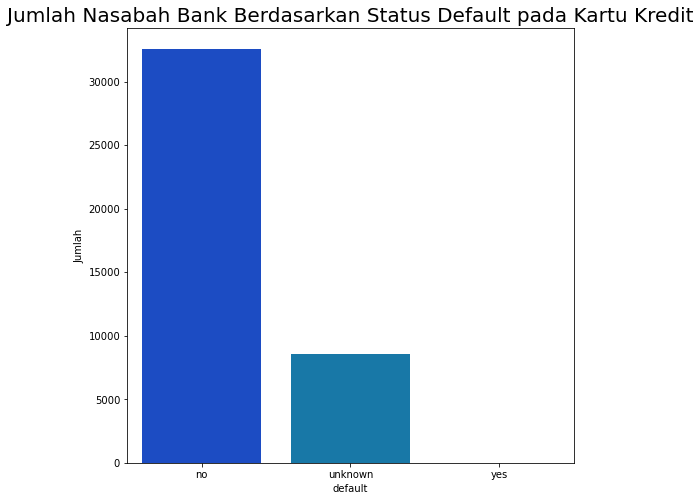

In [26]:
plt.figure(figsize=(8,8))
sns.barplot(data = de.reset_index(), x='default', y='Jumlah', palette='winter')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Default pada Kartu Kredit", size=20)
plt.show()

In [27]:
house = pd.crosstab(index = df["housing"], columns = 'Jumlah')
house['Persentase'] = ''
persen = []
for a in house["Jumlah"]:
    persen.append(a/house['Jumlah'].sum()*100)
house['Persentase'] = persen
house

col_0    Jumlah  Persentase
housing                    
no        18622   45.212198
unknown     990    2.403613
yes       21576   52.384190

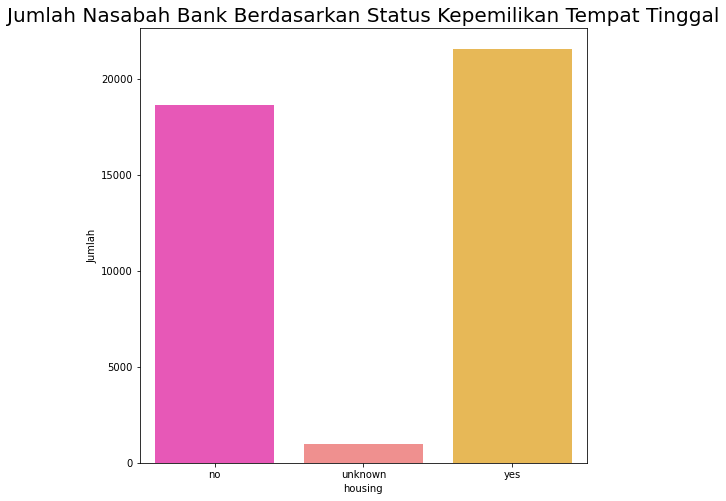

In [28]:
plt.figure(figsize=(8,8))
sns.barplot(data = house.reset_index(), x='housing', y='Jumlah', palette='spring')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Kepemilikan Tempat Tinggal", size=20)
plt.show()

In [29]:
loan = pd.crosstab(index = df["loan"], columns = 'Jumlah')
loan['Persentase'] = ''
persen = []
for a in loan["Jumlah"]:
    persen.append(a/loan['Jumlah'].sum()*100)
loan['Persentase'] = persen
loan

col_0    Jumlah  Persentase
loan                       
no        33950   82.426920
unknown     990    2.403613
yes        6248   15.169467

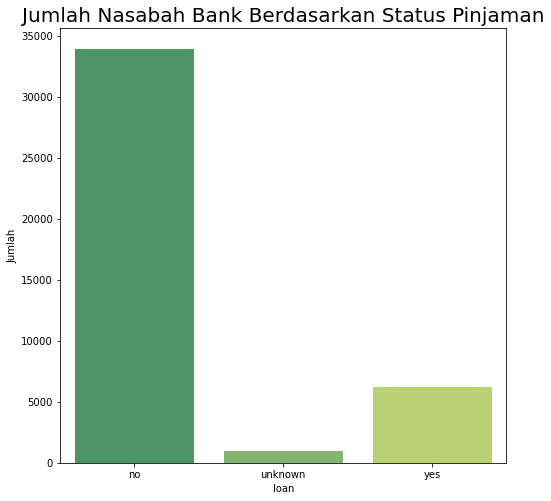

In [30]:
plt.figure(figsize=(8,8))
sns.barplot(data = loan.reset_index(), x='loan', y='Jumlah', palette='summer')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Pinjaman", size=20)
plt.show()

In [31]:
con = pd.crosstab(index = df["contact"], columns = 'Jumlah')
con['Persentase'] = ''
persen = []
for a in con["Jumlah"]:
    persen.append(a/con['Jumlah'].sum()*100)
con['Persentase'] = persen
con

col_0      Jumlah  Persentase
contact                      
cellular    26144   63.474798
telephone   15044   36.525202

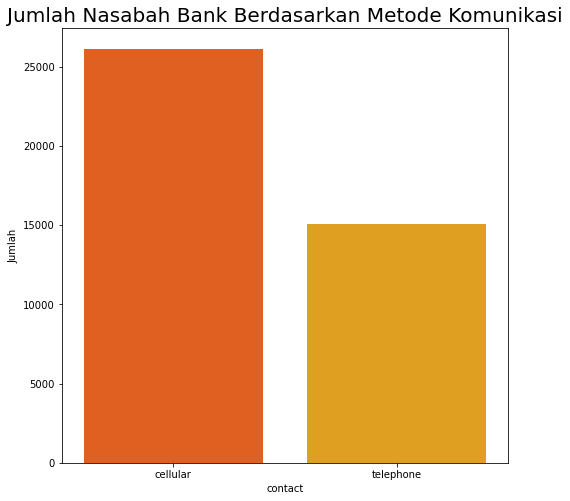

In [32]:
plt.figure(figsize=(8,8))
sns.barplot(data = con.reset_index(), x='contact', y='Jumlah', palette='autumn')
plt.title("Jumlah Nasabah Bank Berdasarkan Metode Komunikasi", size=20)
plt.show()

In [33]:
df['month'] = pd.Categorical(df['month'], ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
mon = pd.crosstab(index = df["month"], columns = 'Jumlah')
mon['Persentase'] = ''
persen = []
for a in mon["Jumlah"]:
    persen.append(a/mon['Jumlah'].sum()*100)
mon['Persentase'] = persen
mon

col_0  Jumlah  Persentase
month                    
mar       546    1.325629
apr      2632    6.390211
may     13769   33.429640
jun      5318   12.911528
jul      7174   17.417694
aug      6178   14.999514
sep       570    1.383898
oct       718    1.743226
nov      4101    9.956784
dec       182    0.441876

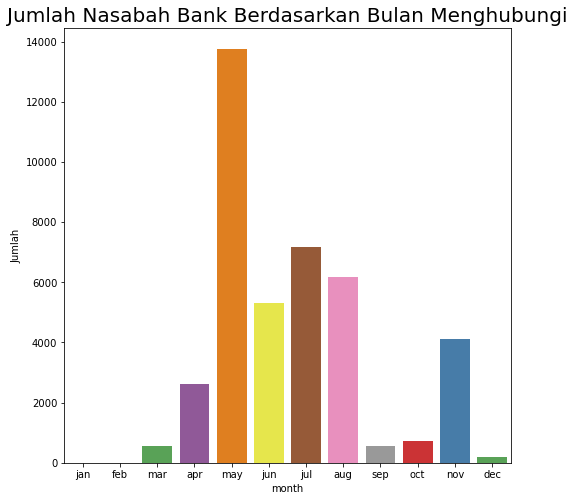

In [34]:
plt.figure(figsize=(8,8))
sns.barplot(data = mon.reset_index(), x='month', y='Jumlah', palette='Set1')
plt.title("Jumlah Nasabah Bank Berdasarkan Bulan Menghubungi", size=20)
plt.show()

In [35]:
df['day_of_week'] = pd.Categorical(df['day_of_week'], ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])
day = pd.crosstab(index = df["day_of_week"], columns = 'Jumlah')
day['Persentase'] = ''
persen = []
for a in day["Jumlah"]:
    persen.append(a/day['Jumlah'].sum()*100)
day['Persentase'] = persen
day

col_0        Jumlah  Persentase
day_of_week                    
mon            8514   20.671069
tue            8090   19.641643
wed            8134   19.748470
thu            8623   20.935709
fri            7827   19.003108

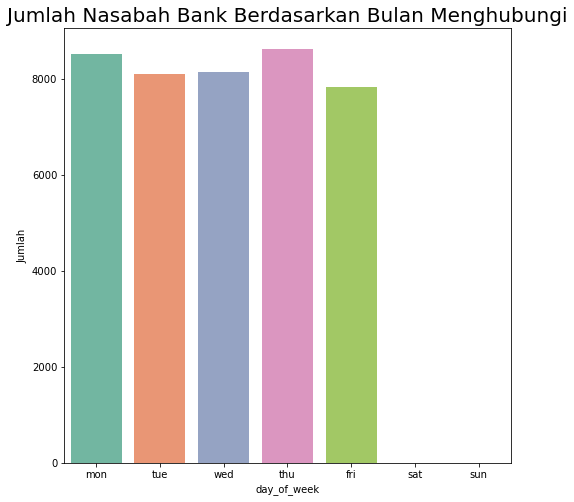

In [36]:
plt.figure(figsize=(8,8))
sns.barplot(data = day.reset_index(), x='day_of_week', y='Jumlah', palette='Set2')
plt.title("Jumlah Nasabah Bank Berdasarkan Bulan Menghubungi", size=20)
plt.show()

In [37]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

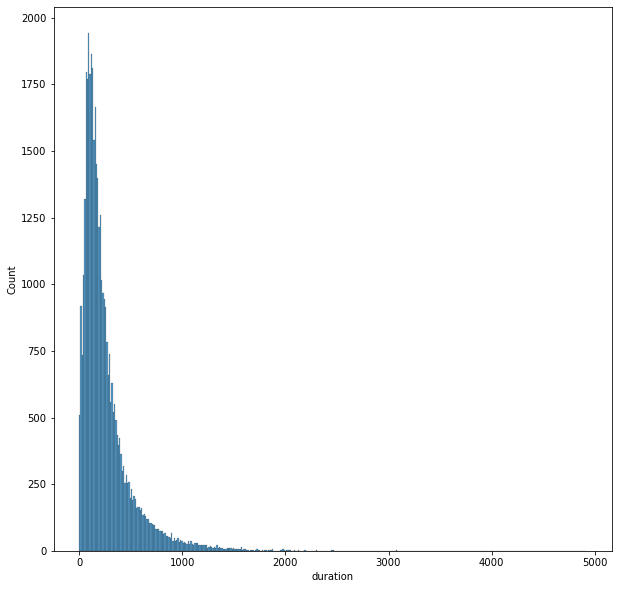

In [38]:
plt.figure(figsize=(10,10))
sns.histplot(x=df['duration'])
plt.show()

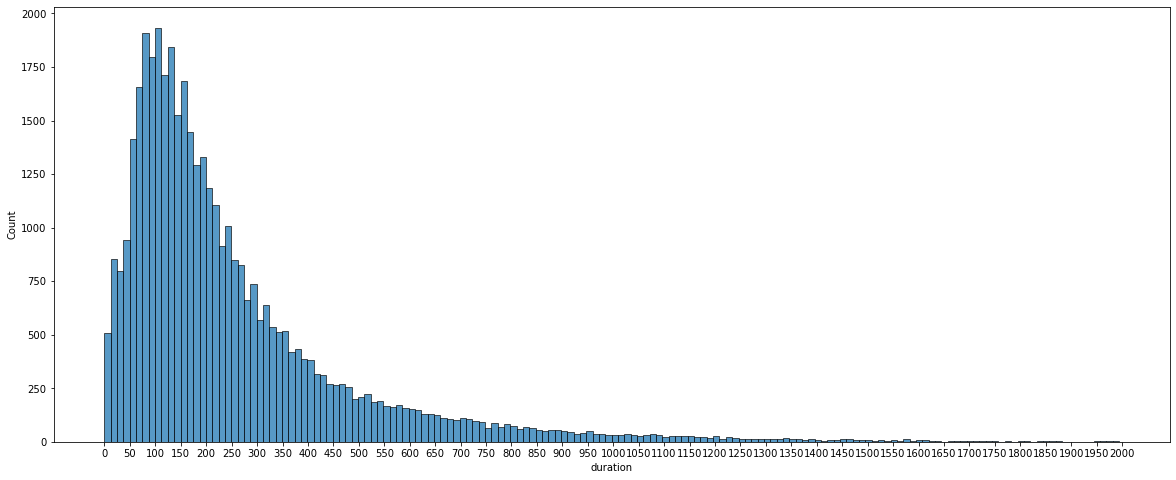

In [39]:
plt.figure(figsize=(20,8))
sns.histplot(x=df[df['duration'] <= 2000]['duration'])
plt.xticks(np.arange(0,2001,50))
plt.show()

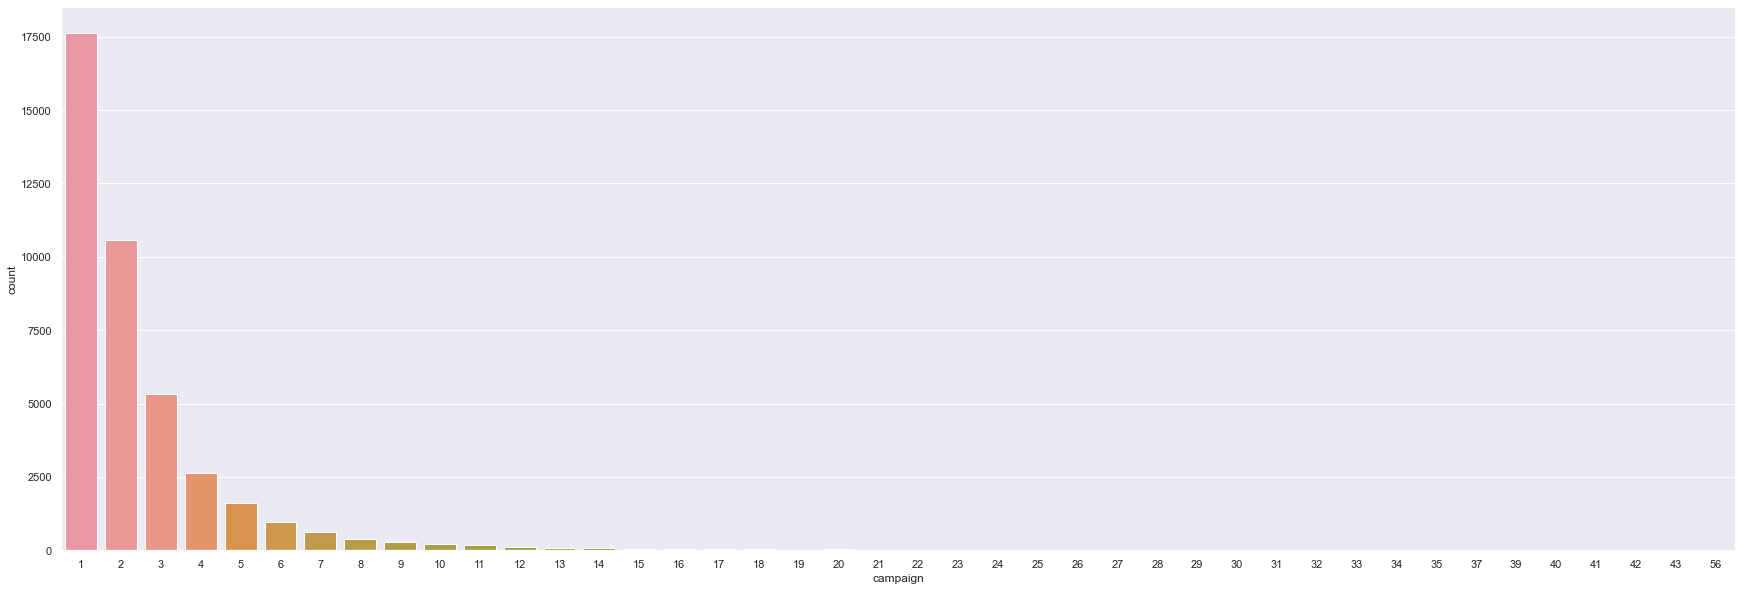

In [40]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(data=df, x='campaign')

plt.show()

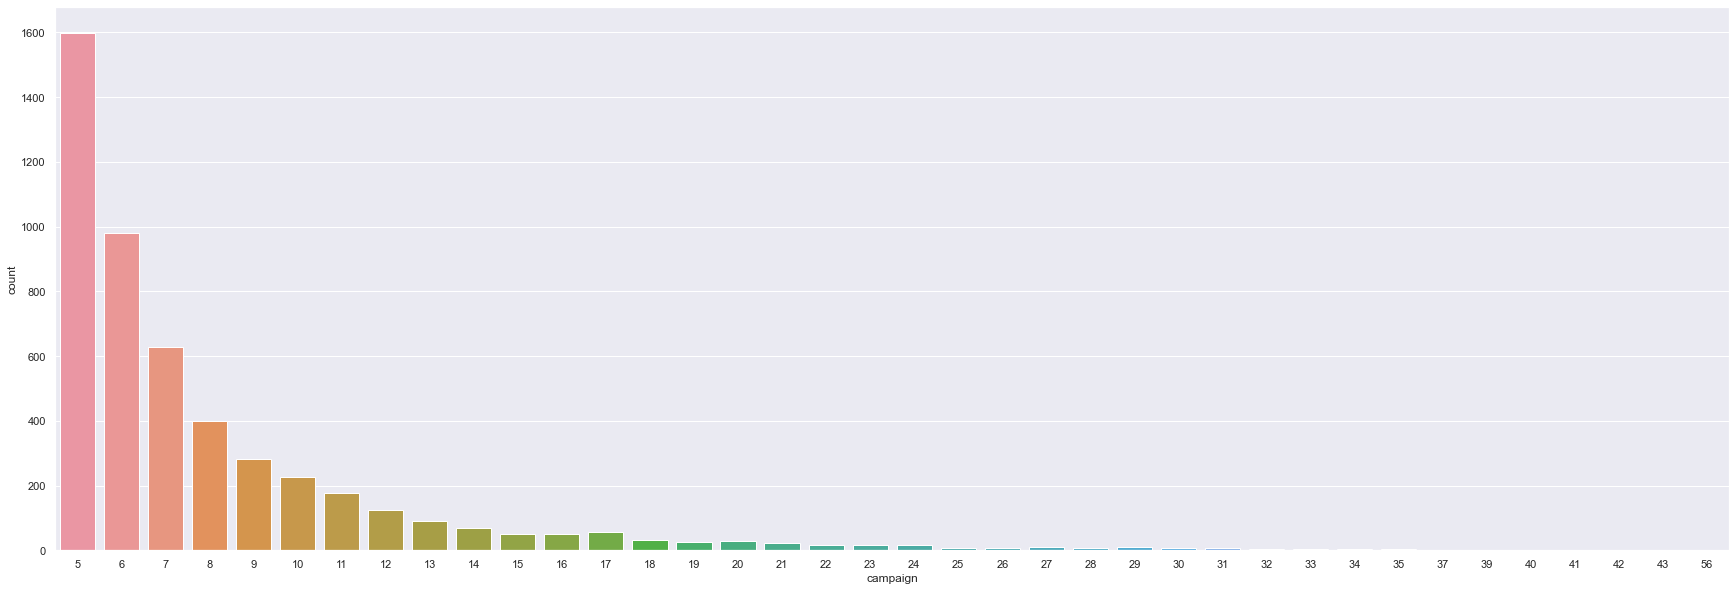

In [41]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=df[df['campaign']>4]['campaign'])

plt.show()

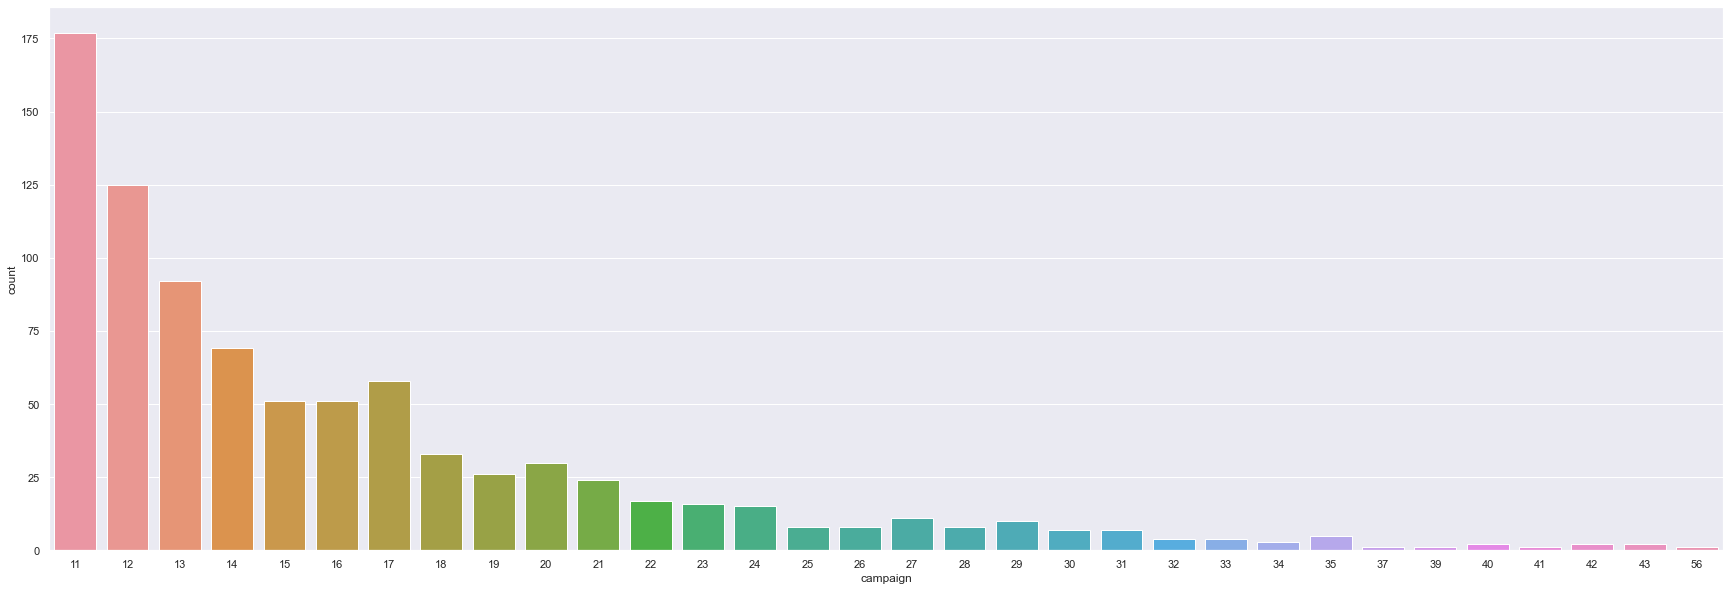

In [42]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=df[df['campaign']>10]['campaign'])

plt.show()

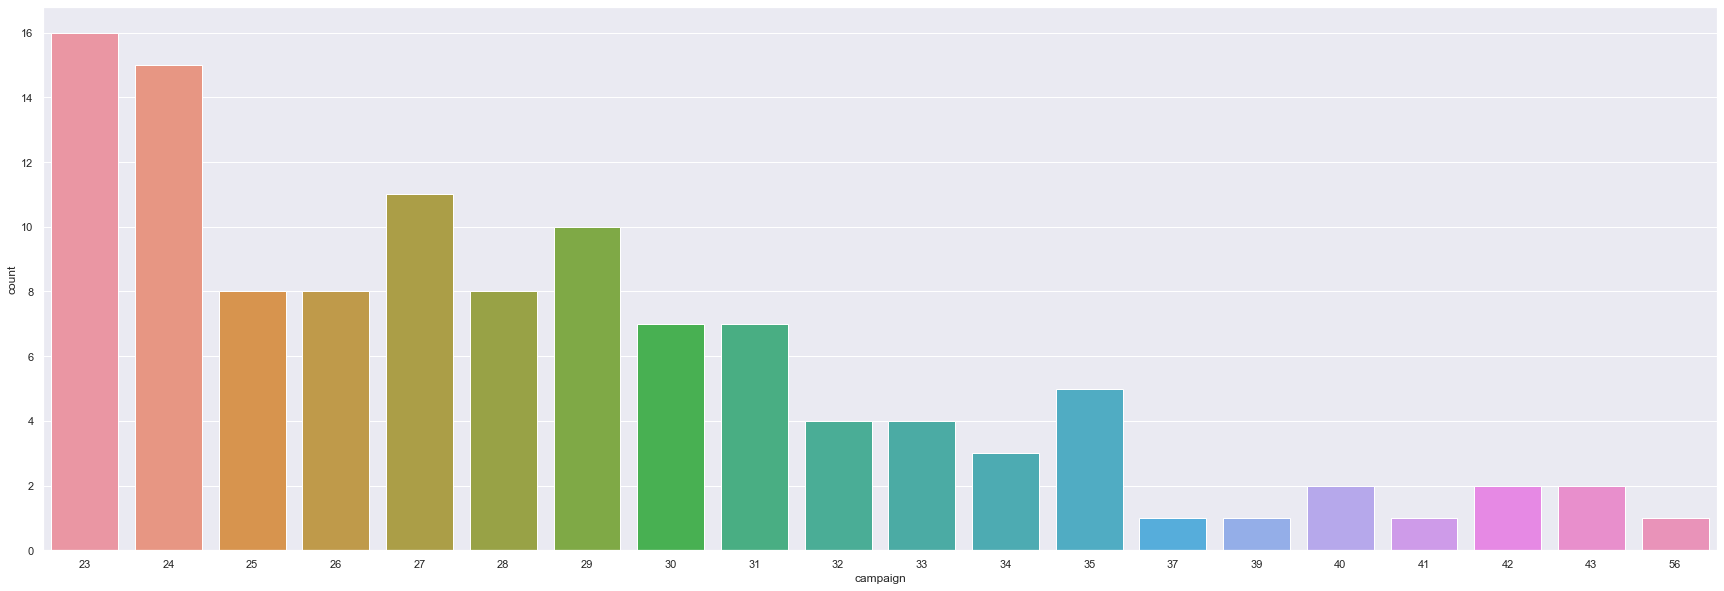

In [43]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=df[df['campaign']>22]['campaign'])

plt.show()

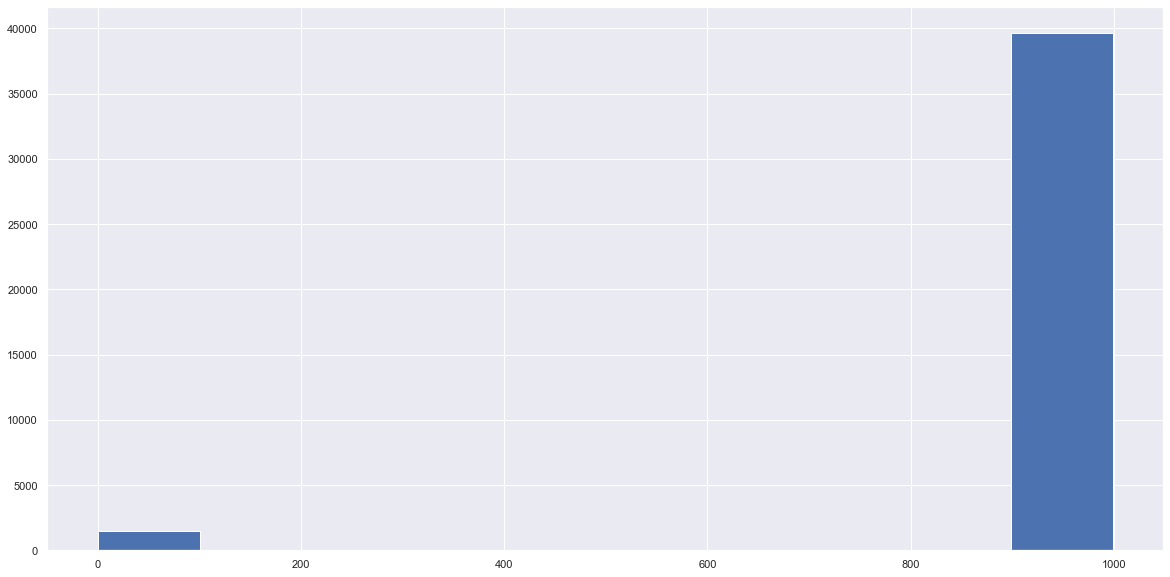

In [44]:
plt.figure(figsize=(20,10))
plt.hist(x=df['pdays'])
# sns.set(rc={'figure.figsize':(20,10)})
# sns.countplot(x=df[df['campaign']>22]['campaign'])

plt.show()

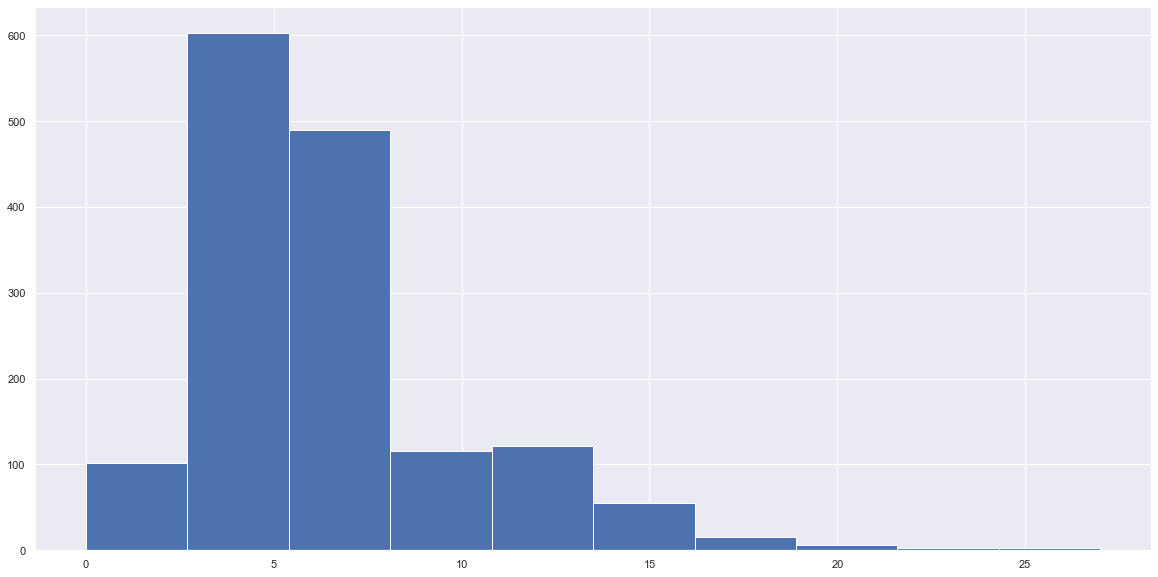

In [45]:
plt.figure(figsize=(20,10))
plt.hist(x=df[df['pdays']!=999]['pdays'])
# sns.set(rc={'figure.figsize':(20,10)})
# sns.countplot(x=df[df['campaign']>22]['campaign'])

plt.show()

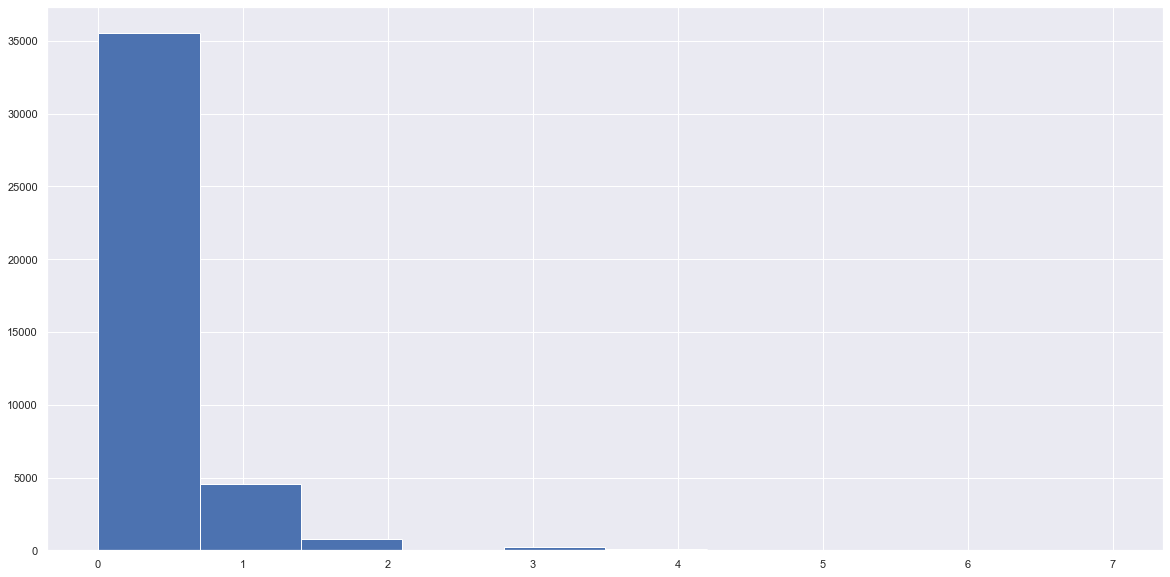

In [46]:
plt.figure(figsize=(20,10))
plt.hist(x=df['previous'])

plt.show()

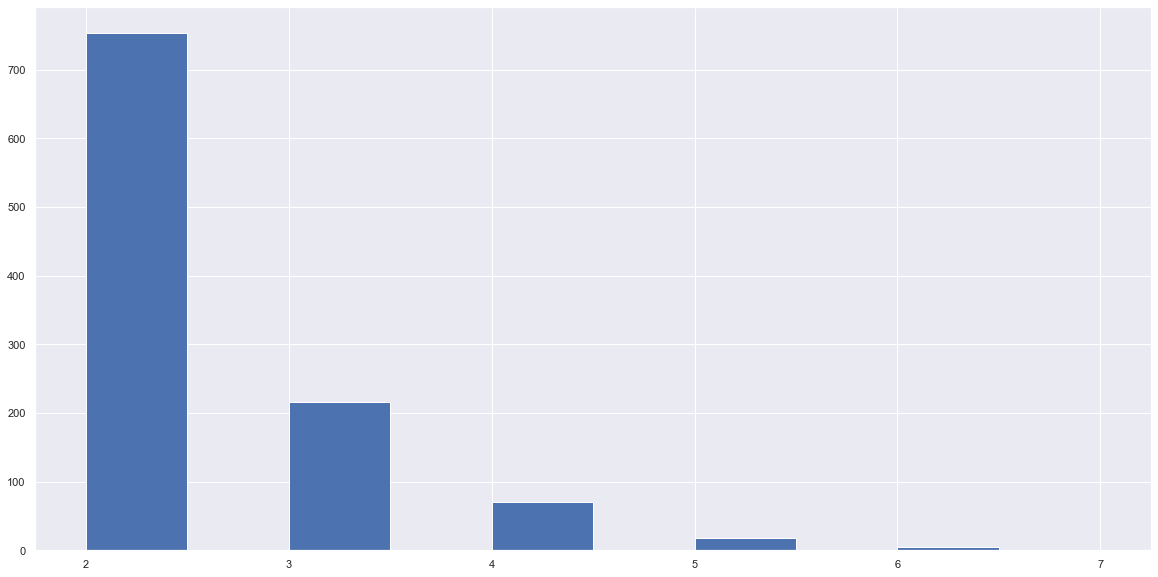

In [47]:
plt.figure(figsize=(20,10))
plt.hist(x=df[df['previous']>1]['previous'])

plt.show()

In [48]:
pout = pd.crosstab(index = df["poutcome"], columns = 'Jumlah')
pout['Persentase'] = ''
persen = []
for a in pout["Jumlah"]:
    persen.append(a/pout['Jumlah'].sum()*100)
pout['Persentase'] = persen
pout

col_0        Jumlah  Persentase
poutcome                       
failure        4252   10.323395
nonexistent   35563   86.343110
success        1373    3.333495

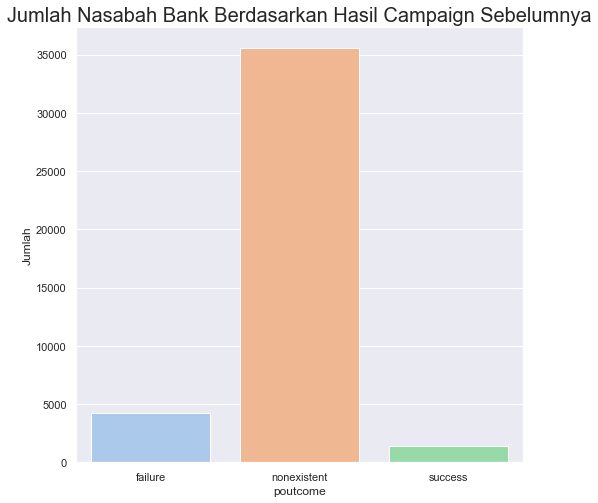

In [49]:
plt.figure(figsize=(8,8))
sns.barplot(data = pout.reset_index(), x='poutcome', y='Jumlah', palette='pastel')
plt.title("Jumlah Nasabah Bank Berdasarkan Hasil Campaign Sebelumnya", size=20)
plt.show()

In [50]:
df['emp.var.rate'].unique()

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])

In [51]:
emp = pd.crosstab(index = df["emp.var.rate"], columns = 'Jumlah')
emp['Persentase'] = ''
persen = []
for a in emp["Jumlah"]:
    persen.append(a/emp['Jumlah'].sum()*100)
emp['Persentase'] = persen
emp

col_0         Jumlah  Persentase
emp.var.rate                    
-3.4            1071    2.600272
-3.0             172    0.417597
-2.9            1663    4.037584
-1.8            9184   22.297757
-1.7             773    1.876760
-1.1             635    1.541711
-0.2              10    0.024279
-0.1            3683    8.941925
 1.1            7763   18.847723
 1.4           16234   39.414393

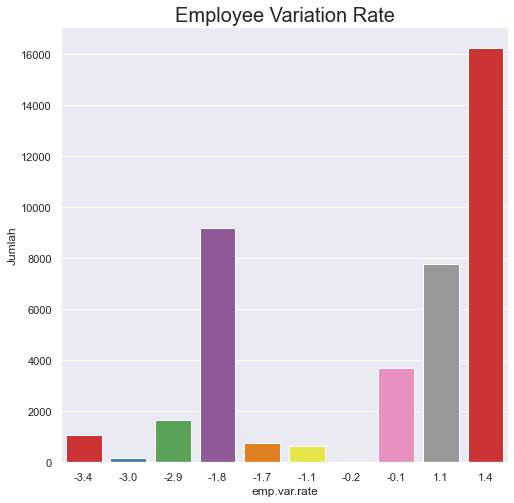

In [52]:
plt.figure(figsize=(8,8))
sns.barplot(data = emp.reset_index(), x='emp.var.rate', y='Jumlah', palette='Set1')
plt.title("Employee Variation Rate", size=20)
plt.show()

In [53]:
cons = pd.crosstab(index = df["cons.price.idx"], columns = 'Jumlah')
cons['Persentase'] = ''
persen = []
for a in cons["Jumlah"]:
    persen.append(a/cons['Jumlah'].sum()*100)
cons['Persentase'] = persen
cons

col_0           Jumlah  Persentase
cons.price.idx                    
92.201             770    1.869477
92.379             267    0.648247
92.431             447    1.085268
92.469             178    0.432165
92.649             357    0.866757
92.713             172    0.417597
92.756              10    0.024279
92.843             282    0.684665
92.893            5794   14.067204
92.963             715    1.735943
93.075            2458    5.967758
93.200            3616    8.779256
93.369             264    0.640963
93.444            5175   12.564339
93.749             174    0.422453
93.798              67    0.162669
93.876             212    0.514713
93.918            6685   16.230455
93.994            7763   18.847723
94.027             233    0.565699
94.055             229    0.555987
94.199             303    0.735651
94.215             311    0.755074
94.465            4374   10.619598
94.601             204    0.495290
94.767             128    0.310770

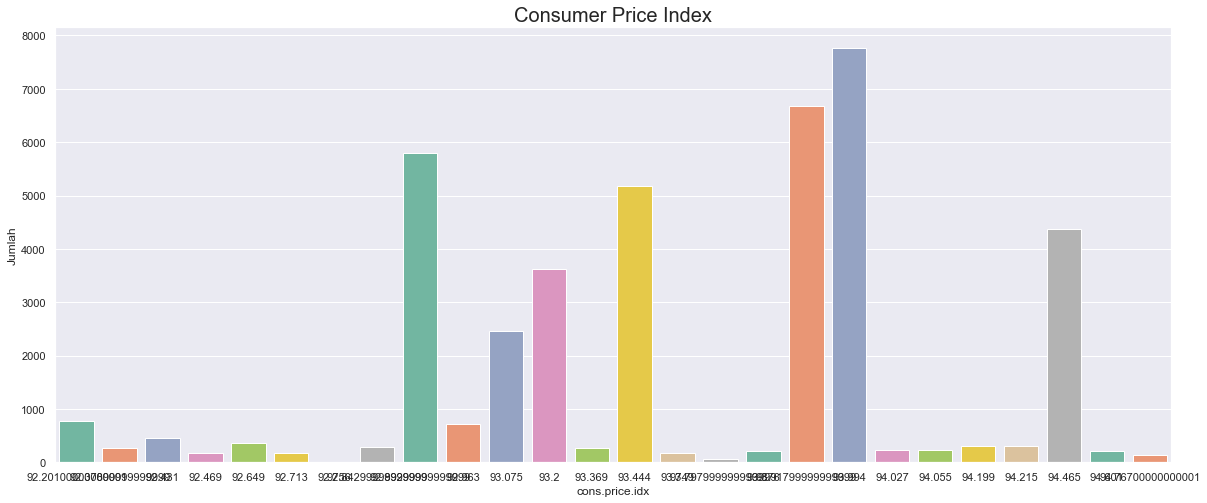

In [54]:
plt.figure(figsize=(20,8))
sns.barplot(data = cons.reset_index(), x='cons.price.idx', y='Jumlah', palette='Set2')
plt.title("Consumer Price Index", size=20)
plt.show()

In [55]:
conf = pd.crosstab(index = df["cons.conf.idx"], columns = 'Jumlah')
conf['Persentase'] = ''
persen = []
for a in conf["Jumlah"]:
    persen.append(a/conf['Jumlah'].sum()*100)
conf['Persentase'] = persen
conf

col_0          Jumlah  Persentase
cons.conf.idx                    
-50.8             128    0.310770
-50.0             282    0.684665
-49.5             204    0.495290
-47.1            2458    5.967758
-46.2            5794   14.067204
-45.9              10    0.024279
-42.7            6685   16.230455
-42.0            3616    8.779256
-41.8            4374   10.619598
-40.8             715    1.735943
-40.4              67    0.162669
-40.3             311    0.755074
-40.0             212    0.514713
-39.8             229    0.555987
-38.3             233    0.565699
-37.5             303    0.735651
-36.4            7763   18.847723
-36.1            5175   12.564339
-34.8             264    0.640963
-34.6             174    0.422453
-33.6             178    0.432165
-33.0             172    0.417597
-31.4             770    1.869477
-30.1             357    0.866757
-29.8             267    0.648247
-26.9             447    1.085268

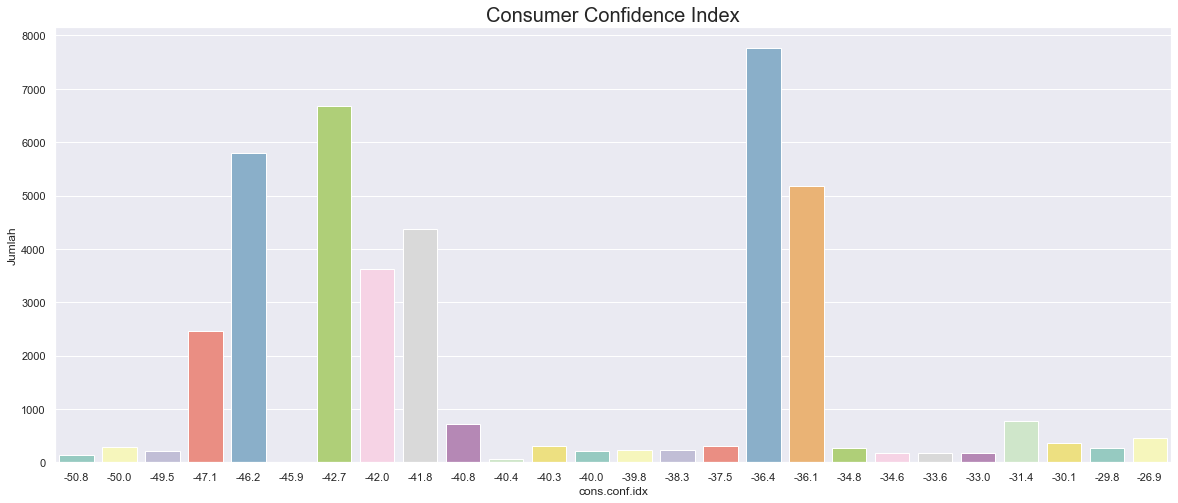

In [56]:
plt.figure(figsize=(20,8))
sns.barplot(data = conf.reset_index(), x='cons.conf.idx', y='Jumlah', palette='Set3')
plt.title("Consumer Confidence Index", size=20)
plt.show()

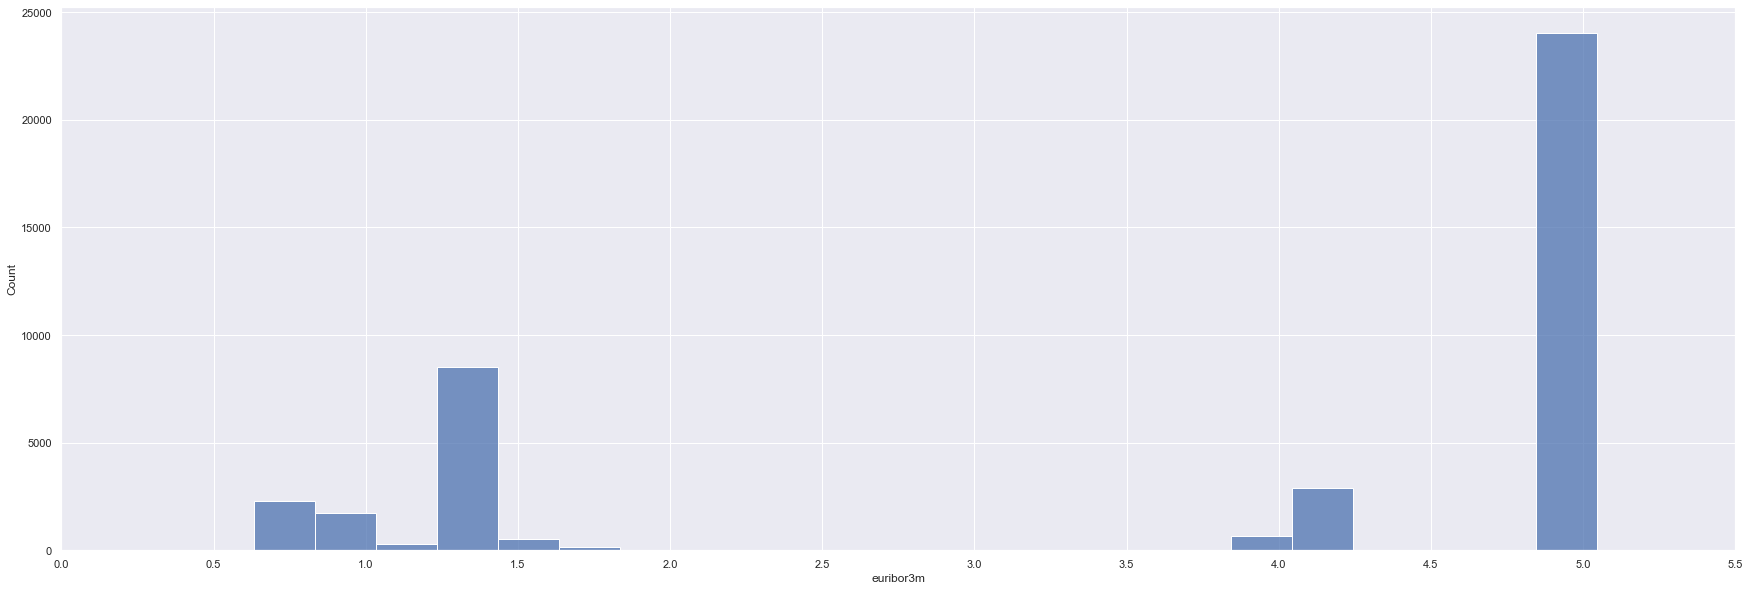

In [57]:
plt.figure(figsize=(30,10))
# sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(data=df, x='euribor3m')
plt.xticks(np.arange(0,6,0.5))
plt.show()

In [58]:
nr = pd.crosstab(index = df["nr.employed"], columns = 'Jumlah')
nr['Persentase'] = ''
persen = []
for a in nr["Jumlah"]:
    persen.append(a/nr['Jumlah'].sum()*100)
nr['Persentase'] = persen
nr

col_0        Jumlah  Persentase
nr.employed                    
4963.6          635    1.541711
4991.6          773    1.876760
5008.7          650    1.578130
5017.5         1071    2.600272
5023.5          172    0.417597
5076.2         1663    4.037584
5099.1         8534   20.719627
5176.3           10    0.024279
5191.0         7763   18.847723
5195.8         3683    8.941925
5228.1        16234   39.414393

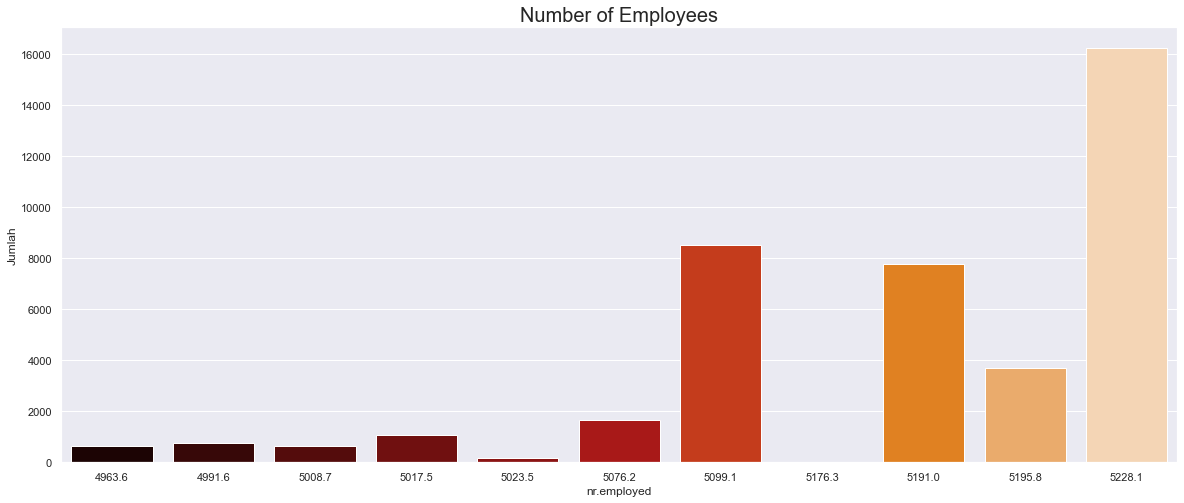

In [59]:
plt.figure(figsize=(20,8))
sns.barplot(data = nr.reset_index(), x='nr.employed', y='Jumlah', palette='gist_heat')
plt.title("Number of Employees", size=20)
plt.show()

In [60]:
res = pd.crosstab(index = df["y"], columns = 'Jumlah')
res['Persentase'] = ''
persen = []
for a in res["Jumlah"]:
    persen.append(a/res['Jumlah'].sum()*100)
res['Persentase'] = persen
res

col_0  Jumlah  Persentase
y                        
no      36548   88.734583
yes      4640   11.265417

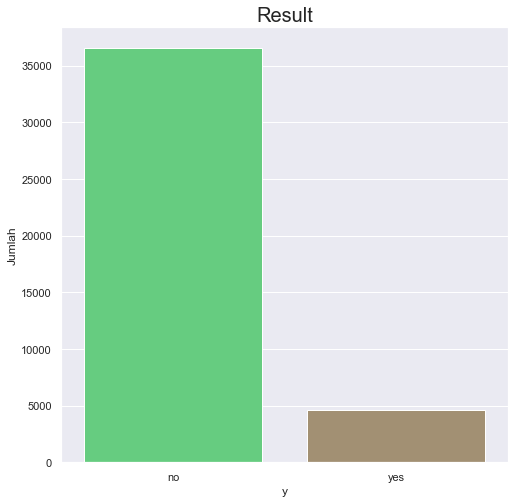

In [61]:
plt.figure(figsize=(8,8))
sns.barplot(data = res.reset_index(), x='y', y='Jumlah', palette='terrain')
plt.title("Result", size=20)
plt.show()

# Analisis Multivariate

### Analisis Multivariate terhadap Pembukaan Deposito

In [62]:
age_bin = [0, 10, 20, 40, df['age'].max()] ## Membuat Kelompok Usia
labels = ['Kids', 'Teenager', 'Adult', 'Elder'] ## Label untuk Kelompok Usia
df['age_bin'] = pd.cut(df['age'], bins=age_bin, labels=labels)

In [63]:
# Analisis Multivariate antara age dan y
(pd.crosstab(index = df['age_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y            no   yes
age_bin              
Teenager   0.20  0.14
Adult     50.90  6.47
Elder     37.63  4.66

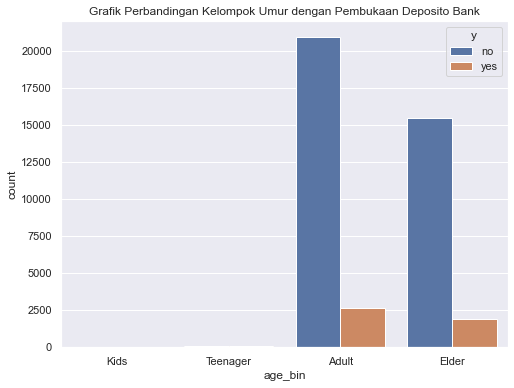

In [64]:
# Visualisasi data Analisis Multivariate antara age dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'age_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kelompok Umur dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok usia dewasa mendominasi pembukaan deposito di bank

In [65]:
# Analisis Multivariate antara job dan y
(pd.crosstab(index = df['job'], columns = df['y'], normalize = 'all')*100).round(2)

y                 no   yes
job                       
admin.         22.02  3.28
blue-collar    20.92  1.55
entrepreneur    3.23  0.30
housemaid       2.32  0.26
management      6.30  0.80
retired         3.12  1.05
self-employed   3.09  0.36
services        8.85  0.78
student         1.46  0.67
technician     14.60  1.77
unemployed      2.11  0.35
unknown         0.71  0.09

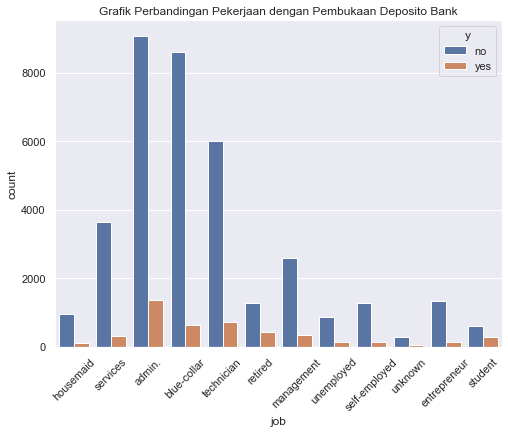

In [66]:
# Visualisasi data Analisis Multivariate antara job dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'job', data = df , hue = 'y')
plt.title('Grafik Perbandingan Pekerjaan dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Kelompok pekerja admin mendominasi pembuka deposito bank

In [67]:
# Analisis Multivariate antara marital dan y
(pd.crosstab(index = df['marital'], columns = df['y'], normalize = 'all')*100).round(2)

y            no   yes
marital              
divorced  10.04  1.16
married   54.38  6.15
single    24.15  3.93
unknown    0.17  0.03

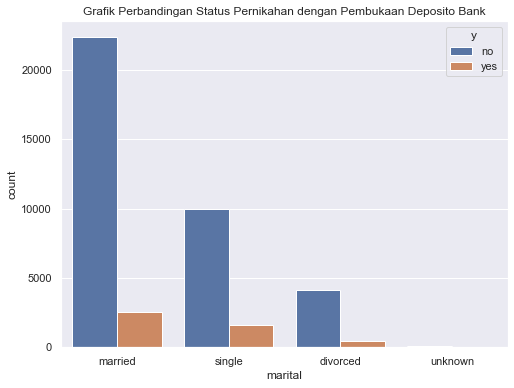

In [68]:
# Visualisasi data Analisis Multivariate antara marital dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'marital', data = df , hue = 'y')
plt.title('Grafik Perbandingan Status Pernikahan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan status pernikahan "sudah menikah" mendominasi pembukaan deposito

In [69]:
# Analisis Multivariate antara education dan y
(pd.crosstab(index = df['education'], columns = df['y'], normalize = 'all')*100).round(2)

y                       no   yes
education                       
basic 4y              9.10  1.04
basic 6y              5.11  0.46
basic 9y             13.53  1.15
high school          20.60  2.50
illiterate            0.03  0.01
professional course  11.28  1.44
university degree    25.49  4.05
unknown               3.59  0.61

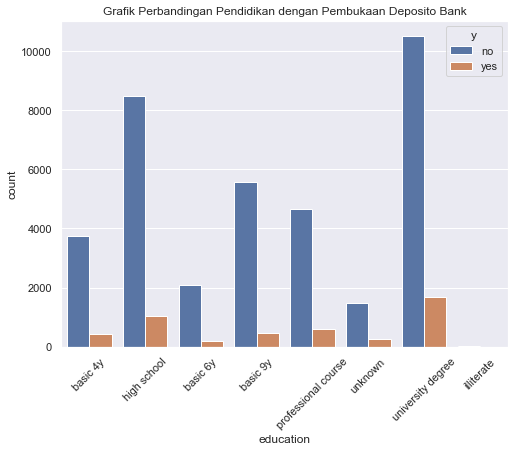

In [70]:
# Visualisasi data Analisis Multivariate antara education dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'education', data = df , hue = 'y')
plt.title('Grafik Perbandingan Pendidikan dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan pendidikan terakhir sarjana mendominasi pembukaan deposito di bank

In [71]:
# Analisis Multivariate antara default dan y
(pd.crosstab(index = df['default'], columns = df['y'], normalize = 'all')*100).round(2)

y           no    yes
default              
no       68.93  10.19
unknown  19.80   1.08
yes       0.01   0.00

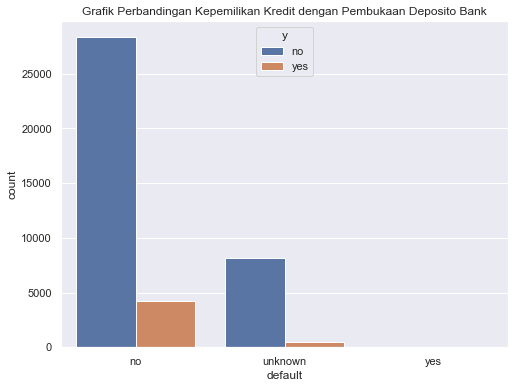

In [72]:
# Visualisasi data Analisis Multivariate antara default dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'default', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kepemilikan Kredit dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah yang tidak memiliki kredit atau pinjaman bank mendominasi pembukaan deposito di bank

In [73]:
# Analisis Multivariate antara housing dan y
(pd.crosstab(index = df['housing'], columns = df['y'], normalize = 'all')*100).round(2)

y           no   yes
housing             
no       40.29  4.92
unknown   2.14  0.26
yes      46.30  6.09

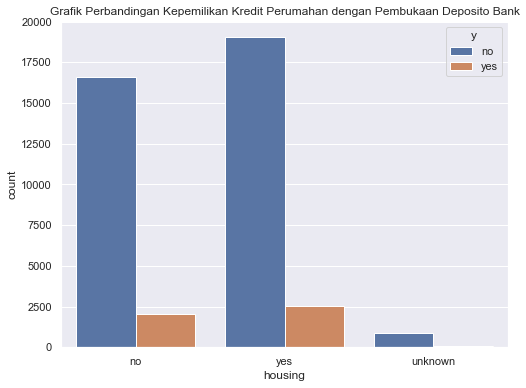

In [74]:
# Visualisasi data Analisis Multivariate antara housing dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'housing', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kepemilikan Kredit Perumahan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan kepemilikan peminjaman perumahan mendominasi pembukaan deposito

In [75]:
# Analisis Multivariate antara loan dan y
(pd.crosstab(index = df['loan'], columns = df['y'], normalize = 'all')*100).round(2)

y           no   yes
loan                
no       73.08  9.35
unknown   2.14  0.26
yes      13.51  1.66

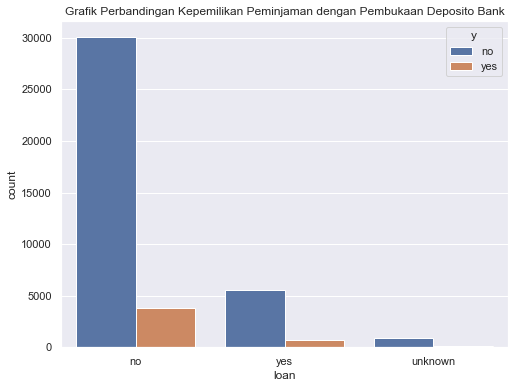

In [76]:
# Visualisasi data Analisis Multivariate antara loan dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kepemilikan Peminjaman dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah yang tidak memiliki peminjaman di bank mendominasi pembukaan deposito

In [77]:
# Analisis Multivariate antara contact dan y
(pd.crosstab(index = df['contact'], columns = df['y'], normalize = 'all')*100).round(2)

y             no   yes
contact               
cellular   54.12  9.35
telephone  34.61  1.91

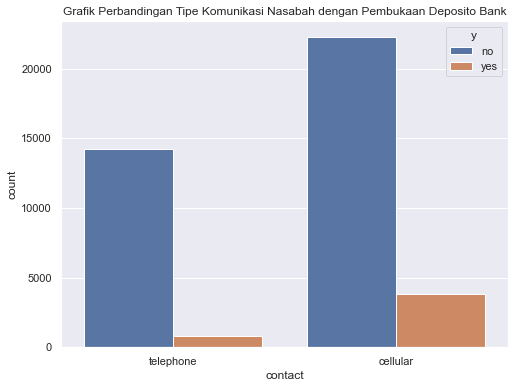

In [78]:
# Visualisasi data Analisis Multivariate antara contact dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'y')
plt.title('Grafik Perbandingan Tipe Komunikasi Nasabah dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan jalur komunikasi melalui selular (telepon genggam) mendominasi nasabah yang melakukan pembukaan deposito

In [79]:
# Analisis Multivariate antara month dan y
(pd.crosstab(index = df['month'], columns = df['y'], normalize = 'all')*100).round(2)

y         no   yes
month             
mar     0.66  0.67
apr     5.08  1.31
may    31.28  2.15
jun    11.55  1.36
jul    15.84  1.58
aug    13.41  1.59
sep     0.76  0.62
oct     0.98  0.76
nov     8.95  1.01
dec     0.23  0.22

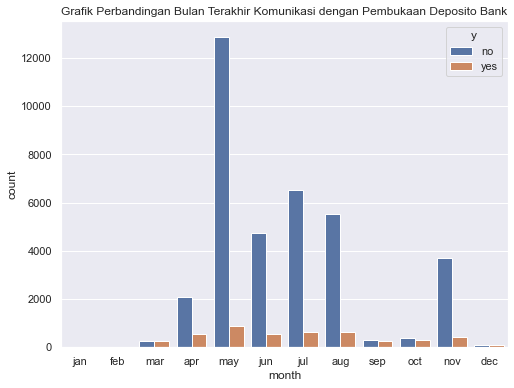

In [80]:
# Visualisasi data Analisis Multivariate antara month dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'y')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Bulan terakhir komunikasi nasabah dengan tim kampanye didominasi di bulan Mei

In [81]:
# Analisis Multivariate antara day_of_week dan y
(pd.crosstab(index = df['day_of_week'], columns = df['y'], normalize = 'all')*100).round(2)

y               no   yes
day_of_week             
mon          18.61  2.06
tue          17.33  2.31
wed          17.44  2.30
thu          18.40  2.54
fri          16.95  2.05

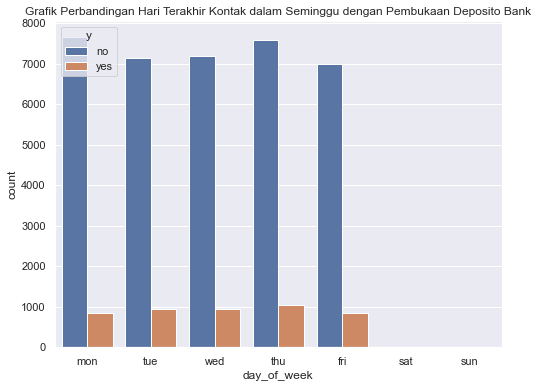

In [82]:
# Visualisasi data Analisis Multivariate antara day_of_week dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'y')
plt.title('Grafik Perbandingan Hari Terakhir Kontak dalam Seminggu dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Hari terakhir komunikasi tim kampanye deposito dalam seminggu dengan nasabah didominasi oleh hari Kamis

In [83]:
# Pengelompokan kategori durasi menelepon
dur_bin = [-1, 600, 1800, 3600, df['duration'].max()] ## Membuat Kelompok Durasi
labels_duration = ['0 - 10 min', '10 - 30 min', '30 - 60 min', 'more than 1 hour'] ## Label untuk Kelompok Durasi
df['dur_bin'] = pd.cut(df['duration'], bins=dur_bin, labels=labels_duration)

In [84]:
# Analisis Multivariate antara duration dan y
(pd.crosstab(index = df['dur_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y                    no   yes
dur_bin                      
0 - 10 min        84.41  7.18
10 - 30 min        4.22  3.94
30 - 60 min        0.09  0.14
more than 1 hour   0.00  0.01

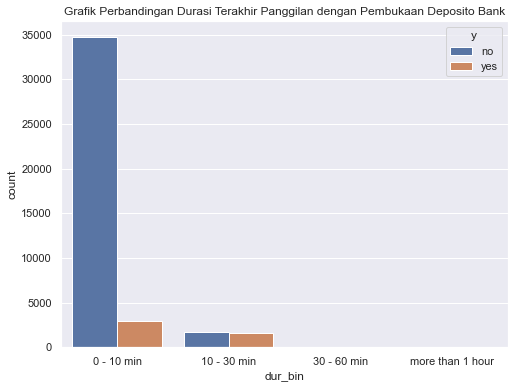

In [85]:
# Visualisasi data Analisis Multivariate antara duration dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Durasi Terakhir Panggilan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Durasi terakhir panggilan antara nasabah bank dengan tim kampanye didominasi rentang 0 - 10 menit

In [86]:
# Pengelompokan kategori banyak kontak selama kampanye
cam_bin = [0, 10, 20, 30, 40, 50, df['campaign'].max()] ## Membuat Kelompok Campaign
labels_campaign = ['0 - 10 times', '10 - 20 times', '20 - 30 times', '30 - 40 times', '40-50 times', 'more than 50 times'] ## Label untuk Kelompok Campaign
df['cam_bin'] = pd.cut(df['campaign'], bins=cam_bin, labels=labels_campaign)

In [87]:
# Analisis Multivariate antara campaign dan y
(pd.crosstab(index = df['cam_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y                      no    yes
cam_bin                         
0 - 10 times        86.69  11.20
10 - 20 times        1.67   0.06
20 - 30 times        0.30   0.00
30 - 40 times        0.07   0.00
40-50 times          0.01   0.00
more than 50 times   0.00   0.00

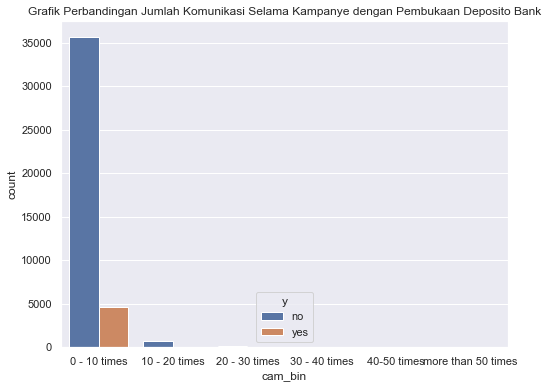

In [88]:
# Visualisasi data Analisis Multivariate antara campaign dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Komunikasi Selama Kampanye dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Jumlah komunikasi tim kampanye dengan nasabah selama masa kampanye didominasi kelompok 0 - 10 kali

In [89]:
# Pengelompokan kategori banyak jumlah hari berlalu setelah kontak dengan nasabah selama kampanye
pdays_bin = [0, 10, 20, 30, df['pdays'].max()] ## Membuat Kelompok Pdays
labels_pdays = ['0 - 10 days', '10 - 20 days', '20 - 30 days', 'no contact'] ## Label untuk Kelompok Pdays
df['pdays_bin'] = pd.cut(df['pdays'], bins=pdays_bin, labels=labels_pdays)

In [90]:
# Analisis Multivariate antara pdays dan y
(pd.crosstab(index = df['pdays_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y                no   yes
pdays_bin                
0 - 10 days    1.11  2.04
10 - 20 days   0.21  0.26
20 - 30 days   0.00  0.02
no contact    87.44  8.92

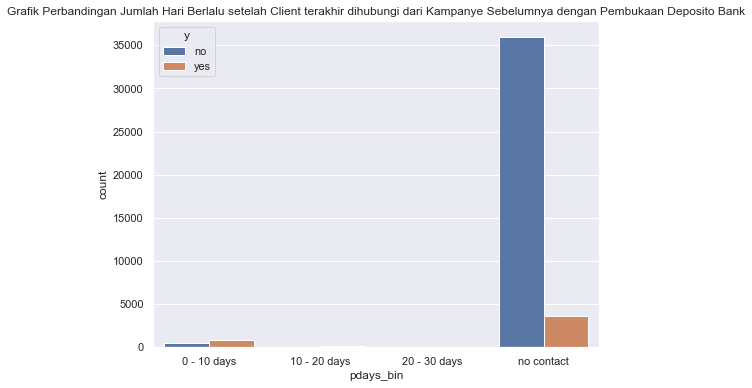

In [91]:
# Visualisasi data Analisis Multivariate antara pdays dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu setelah Client terakhir dihubungi dari Kampanye Sebelumnya dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang memilih untuk membuka deposito didominasi oleh client yang tidak dihubungi dari kampanye sebelumnya

In [92]:
# Analisis Multivariate antara previous dan y
(pd.crosstab(index = df['previous'], columns = df['y'], normalize = 'all')*100).round(2)

y            no   yes
previous             
0         78.72  7.63
1          8.73  2.35
2          0.98  0.85
3          0.21  0.31
4          0.08  0.09
5          0.01  0.03
6          0.00  0.01
7          0.00  0.00

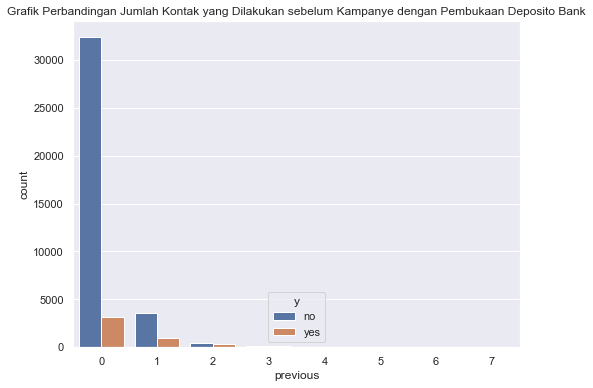

In [93]:
# Visualisasi data Analisis Multivariate antara previous dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Kontak yang Dilakukan sebelum Kampanye dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang memilih untuk membuka deposito didominasi oleh kelompok yang tidak dihubungi oleh tim kampanye sebelum kampanye

In [94]:
# Analisis Multivariate antara poutcome dan y
(pd.crosstab(index = df['poutcome'], columns = df['y'], normalize = 'all')*100).round(2)

y               no   yes
poutcome                
failure       8.85  1.47
nonexistent  78.72  7.63
success       1.16  2.17

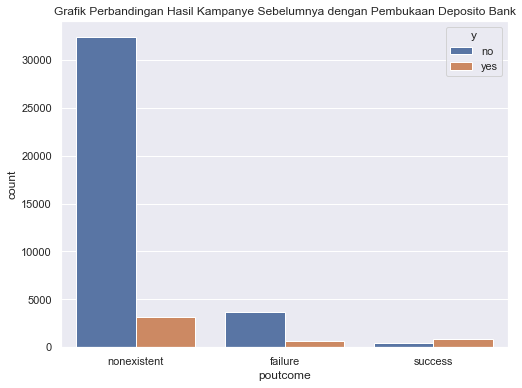

In [95]:
# Visualisasi data Analisis Multivariate antara poutcome dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'y')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : CLient yang membuka deposito didominasi oleh kelompok tidak ada hasil dari kampanye sebelumnya

In [96]:
# Analisis Multivariate antara emp.var.rate dan y
(pd.crosstab(index = df['emp.var.rate'], columns = df['y'], normalize = 'all')*100).round(2)

y                no   yes
emp.var.rate             
-3.4           1.50  1.10
-3.0           0.20  0.21
-2.9           2.60  1.44
-1.8          18.75  3.55
-1.7           0.90  0.98
-1.1           0.81  0.73
-0.2           0.02  0.00
-0.1           8.38  0.56
 1.1          18.27  0.58
 1.4          37.31  2.10

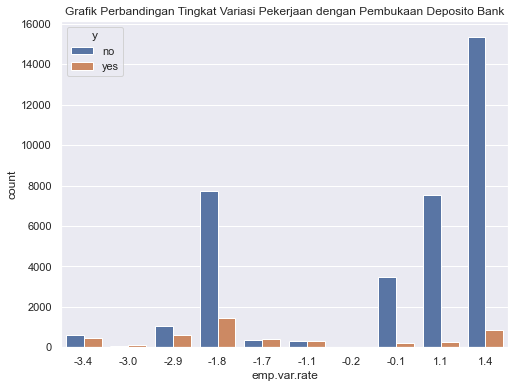

In [97]:
# Visualisasi data Analisis Multivariate antara emp.var.rate dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'y')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi oleh kelompok dengan tingkat variasi pekerjaan sebesar -1.8

In [98]:
# Analisis Multivariate antara cons.price.idx dan y
(pd.crosstab(index = df['cons.price.idx'], columns = df['y'], normalize = 'all')*100).round(2)

y                  no   yes
cons.price.idx             
92.201           1.23  0.64
92.379           0.39  0.26
92.431           0.65  0.44
92.469           0.27  0.16
92.649           0.46  0.41
92.713           0.20  0.21
92.756           0.02  0.00
92.843           0.38  0.31
92.893          12.79  1.27
92.963           1.09  0.64
93.075           4.89  1.07
93.200           8.32  0.46
93.369           0.28  0.36
93.444          11.91  0.66
93.749           0.19  0.24
93.798           0.06  0.10
93.876           0.22  0.30
93.918          15.24  0.99
93.994          18.27  0.58
94.027           0.27  0.29
94.055           0.30  0.26
94.199           0.37  0.36
94.215           0.33  0.43
94.465          10.16  0.46
94.601           0.27  0.23
94.767           0.17  0.14

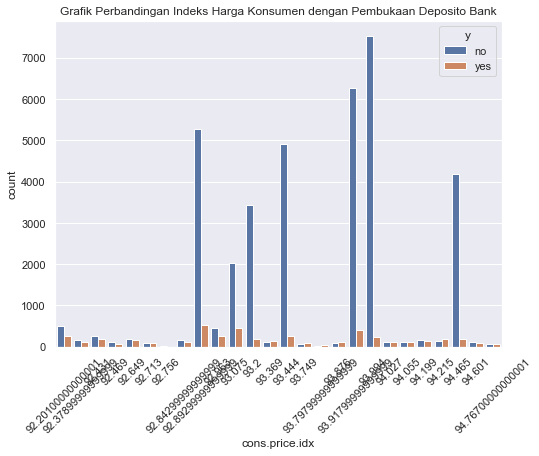

In [99]:
# Visualisasi data Analisis Multivariate antara cons.price.idx dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'y')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi kelompok Indeks Harga Konsumen sebesar 92.893

In [100]:
# Analisis Multivariate antara cons.conf.idx dan y
(pd.crosstab(index = df['cons.conf.idx'], columns = df['y'], normalize = 'all')*100).round(2)

y                 no   yes
cons.conf.idx             
-50.8           0.17  0.14
-50.0           0.38  0.31
-49.5           0.27  0.23
-47.1           4.89  1.07
-46.2          12.79  1.27
-45.9           0.02  0.00
-42.7          15.24  0.99
-42.0           8.32  0.46
-41.8          10.16  0.46
-40.8           1.09  0.64
-40.4           0.06  0.10
-40.3           0.33  0.43
-40.0           0.22  0.30
-39.8           0.30  0.26
-38.3           0.27  0.29
-37.5           0.37  0.36
-36.4          18.27  0.58
-36.1          11.91  0.66
-34.8           0.28  0.36
-34.6           0.19  0.24
-33.6           0.27  0.16
-33.0           0.20  0.21
-31.4           1.23  0.64
-30.1           0.46  0.41
-29.8           0.39  0.26
-26.9           0.65  0.44

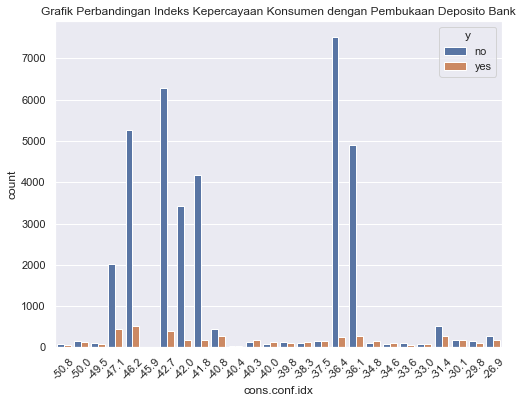

In [101]:
# Visualisasi data Analisis Multivariate antara cons.conf.idx dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'y')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi oleh kelompok dengan indeks kepercayaan konsumen sebesar -46.2

In [102]:
# Pengelompokan kategori index euribor
eur_bin = [0, 1, 2, 3, 4, df['pdays'].max()] ## Membuat Kelompok Euribor
labels_eur = ['0 - 1', '1 - 2', '2 - 3', '3 - 4', '>4'] ## Label untuk Kelompok Euribor
df['eur_bin'] = pd.cut(df['euribor3m'], bins=eur_bin, labels=labels_eur)

In [103]:
# Analisis Multivariate antara euribor3m dan y
(pd.crosstab(index = df['eur_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y           no   yes
eur_bin             
0 - 1     5.15  4.34
1 - 2    19.61  3.68
3 - 4     0.03  0.00
>4       63.95  3.25

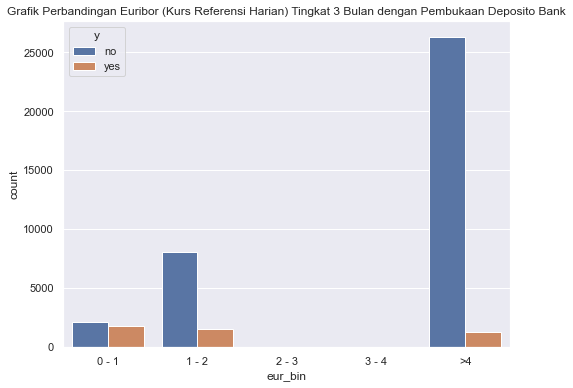

In [104]:
# Visualisasi data Analisis Multivariate antara euribor3m dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang melakukan pembukaan deposito didominasi oleh kelompok euribor sebesar 0 - 1

In [105]:
# Analisis Multivariate antara nr.employed dan y
(pd.crosstab(index = df['nr.employed'], columns = df['y'], normalize = 'all')*100).round(2)

y               no   yes
nr.employed             
4963.6        0.81  0.73
4991.6        0.90  0.98
5008.7        0.68  0.90
5017.5        1.50  1.10
5023.5        0.20  0.21
5076.2        2.60  1.44
5099.1       18.07  2.65
5176.3        0.02  0.00
5191.0       18.27  0.58
5195.8        8.38  0.56
5228.1       37.31  2.10

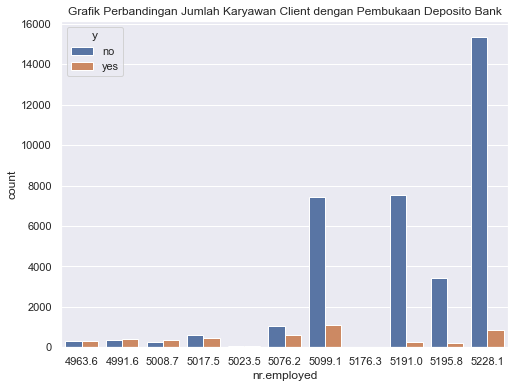

In [106]:
# Visualisasi data Analisis Multivariate antara nr.employed dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Karyawan Client dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi oleh kelompok dengan jumlah karyawan sebanyak 5228 karyawan

### Analisis Multivariate terhadap Age

In [107]:
# Analisis Multivariate antara age dan job
(pd.crosstab(index = df['age_bin'], columns = df['job'], normalize = 'all')*100).round(2)

job       admin.  blue-collar  entrepreneur  housemaid  management  retired  \
age_bin                                                                       
Teenager    0.00         0.02          0.01       0.00        0.00     0.00   
Adult      16.52        12.71          1.71       0.94        3.29     0.09   
Elder       8.78         9.74          1.81       1.64        3.81     4.09   

job       self-employed  services  student  technician  unemployed  unknown  
age_bin                                                                      
Teenager           0.00      0.01     0.29        0.01        0.00     0.00  
Adult              1.93      6.14     1.82       10.59        1.40     0.24  
Elder              1.52      3.49     0.01        5.78        1.07     0.56

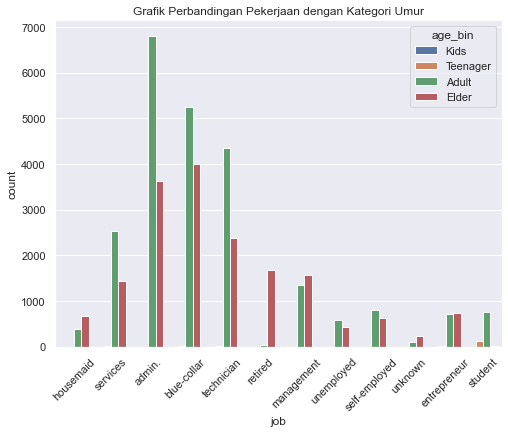

In [108]:
# Visualisasi data Analisis Multivariate antara age dan job
plt.figure(figsize = (8,6))
sns.countplot(x = 'job', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Pekerjaan dengan Kategori Umur')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok pekerja admin dengan pesebaran paling banyak kategori usia dewasa

In [109]:
# Analisis Multivariate antara age dan marital
(pd.crosstab(index = df['age_bin'], columns = df['marital'], normalize = 'all')*100).round(2)

marital   divorced  married  single  unknown
age_bin                                     
Teenager      0.00     0.00    0.34     0.00
Adult         4.21    29.36   23.67     0.12
Elder         6.99    31.16    4.07     0.08

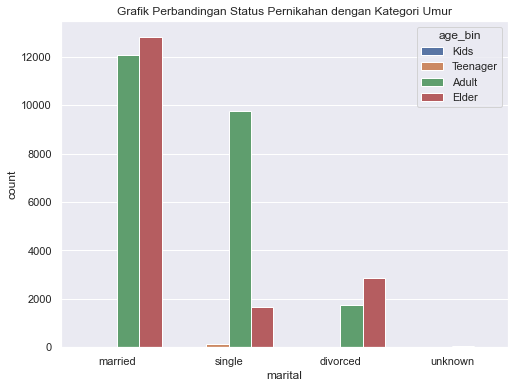

In [110]:
# Visualisasi data Analisis Multivariate antara age dan marital
plt.figure(figsize = (8,6))
sns.countplot(x = 'marital', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Status Pernikahan dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan status sudah menikah dengan pesebaran didominasi oleh kategori lansia

In [111]:
# Analisis Multivariate antara age dan education
(pd.crosstab(index = df['age_bin'], columns = df['education'], normalize = 'all')*100).round(2)

education  basic 4y  basic 6y  basic 9y  high school  illiterate  \
age_bin                                                            
Teenager       0.03      0.01      0.07          0.1        0.00   
Adult          2.78      3.01      8.66         14.9        0.01   
Elder          7.32      2.54      5.96          8.1        0.04   

education  professional course  university degree  unknown  
age_bin                                                     
Teenager                  0.00               0.00     0.11  
Adult                     7.49              18.93     1.60  
Elder                     5.23              10.61     2.49

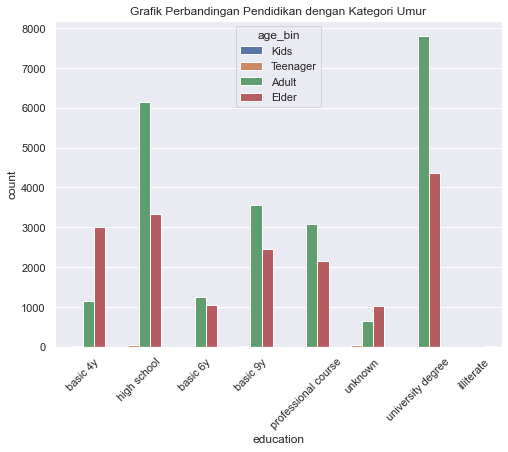

In [112]:
# Visualisasi data Analisis Multivariate antara age dan education
plt.figure(figsize = (8,6))
sns.countplot(x = 'education', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Pendidikan dengan Kategori Umur')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh latar belakang pendidikan sarjana dengan dominasi oleh kelompok dewasa

In [113]:
# Analisis Multivariate antara age dan default
(pd.crosstab(index = df['age_bin'], columns = df['default'], normalize = 'all')*100).round(2)

default      no  unknown  yes
age_bin                      
Teenager   0.33     0.01  0.0
Adult     48.88     8.48  0.0
Elder     29.91    12.37  0.0

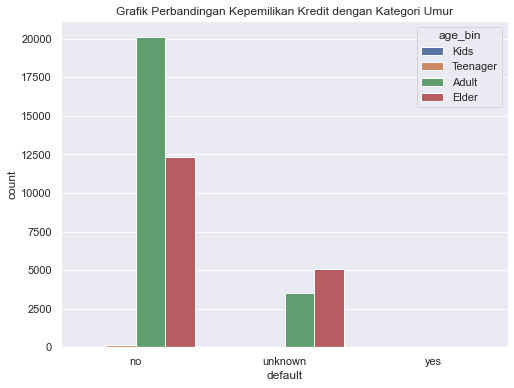

In [114]:
# Visualisasi data Analisis Multivariate antara age dan default
plt.figure(figsize = (8,6))
sns.countplot(x = 'default', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Kepemilikan Kredit dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang tidak memiliki kredit dengan dominasi oleh kelompok kategori dewasa

In [115]:
# Analisis Multivariate antara age dan housing
(pd.crosstab(index = df['age_bin'], columns = df['housing'], normalize = 'all')*100).round(2)

housing      no  unknown    yes
age_bin                        
Teenager   0.12     0.01   0.21
Adult     25.93     1.36  30.07
Elder     19.16     1.03  22.10

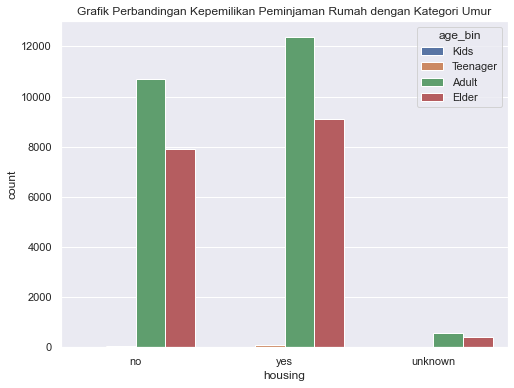

In [116]:
# Visualisasi data Analisis Multivariate antara age dan housing
plt.figure(figsize = (8,6))
sns.countplot(x = 'housing', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Kepemilikan Peminjaman Rumah dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan status memiliki peminjaman rumah dengan dominasi oleh kategori dewasa

In [117]:
# Analisis Multivariate antara age dan loan
(pd.crosstab(index = df['age_bin'], columns = df['loan'], normalize = 'all')*100).round(2)

loan         no  unknown   yes
age_bin                       
Teenager   0.27     0.01  0.06
Adult     47.21     1.36  8.80
Elder     34.94     1.03  6.32

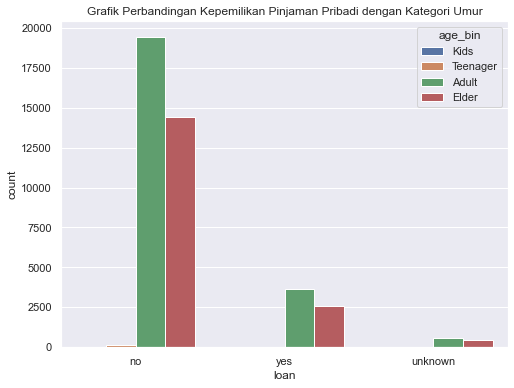

In [303]:
# Visualisasi data Analisis Multivariate antara age dan loan
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Pribadi dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan status tidak memiliki pinjaman pribadi dan didominasi oleh kategori umur dewasa

In [118]:
# Analisis Multivariate antara age dan contact
(pd.crosstab(index = df['age_bin'], columns = df['contact'], normalize = 'all')*100).round(2)

contact   cellular  telephone
age_bin                      
Teenager      0.28       0.06
Adult        36.93      20.43
Elder        26.26      16.04

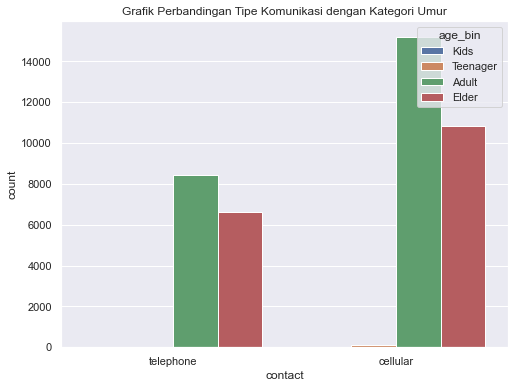

In [304]:
# Visualisasi data Analisis Multivariate antara age dan contact
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Tipe Komunikasi dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kategori tipe komunikasi dengan seluler dengan dominasi kategori umur dewasa

In [119]:
# Analisis Multivariate antara age dan month
(pd.crosstab(index = df['age_bin'], columns = df['month'], normalize = 'all')*100).round(2)

month      mar   apr    may   jun    jul   aug   sep   oct   nov   dec
age_bin                                                               
Teenager  0.02  0.08   0.07  0.02   0.03  0.05  0.02  0.01  0.03  0.01
Adult     0.86  3.54  20.32  7.43  10.27  7.65  0.72  0.91  5.49  0.17
Elder     0.44  2.77  13.04  5.47   7.11  7.30  0.64  0.82  4.44  0.27

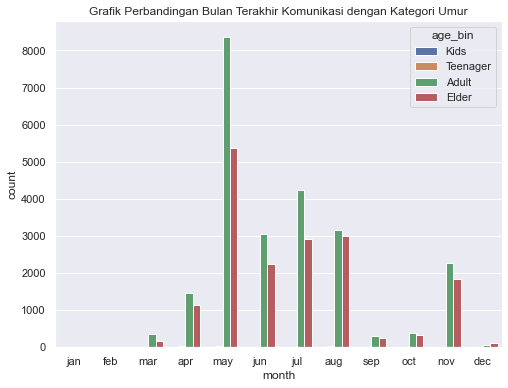

In [305]:
# Visualisasi data Analisis Multivariate antara age dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang terakhir dihubungi pada bulan Mei dan didominasi oleh kategori umur dewasa

In [120]:
# Analisis Multivariate antara age dan day_of_week
(pd.crosstab(index = df['age_bin'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week    mon    tue    wed    thu    fri
age_bin                                       
Teenager      0.06   0.08   0.07   0.06   0.06
Adult        11.36  10.99  11.82  12.38  10.82
Elder         9.24   8.57   7.86   8.50   8.13

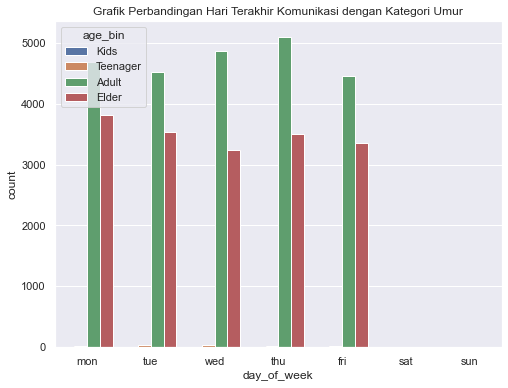

In [306]:
# Visualisasi data Analisis Multivariate antara age dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Hari Terakhir Komunikasi dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang terakhir dihubungi pada hari Kamis dengan dominasi oleh kategori umur dewasa

In [121]:
# Analisis Multivariate antara age dan duration
(pd.crosstab(index = df['age_bin'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin   0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
age_bin                                                         
Teenager        0.31         0.03         0.00              0.00
Adult          52.52         4.69         0.14              0.01
Elder          38.75         3.45         0.09              0.00

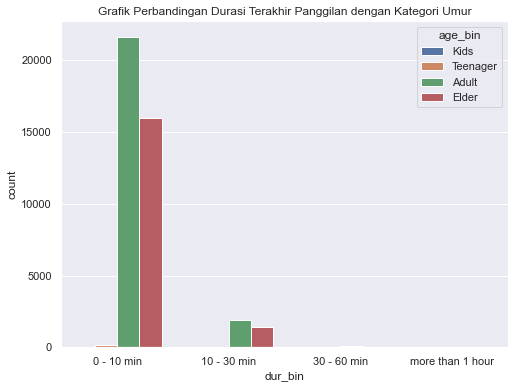

In [307]:
# Visualisasi data Analisis Multivariate antara age dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Durasi Terakhir Panggilan dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight :  Nasabah didominasi oleh kelompok durasi terakhir panggilan 0 - 10 menit dengan dominasi kelompok oleh kategori usia dewasa

In [122]:
# Analisis Multivariate antara age dan campaign
(pd.crosstab(index = df['age_bin'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin   0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
age_bin                                                               
Teenager          0.34           0.00           0.00           0.00   
Adult            56.22           0.93           0.17           0.04   
Elder            41.34           0.79           0.13           0.03   

cam_bin   40-50 times  more than 50 times  
age_bin                                    
Teenager         0.00                 0.0  
Adult            0.01                 0.0  
Elder            0.00                 0.0

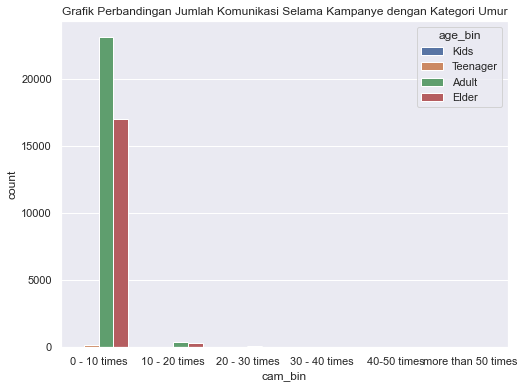

In [308]:
# Visualisasi data Analisis Multivariate antara age dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Jumlah Komunikasi Selama Kampanye dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang dihubungi sebanyak 0 - 10 kali selama kampanye dengan dominasi kelompok oleh kategori umur dewasa

In [123]:
# Analisis Multivariate antara age dan pdays
(pd.crosstab(index = df['age_bin'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin  0 - 10 days  10 - 20 days  20 - 30 days  no contact
age_bin                                                       
Teenager          0.06          0.01          0.00        0.27
Adult             1.69          0.30          0.01       55.36
Elder             1.39          0.16          0.01       40.73

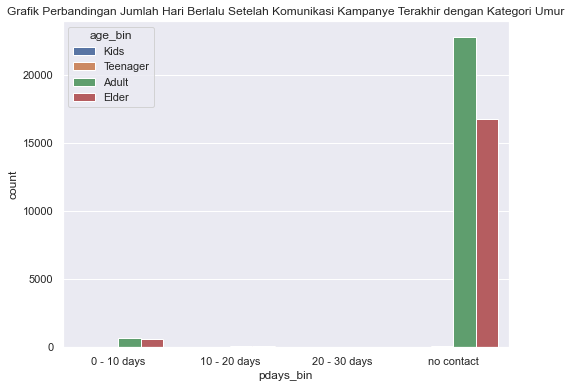

In [309]:
# Visualisasi data Analisis Multivariate antara age dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu Setelah Komunikasi Kampanye Terakhir dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang tidak dihubungi tim kampanye sebelumnya dengan dominasi kelompok oleh kategori umur dewasa

In [124]:
# Analisis Multivariate antara age dan previous
(pd.crosstab(index = df['age_bin'], columns = df['previous'], normalize = 'all')*100).round(2)

previous      0     1     2     3     4     5     6    7
age_bin                                                 
Teenager   0.21  0.07  0.03  0.02  0.00  0.00  0.00  0.0
Adult     49.32  6.62  1.01  0.29  0.10  0.03  0.00  0.0
Elder     36.82  4.38  0.79  0.21  0.07  0.01  0.01  0.0

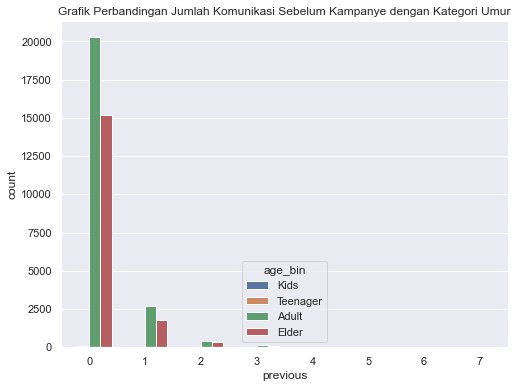

In [310]:
# Visualisasi data Analisis Multivariate antara age dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Jumlah Komunikasi Sebelum Kampanye dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang tidak dihubungi sebelum kampanye dengan dominasi kelompok oleh kategori umur dewasa

In [125]:
# Analisis Multivariate antara age dan poutcome
(pd.crosstab(index = df['age_bin'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome  failure  nonexistent  success
age_bin                                
Teenager     0.07         0.21     0.07
Adult        6.21        49.32     1.83
Elder        4.04        36.82     1.43

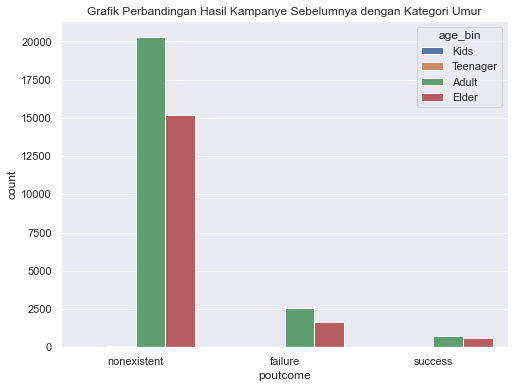

In [311]:
# Visualisasi data Analisis Multivariate antara age dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang hasil dari kampanye sebelumnya tidak ada dengan dominasi kelompok oleh kategori umur dewasa

In [126]:
# Analisis Multivariate antara age dan emp.var.rate
(pd.crosstab(index = df['age_bin'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
age_bin                                                                    
Teenager      0.04  0.01  0.06   0.15  0.02  0.02  0.00  0.00   0.01   0.02
Adult         1.24  0.15  2.31  14.43  1.14  0.92  0.01  4.96  10.30  21.89
Elder         1.32  0.25  1.67   7.72  0.71  0.60  0.01  3.98   8.54  17.50

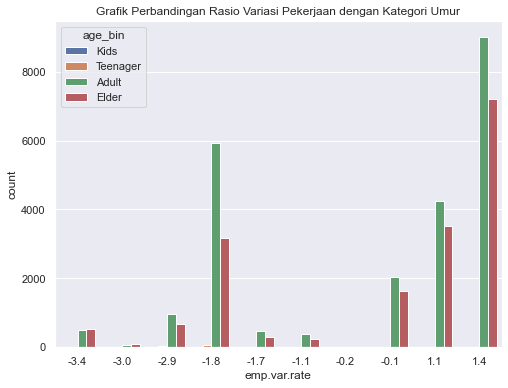

In [312]:
# Visualisasi data Analisis Multivariate antara age dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Rasio Variasi Pekerjaan dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan rasio variasi pekerjaan sebesar 1.4 dengan dominasi kelompok oleh kategori umur dewasa

In [127]:
# Analisis Multivariate antara age dan cons.price.idx
(pd.crosstab(index = df['age_bin'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
age_bin                                                                  
Teenager          0.04    0.01    0.01    0.01    0.02    0.01    0.00   
Adult             0.94    0.24    0.54    0.22    0.46    0.15    0.01   
Elder             0.89    0.39    0.54    0.21    0.39    0.25    0.01   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
age_bin                                                                  
Teenager          0.01    0.03    0.01    0.06    0.00    0.00    0.00   
Adult             0.49    9.79    1.16    3.36    4.86    0.38    6.42   
Elder             0.18    4.24    0.57    2.54    3.91    0.26    6.14   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
age_bin                                                                  
Teenager          0.02    0.00    0.02    0.02    0.01    0.01    0.00   
Adult             0.18    0.10    0.23    9.62   10.30    0.29    0.41   
Elder             0.23    0.06    0.26    6.60    8.54    0.26    0.14   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
age_bin                                                 
Teenager          0.01    0.01    0.00    0.01    0.01  
Adult             0.48    0.44    5.85    0.27    0.17  
Elder             0.25    0.31    4.76    0.22    0.13

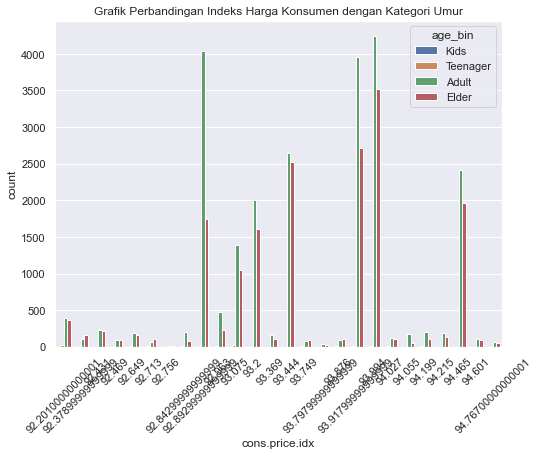

In [314]:
# Visualisasi data Analisis Multivariate antara age dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Kategori Umur')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didmoniasi oleh kelompok dengan indeks harga konsumen sebesar 93.994 dengan dominasi kelompok oleh kategori umur dewasa

In [128]:
# Analisis Multivariate antara age dan cons.conf.idx
(pd.crosstab(index = df['age_bin'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
age_bin                                                                        
Teenager        0.01   0.01   0.01   0.06   0.03   0.00   0.02   0.00   0.00   
Adult           0.17   0.49   0.27   3.36   9.79   0.01   9.62   4.86   5.85   
Elder           0.13   0.18   0.22   2.54   4.24   0.01   6.60   3.91   4.76   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
age_bin                                                                        
Teenager        0.01   0.00   0.01   0.02   0.00   0.01   0.01   0.01   0.00   
Adult           1.16   0.10   0.44   0.23   0.41   0.29   0.48  10.30   6.42   
Elder           0.57   0.06   0.31   0.26   0.14   0.26   0.25   8.54   6.14   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
age_bin                                                                
Teenager        0.00   0.02   0.01   0.01   0.04   0.02   0.01   0.01  
Adult           0.38   0.18   0.22   0.15   0.94   0.46   0.24   0.54  
Elder           0.26   0.23   0.21   0.25   0.89   0.39   0.39   0.54

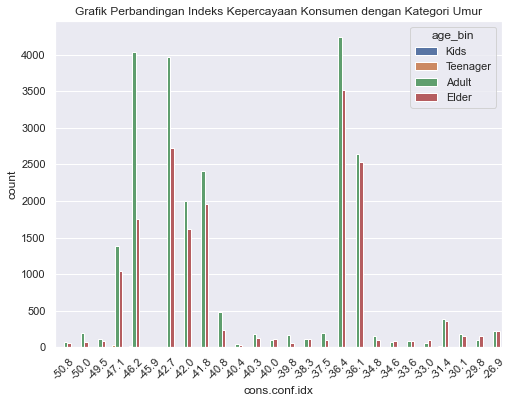

In [316]:
# Visualisasi data Analisis Multivariate antara age dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Kategori Umur')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan indeks kepercayaan konsumen sebesar -46.2 dengan dominasi kelompok oleh kategori usia dewasa

In [129]:
# Analisis Multivariate antara age dan euribor3m
(pd.crosstab(index = df['age_bin'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin   0 - 1  1 - 2  3 - 4     >4
age_bin                             
Teenager   0.17   0.13   0.00   0.03
Adult      4.94  15.26   0.02  37.15
Elder      4.37   7.89   0.01  30.01

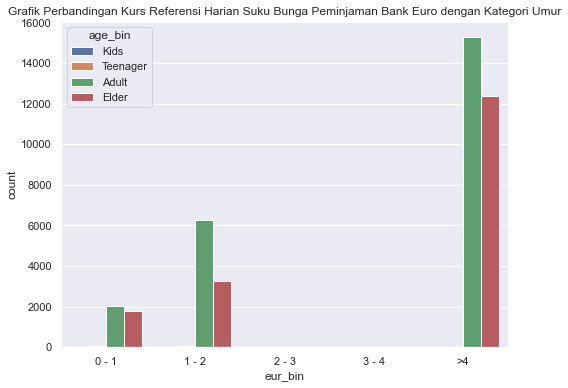

In [318]:
# Visualisasi data Analisis Multivariate antara age dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Kurs Referensi Harian Suku Bunga Peminjaman Bank Euro dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok Kurs Referensi Harian Suku Bunga Peminjaman Bank Euro lebih besar dari 4 dengan dominasi kelompok oleh kategori usia dewasa

In [130]:
# Analisis Multivariate antara age dan nr.employed
(pd.crosstab(index = df['age_bin'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
age_bin                                                                       
Teenager       0.02    0.02    0.04    0.04    0.01    0.06    0.11    0.00   
Adult          0.92    1.14    0.79    1.24    0.15    2.31   13.64    0.01   
Elder          0.60    0.71    0.75    1.32    0.25    1.67    6.97    0.01   

nr.employed  5191.0  5195.8  5228.1  
age_bin                              
Teenager       0.01    0.00    0.02  
Adult         10.30    4.96   21.89  
Elder          8.54    3.98   17.50

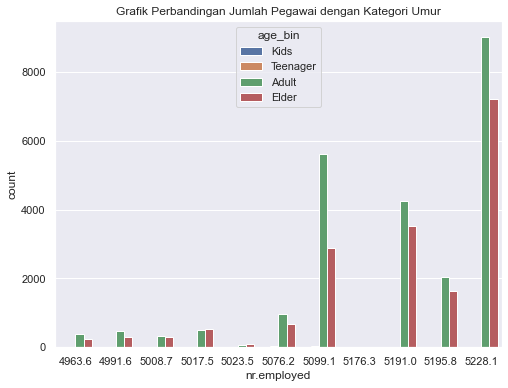

In [319]:
# Visualisasi data Analisis Multivariate antara age dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'age_bin')
plt.title('Grafik Perbandingan Jumlah Pegawai dengan Kategori Umur')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang memiliki jumlah pegawai sebanyak 5228 pegawai dan kelompok tersebut didominasi oleh kategori usia dewasa

### Analisis Multivariate terhadap Job

In [131]:
# Analisis Multivariate antara job dan marital
(pd.crosstab(index = df['job'], columns = df['marital'], normalize = 'all')*100).round(2)

marital        divorced  married  single  unknown
job                                              
admin.             3.11    12.75    9.41     0.03
blue-collar        1.77    16.24    4.43     0.03
entrepreneur       0.43     2.60    0.49     0.01
housemaid          0.39     1.89    0.29     0.01
management         0.80     5.07    1.22     0.01
retired            0.84     3.09    0.23     0.01
self-employed      0.32     2.19    0.92     0.01
services           1.29     5.57    2.76     0.01
student            0.02     0.10    2.00     0.00
technician         1.88     8.91    5.55     0.03
unemployed         0.30     1.54    0.61     0.01
unknown            0.03     0.57    0.18     0.02

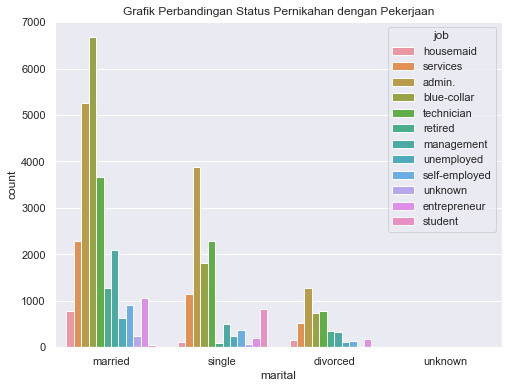

In [320]:
# Visualisasi data Analisis Multivariate antara job dan marital
plt.figure(figsize = (8,6))
sns.countplot(x = 'marital', data = df , hue = 'job')
plt.title('Grafik Perbandingan Status Pernikahan dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan status sudah menikah dan kelompok didominasi oleh blue-collar (buruh)

In [132]:
# Analisis Multivariate antara job dan education
(pd.crosstab(index = df['job'], columns = df['education'], normalize = 'all')*100).round(2)

education      basic 4y  basic 6y  basic 9y  high school  illiterate  \
job                                                                    
admin.             0.19      0.37      1.21         8.08        0.00   
blue-collar        5.63      3.46      8.80         2.13        0.02   
entrepreneur       0.33      0.17      0.51         0.57        0.00   
housemaid          1.15      0.19      0.23         0.42        0.00   
management         0.24      0.21      0.40         0.72        0.00   
retired            1.45      0.18      0.35         0.67        0.01   
self-employed      0.23      0.06      0.53         0.29        0.01   
services           0.32      0.55      0.94         6.51        0.00   
student            0.06      0.03      0.24         0.87        0.00   
technician         0.14      0.21      0.93         2.12        0.00   
unemployed         0.27      0.08      0.45         0.63        0.00   
unknown            0.13      0.05      0.08         0.09        0.00   

education      professional course  university degree  unknown  
job                                                             
admin.                        0.88              13.97     0.60  
blue-collar                   1.10               0.23     1.10  
entrepreneur                  0.33               1.48     0.14  
housemaid                     0.14               0.34     0.10  
management                    0.22               5.01     0.30  
retired                       0.59               0.69     0.24  
self-employed                 0.41               1.86     0.07  
services                      0.53               0.42     0.36  
student                       0.10               0.41     0.41  
technician                    8.06               4.39     0.51  
unemployed                    0.34               0.64     0.05  
unknown                       0.03               0.11     0.32

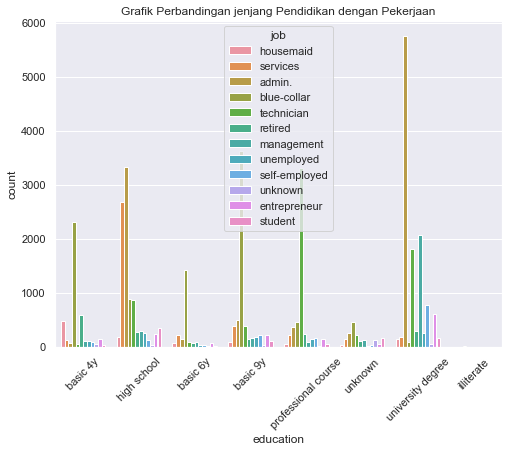

In [322]:
# Visualisasi data Analisis Multivariate antara job dan education
plt.figure(figsize = (8,6))
sns.countplot(x = 'education', data = df , hue = 'job')
plt.title('Grafik Perbandingan jenjang Pendidikan dengan Pekerjaan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan latar belakang pendidikan jenjang perguruan tinggi (sarjana) dengan dominasi kelompok oleh pekerja admin

In [133]:
# Analisis Multivariate antara job dan default
(pd.crosstab(index = df['job'], columns = df['default'], normalize = 'all')*100).round(2)

default           no  unknown  yes
job                               
admin.         22.16     3.14  0.0
blue-collar    14.78     7.69  0.0
entrepreneur    2.80     0.73  0.0
housemaid       1.80     0.77  0.0
management      5.99     1.11  0.0
retired         3.22     0.95  0.0
self-employed   2.77     0.68  0.0
services        7.41     2.22  0.0
student         1.87     0.25  0.0
technician     14.00     2.37  0.0
unemployed      1.88     0.58  0.0
unknown         0.43     0.37  0.0

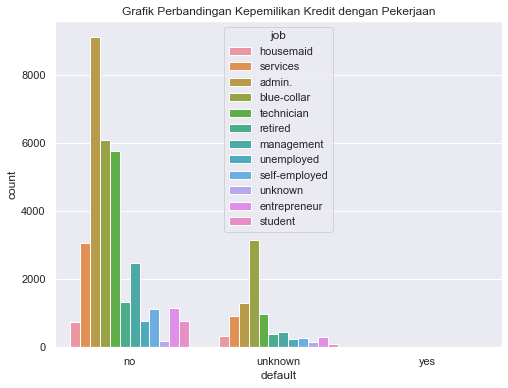

In [323]:
# Visualisasi data Analisis Multivariate antara job dan default
plt.figure(figsize = (8,6))
sns.countplot(x = 'default', data = df , hue = 'job')
plt.title('Grafik Perbandingan Kepemilikan Kredit dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tidak memiliki kredit dengan dominasi kelompok oleh pekerja admin

In [134]:
# Analisis Multivariate antara job dan housing
(pd.crosstab(index = df['job'], columns = df['housing'], normalize = 'all')*100).round(2)

housing           no  unknown    yes
job                                 
admin.         11.26     0.55  13.50
blue-collar    10.45     0.58  11.44
entrepreneur    1.56     0.09   1.89
housemaid       1.19     0.07   1.31
management      3.31     0.17   3.62
retired         1.90     0.11   2.17
self-employed   1.56     0.10   1.80
services        4.41     0.25   4.98
student         0.93     0.06   1.14
technician      7.24     0.36   8.78
unemployed      1.04     0.07   1.35
unknown         0.37     0.01   0.42

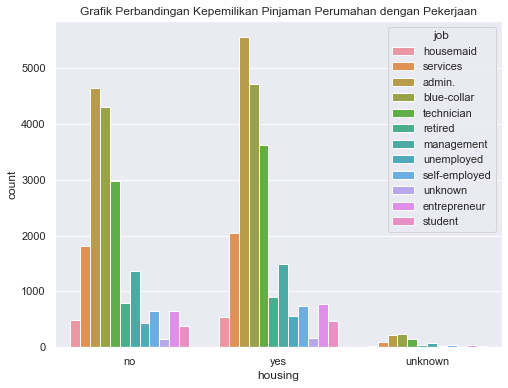

In [324]:
# Visualisasi data Analisis Multivariate antara job dan housing
plt.figure(figsize = (8,6))
sns.countplot(x = 'housing', data = df , hue = 'job')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Perumahan dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang memiliki pinjaman perumahan dengan dominasi kelompok oleh kelompok pekerja admin

In [135]:
# Analisis Multivariate antara job dan loan
(pd.crosstab(index = df['job'], columns = df['loan'], normalize = 'all')*100).round(2)

loan              no  unknown   yes
job                                
admin.         20.60     0.55  4.15
blue-collar    18.57     0.58  3.32
entrepreneur    2.95     0.09  0.50
housemaid       2.13     0.07  0.37
management      5.86     0.17  1.07
retired         3.49     0.11  0.58
self-employed   2.88     0.10  0.47
services        7.93     0.25  1.46
student         1.72     0.06  0.34
technician     13.61     0.36  2.40
unemployed      2.03     0.07  0.36
unknown         0.65     0.01  0.14

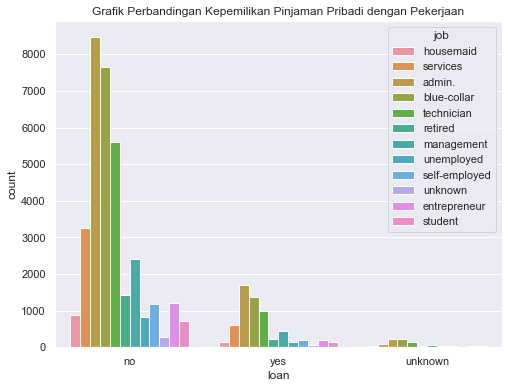

In [325]:
# Visualisasi data Analisis Multivariate antara job dan loan
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'job')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Pribadi dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang tidak memiliki pinjaman pribadi dengan dominasi kelompok oleh kelompok pekerja admin

In [136]:
# Analisis Multivariate antara job dan contact
(pd.crosstab(index = df['job'], columns = df['contact'], normalize = 'all')*100).round(2)

contact        cellular  telephone
job                               
admin.            17.30       8.00
blue-collar       12.36      10.11
entrepreneur       2.08       1.46
housemaid          1.55       1.02
management         4.62       2.48
retired            2.99       1.19
self-employed      2.17       1.28
services           5.61       4.03
student            1.63       0.50
technician        11.26       5.11
unemployed         1.51       0.96
unknown            0.41       0.39

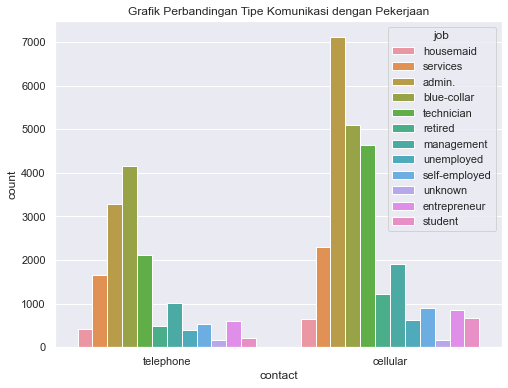

In [326]:
# Visualisasi data Analisis Multivariate antara job dan contact
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'job')
plt.title('Grafik Perbandingan Tipe Komunikasi dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan tipe komunikasi seluler dan dominasi kelompok oleh kelompok pekerja admin

In [137]:
# Analisis Multivariate antara job dan month
(pd.crosstab(index = df['job'], columns = df['month'], normalize = 'all')*100).round(2)

month           mar   apr    may   jun   jul   aug   sep   oct   nov   dec
job                                                                       
admin.         0.41  1.56   7.33  3.01  4.41  4.95  0.40  0.48  2.63  0.12
blue-collar    0.12  1.37  10.19  3.36  4.34  1.41  0.05  0.12  1.46  0.03
entrepreneur   0.00  0.26   1.18  0.53  0.66  0.18  0.03  0.04  0.65  0.00
housemaid      0.01  0.11   0.72  0.33  0.58  0.51  0.03  0.05  0.21  0.02
management     0.10  0.47   2.21  0.85  0.97  0.87  0.11  0.12  1.36  0.03
retired        0.16  0.39   0.80  0.42  0.66  0.83  0.21  0.31  0.33  0.08
self-employed  0.06  0.24   1.01  0.50  0.53  0.51  0.05  0.05  0.48  0.01
services       0.06  0.68   4.04  1.32  1.92  0.68  0.07  0.08  0.78  0.00
student        0.10  0.25   0.56  0.25  0.25  0.28  0.12  0.13  0.13  0.05
technician     0.25  0.89   4.45  1.79  2.56  4.34  0.22  0.28  1.52  0.06
unemployed     0.04  0.13   0.64  0.41  0.40  0.29  0.08  0.07  0.37  0.02
unknown        0.00  0.02   0.29  0.15  0.13  0.15  0.02  0.02  0.02  0.00

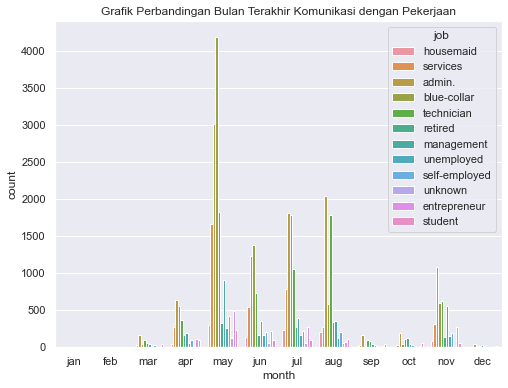

In [327]:
# Visualisasi data Analisis Multivariate antara job dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'job')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang terakhir dihubungi pada bulan Mei dengan dominasi kelompok oleh pekerja blue-collar (buruh)

In [138]:
# Analisis Multivariate antara job dan day_of_week
(pd.crosstab(index = df['job'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week     mon   tue   wed   thu   fri
job                                        
admin.         5.22  4.94  4.94  5.23  4.98
blue-collar    4.48  4.30  4.78  4.58  4.32
entrepreneur   0.78  0.64  0.67  0.78  0.66
housemaid      0.55  0.58  0.52  0.48  0.44
management     1.55  1.41  1.42  1.43  1.29
retired        0.84  0.92  0.84  0.77  0.81
self-employed  0.75  0.62  0.59  0.82  0.68
services       2.03  1.93  1.85  2.02  1.82
student        0.43  0.42  0.41  0.48  0.39
technician     3.37  3.23  3.11  3.63  3.04
unemployed     0.48  0.49  0.45  0.56  0.49
unknown        0.19  0.18  0.17  0.17  0.09

In [329]:
5.22+4.48+0.78+0.55+1.55+0.84+0.75+2.03+0.43+3.37+0.48+0.19

20.67

In [330]:
5.23+4.58+0.78+0.48+1.43+0.77+0.82+2.02+0.48+3.63+0.56+0.17

20.95

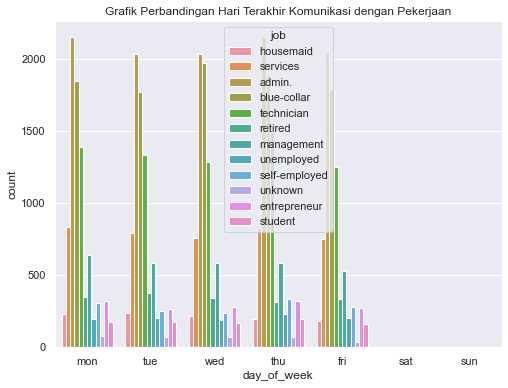

In [328]:
# Visualisasi data Analisis Multivariate antara job dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'job')
plt.title('Grafik Perbandingan Hari Terakhir Komunikasi dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang terakhir dihubungi pada hari Kamis dengan dominasi pekerja admin

In [139]:
# Analisis Multivariate antara job dan duration
(pd.crosstab(index = df['job'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin        0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
job                                                                  
admin.              23.27         1.97         0.06               0.0
blue-collar         20.52         1.88         0.07               0.0
entrepreneur         3.22         0.31         0.01               0.0
housemaid            2.39         0.18         0.01               0.0
management           6.47         0.62         0.01               0.0
retired              3.82         0.34         0.01               0.0
self-employed        3.12         0.31         0.01               0.0
services             8.82         0.80         0.01               0.0
student              1.91         0.21         0.00               0.0
technician          15.04         1.31         0.02               0.0
unemployed           2.27         0.18         0.01               0.0
unknown              0.74         0.06         0.00               0.0

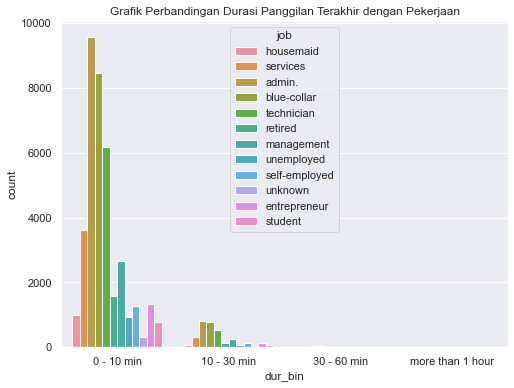

In [331]:
# Visualisasi data Analisis Multivariate antara job dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'job')
plt.title('Grafik Perbandingan Durasi Panggilan Terakhir dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan durasi panggilan terakhir selama 0 - 10 menit dengan dominasi kelompok oleh pekerja admin 

In [140]:
# Analisis Multivariate antara job dan campaign
(pd.crosstab(index = df['job'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin        0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
job                                                                        
admin.                24.70           0.50           0.08           0.02   
blue-collar           22.00           0.37           0.08           0.01   
entrepreneur           3.46           0.07           0.01           0.00   
housemaid              2.51           0.06           0.01           0.00   
management             6.96           0.11           0.02           0.00   
retired                4.09           0.06           0.02           0.00   
self-employed          3.37           0.06           0.01           0.00   
services               9.44           0.16           0.03           0.01   
student                2.11           0.02           0.00           0.00   
technician            16.06           0.26           0.04           0.01   
unemployed             2.40           0.05           0.01           0.00   
unknown                0.78           0.02           0.00           0.00   

cam_bin        40-50 times  more than 50 times  
job                                             
admin.                 0.0                 0.0  
blue-collar            0.0                 0.0  
entrepreneur           0.0                 0.0  
housemaid              0.0                 0.0  
management             0.0                 0.0  
retired                0.0                 0.0  
self-employed          0.0                 0.0  
services               0.0                 0.0  
student                0.0                 0.0  
technician             0.0                 0.0  
unemployed             0.0                 0.0  
unknown                0.0                 0.0

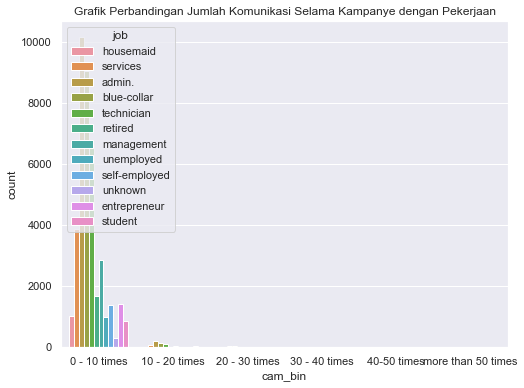

In [332]:
# Visualisasi data Analisis Multivariate antara job dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'job')
plt.title('Grafik Perbandingan Jumlah Komunikasi Selama Kampanye dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan jumlah komunikasi sebanyak 0 - 10 kali selama kampanye dengan dominasi kelompok oleh pekerja admin

In [141]:
# Analisis Multivariate antara job dan pdays
(pd.crosstab(index = df['job'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin      0 - 10 days  10 - 20 days  20 - 30 days  no contact
job                                                               
admin.                0.97          0.15          0.01       24.17
blue-collar           0.26          0.05          0.00       22.16
entrepreneur          0.05          0.01          0.00        3.47
housemaid             0.09          0.01          0.00        2.47
management            0.23          0.02          0.00        6.84
retired               0.38          0.04          0.00        3.75
self-employed         0.07          0.01          0.00        3.37
services              0.16          0.02          0.00        9.46
student               0.27          0.06          0.00        1.79
technician            0.46          0.09          0.01       15.81
unemployed            0.15          0.00          0.00        2.30
unknown               0.05          0.00          0.00        0.75

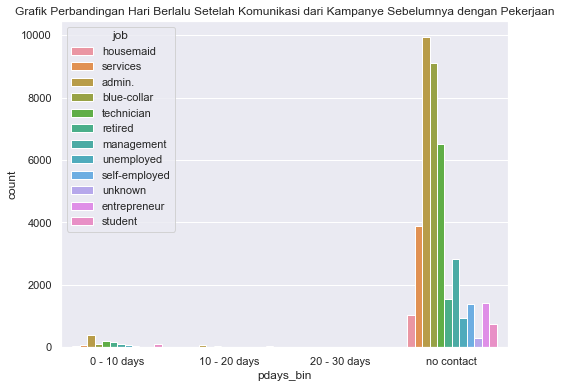

In [333]:
# Visualisasi data Analisis Multivariate antara job dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'job')
plt.title('Grafik Perbandingan Hari Berlalu Setelah Komunikasi dari Kampanye Sebelumnya dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa komunikasi dari kampanye sebelumnya dengan dominasi kelompok oleh kelompok pekerja admin

In [142]:
# Analisis Multivariate antara job dan previous
(pd.crosstab(index = df['job'], columns = df['previous'], normalize = 'all')*100).round(2)

previous           0     1     2     3     4     5    6    7
job                                                         
admin.         21.62  2.92  0.52  0.18  0.04  0.01  0.0  0.0
blue-collar    20.03  2.17  0.23  0.03  0.01  0.00  0.0  0.0
entrepreneur    3.10  0.39  0.04  0.00  0.00  0.00  0.0  0.0
housemaid       2.30  0.21  0.05  0.00  0.00  0.00  0.0  0.0
management      6.06  0.85  0.13  0.03  0.01  0.00  0.0  0.0
retired         3.23  0.64  0.21  0.06  0.02  0.00  0.0  0.0
self-employed   3.03  0.38  0.03  0.01  0.00  0.00  0.0  0.0
services        8.38  1.07  0.15  0.03  0.01  0.00  0.0  0.0
student         1.44  0.40  0.18  0.07  0.03  0.01  0.0  0.0
technician     14.36  1.68  0.22  0.07  0.04  0.01  0.0  0.0
unemployed      2.08  0.30  0.05  0.02  0.00  0.00  0.0  0.0
unknown         0.71  0.06  0.02  0.00  0.00  0.00  0.0  0.0

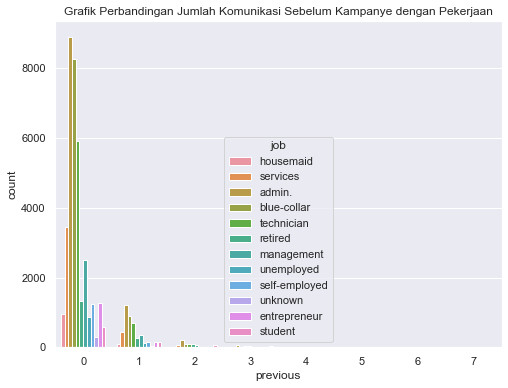

In [334]:
# Visualisasi data Analisis Multivariate antara job dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'job')
plt.title('Grafik Perbandingan Jumlah Komunikasi Sebelum Kampanye dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa komunikasi sebelum kampanye dengan dominasi kelompok oleh pekerja admin

In [143]:
# Analisis Multivariate antara job dan poutcome
(pd.crosstab(index = df['job'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome       failure  nonexistent  success
job                                         
admin.            2.65        21.62     1.04
blue-collar       2.15        20.03     0.29
entrepreneur      0.37         3.10     0.06
housemaid         0.18         2.30     0.09
management        0.80         6.06     0.23
retired           0.56         3.23     0.38
self-employed     0.35         3.03     0.07
services          1.09         8.38     0.17
student           0.40         1.44     0.29
technician        1.50        14.36     0.51
unemployed        0.23         2.08     0.15
unknown           0.04         0.71     0.05

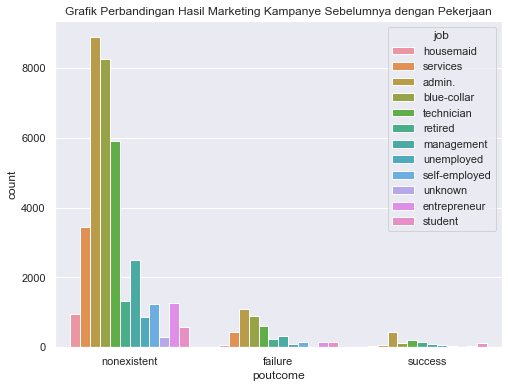

In [335]:
# Visualisasi data Analisis Multivariate antara job dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'job')
plt.title('Grafik Perbandingan Hasil Marketing Kampanye Sebelumnya dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan hasil kampanye sebelumnya tidak ada hasil dengan dominasi kelompok oleh pekerja admin

In [144]:
# Analisis Multivariate antara job dan emp.var.rate
(pd.crosstab(index = df['job'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate   -3.4  -3.0  -2.9  -1.8  -1.7  -1.1  -0.2  -0.1   1.1    1.4
job                                                                       
admin.         0.78  0.11  1.36  5.42  0.60  0.45  0.01  2.28  3.89  10.40
blue-collar    0.16  0.02  0.24  6.12  0.14  0.08  0.01  1.40  5.57   8.74
entrepreneur   0.06  0.00  0.09  0.74  0.03  0.02  0.00  0.64  0.70   1.24
housemaid      0.08  0.02  0.10  0.29  0.04  0.04  0.00  0.17  0.56   1.27
management     0.24  0.03  0.29  1.44  0.11  0.09  0.00  1.27  1.34   2.28
retired        0.47  0.08  0.44  0.82  0.23  0.20  0.00  0.17  0.52   1.24
self-employed  0.10  0.01  0.15  0.70  0.06  0.03  0.00  0.45  0.61   1.34
services       0.08  0.00  0.21  2.53  0.11  0.10  0.00  0.76  2.26   3.59
student        0.15  0.05  0.35  0.76  0.17  0.18  0.00  0.05  0.16   0.26
technician     0.35  0.05  0.57  3.02  0.27  0.28  0.00  1.40  2.57   7.86
unemployed     0.11  0.02  0.18  0.40  0.08  0.07  0.00  0.34  0.42   0.85
unknown        0.04  0.00  0.05  0.08  0.02  0.01  0.00  0.01  0.24   0.35

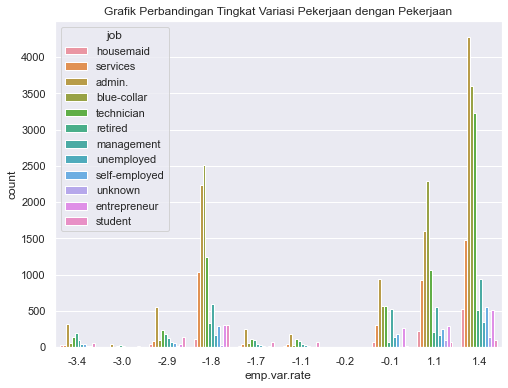

In [336]:
# Visualisasi data Analisis Multivariate antara job dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'job')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan didominasi oleh tipe pekerja admin

In [145]:
# Analisis Multivariate antara job dan cons.price.idx
(pd.crosstab(index = df['job'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
job                                                                      
admin.            0.57    0.19    0.29    0.17    0.29    0.11    0.01   
blue-collar       0.09    0.02    0.07    0.02    0.07    0.02    0.01   
entrepreneur      0.03    0.02    0.02    0.01    0.02    0.00    0.00   
housemaid         0.05    0.02    0.03    0.01    0.03    0.02    0.00   
management        0.12    0.05    0.10    0.03    0.09    0.03    0.00   
retired           0.34    0.12    0.22    0.02    0.13    0.08    0.00   
self-employed     0.05    0.04    0.02    0.02    0.03    0.01    0.00   
services          0.07    0.03    0.04    0.02    0.01    0.00    0.00   
student           0.19    0.03    0.06    0.04    0.06    0.05    0.00   
technician        0.24    0.08    0.17    0.07    0.10    0.05    0.00   
unemployed        0.08    0.04    0.05    0.01    0.02    0.02    0.00   
unknown           0.01    0.02    0.01    0.00    0.01    0.00    0.00   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
job                                                                      
admin.            0.20    3.29    0.62    1.42    2.22    0.21    4.19   
blue-collar       0.05    4.60    0.13    1.36    1.37    0.07    1.28   
entrepreneur      0.00    0.47    0.05    0.26    0.63    0.00    0.13   
housemaid         0.01    0.16    0.04    0.08    0.17    0.01    0.44   
management        0.08    0.83    0.14    0.45    1.26    0.02    0.71   
retired           0.08    0.20    0.08    0.31    0.17    0.07    0.41   
self-employed     0.03    0.40    0.08    0.23    0.44    0.03    0.44   
services          0.01    1.76    0.13    0.67    0.75    0.05    0.58   
student           0.06    0.33    0.11    0.21    0.05    0.04    0.01   
technician        0.14    1.81    0.25    0.85    1.36    0.11    4.04   
unemployed        0.01    0.20    0.08    0.12    0.34    0.03    0.19   
unknown           0.00    0.04    0.03    0.02    0.01    0.00    0.13   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
job                                                                      
admin.            0.15    0.06    0.15    3.97    3.89    0.19    0.15   
blue-collar       0.01    0.03    0.03    4.28    5.57    0.04    0.06   
entrepreneur      0.00    0.01    0.00    0.64    0.70    0.01    0.01   
housemaid         0.04    0.00    0.00    0.55    0.56    0.01    0.01   
management        0.02    0.00    0.04    0.91    1.34    0.03    0.04   
retired           0.08    0.00    0.08    0.52    0.52    0.08    0.05   
self-employed     0.01    0.01    0.00    0.50    0.61    0.02    0.02   
services          0.01    0.01    0.02    1.85    2.26    0.03    0.04   
student           0.04    0.00    0.08    0.16    0.16    0.08    0.04   
technician        0.05    0.03    0.07    2.38    2.57    0.06    0.09   
unemployed        0.01    0.00    0.03    0.36    0.42    0.01    0.04   
unknown           0.00    0.00    0.01    0.11    0.24    0.00    0.01   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
job                                                     
admin.            0.21    0.26    2.24    0.13    0.12  
blue-collar       0.03    0.05    3.18    0.02    0.03  
entrepreneur      0.01    0.01    0.47    0.00    0.00  
housemaid         0.01    0.02    0.28    0.02    0.01  
management        0.06    0.04    0.67    0.02    0.01  
retired           0.09    0.11    0.30    0.08    0.02  
self-employed     0.01    0.02    0.40    0.02    0.00  
services          0.04    0.05    1.15    0.04    0.02  
student           0.09    0.06    0.09    0.07    0.02  
technician        0.14    0.11    1.45    0.08    0.06  
unemployed        0.04    0.02    0.29    0.02    0.01  
unknown           0.00    0.01    0.11    0.00    0.00

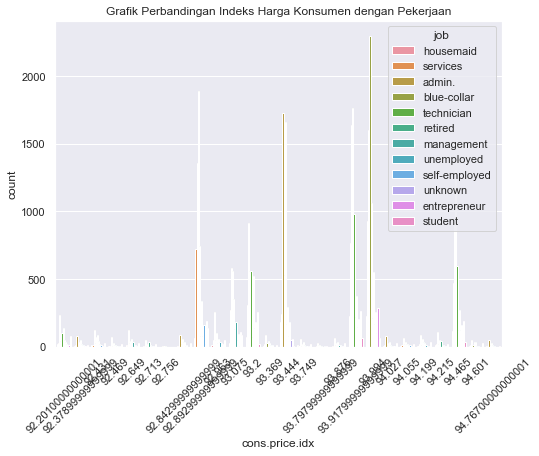

In [338]:
# Visualisasi data Analisis Multivariate antara job dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'job')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Pekerjaan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok Indeks Harga Konsumen sebesar 92.893 dengan dominasi kelompok tipe pekerja blue-collar (buruh)

In [146]:
# Analisis Multivariate antara job dan cons.conf.idx
(pd.crosstab(index = df['job'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
job                                                                            
admin.          0.12   0.20   0.13   1.42   3.29   0.01   3.97   2.22   2.24   
blue-collar     0.03   0.05   0.02   1.36   4.60   0.01   4.28   1.37   3.18   
entrepreneur    0.00   0.00   0.00   0.26   0.47   0.00   0.64   0.63   0.47   
housemaid       0.01   0.01   0.02   0.08   0.16   0.00   0.55   0.17   0.28   
management      0.01   0.08   0.02   0.45   0.83   0.00   0.91   1.26   0.67   
retired         0.02   0.08   0.08   0.31   0.20   0.00   0.52   0.17   0.30   
self-employed   0.00   0.03   0.02   0.23   0.40   0.00   0.50   0.44   0.40   
services        0.02   0.01   0.04   0.67   1.76   0.00   1.85   0.75   1.15   
student         0.02   0.06   0.07   0.21   0.33   0.00   0.16   0.05   0.09   
technician      0.06   0.14   0.08   0.85   1.81   0.00   2.38   1.36   1.45   
unemployed      0.01   0.01   0.02   0.12   0.20   0.00   0.36   0.34   0.29   
unknown         0.00   0.00   0.00   0.02   0.04   0.00   0.11   0.01   0.11   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
job                                                                            
admin.          0.62   0.06   0.26   0.15   0.15   0.19   0.21   3.89   4.19   
blue-collar     0.13   0.03   0.05   0.03   0.06   0.04   0.03   5.57   1.28   
entrepreneur    0.05   0.01   0.01   0.00   0.01   0.01   0.01   0.70   0.13   
housemaid       0.04   0.00   0.02   0.00   0.01   0.01   0.01   0.56   0.44   
management      0.14   0.00   0.04   0.04   0.04   0.03   0.06   1.34   0.71   
retired         0.08   0.00   0.11   0.08   0.05   0.08   0.09   0.52   0.41   
self-employed   0.08   0.01   0.02   0.00   0.02   0.02   0.01   0.61   0.44   
services        0.13   0.01   0.05   0.02   0.04   0.03   0.04   2.26   0.58   
student         0.11   0.00   0.06   0.08   0.04   0.08   0.09   0.16   0.01   
technician      0.25   0.03   0.11   0.07   0.09   0.06   0.14   2.57   4.04   
unemployed      0.08   0.00   0.02   0.03   0.04   0.01   0.04   0.42   0.19   
unknown         0.03   0.00   0.01   0.01   0.01   0.00   0.00   0.24   0.13   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
job                                                                    
admin.          0.21   0.15   0.17   0.11   0.57   0.29   0.19   0.29  
blue-collar     0.07   0.01   0.02   0.02   0.09   0.07   0.02   0.07  
entrepreneur    0.00   0.00   0.01   0.00   0.03   0.02   0.02   0.02  
housemaid       0.01   0.04   0.01   0.02   0.05   0.03   0.02   0.03  
management      0.02   0.02   0.03   0.03   0.12   0.09   0.05   0.10  
retired         0.07   0.08   0.02   0.08   0.34   0.13   0.12   0.22  
self-employed   0.03   0.01   0.02   0.01   0.05   0.03   0.04   0.02  
services        0.05   0.01   0.02   0.00   0.07   0.01   0.03   0.04  
student         0.04   0.04   0.04   0.05   0.19   0.06   0.03   0.06  
technician      0.11   0.05   0.07   0.05   0.24   0.10   0.08   0.17  
unemployed      0.03   0.01   0.01   0.02   0.08   0.02   0.04   0.05  
unknown         0.00   0.00   0.00   0.00   0.01   0.01   0.02   0.01

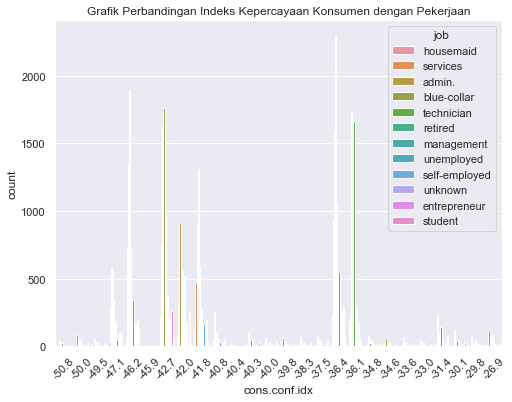

In [340]:
# Visualisasi data Analisis Multivariate antara job dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'job')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Pekerjaan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok indeks kepercayaan konsumen sebesar -36.4 dengan dominasi kelompok oleh tipe pekerja blue-collar (buruh)

In [147]:
# Analisis Multivariate antara job dan euribor3m
(pd.crosstab(index = df['job'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin        0 - 1  1 - 2  3 - 4     >4
job                                      
admin.          2.91   5.82   0.01  16.57
blue-collar     0.57   6.18   0.01  15.71
entrepreneur    0.16   0.79   0.00   2.59
housemaid       0.26   0.31   0.00   2.00
management      0.67   1.53   0.00   4.89
retired         1.51   0.73   0.00   1.93
self-employed   0.29   0.75   0.00   2.41
services        0.42   2.61   0.00   6.60
student         0.85   0.81   0.00   0.47
technician      1.35   3.19   0.01  11.83
unemployed      0.41   0.45   0.00   1.60
unknown         0.10   0.10   0.00   0.60

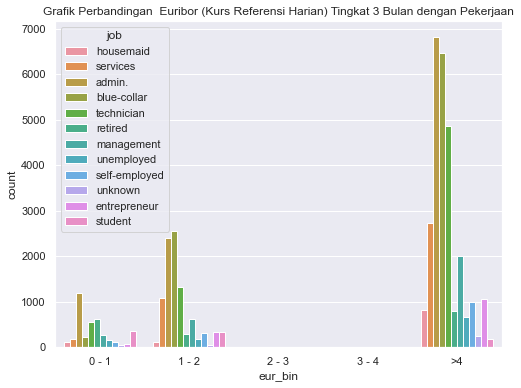

In [341]:
# Visualisasi data Analisis Multivariate antara job dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'job')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok Euribor (Kurs Referensi Harian) tingkat 3 bulan lebih besar dari 4 dengan dominasi kelompok oleh tipe pekerjaan admin

In [148]:
# Analisis Multivariate antara job dan nr.employed
(pd.crosstab(index = df['job'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed    4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
job                                                                             
admin.           0.45    0.60    0.51    0.78    0.11    1.36    4.91    0.01   
blue-collar      0.08    0.14    0.11    0.16    0.02    0.24    6.01    0.01   
entrepreneur     0.02    0.03    0.01    0.06    0.00    0.09    0.73    0.00   
housemaid        0.04    0.04    0.05    0.08    0.02    0.10    0.24    0.00   
management       0.09    0.11    0.08    0.24    0.03    0.29    1.35    0.00   
retired          0.20    0.23    0.23    0.47    0.08    0.44    0.59    0.00   
self-employed    0.03    0.06    0.04    0.10    0.01    0.15    0.66    0.00   
services         0.10    0.11    0.09    0.08    0.00    0.21    2.44    0.00   
student          0.18    0.17    0.16    0.15    0.05    0.35    0.60    0.00   
technician       0.28    0.27    0.22    0.35    0.05    0.57    2.79    0.00   
unemployed       0.07    0.08    0.07    0.11    0.02    0.18    0.33    0.00   
unknown          0.01    0.02    0.01    0.04    0.00    0.05    0.07    0.00   

nr.employed    5191.0  5195.8  5228.1  
job                                    
admin.           3.89    2.28   10.40  
blue-collar      5.57    1.40    8.74  
entrepreneur     0.70    0.64    1.24  
housemaid        0.56    0.17    1.27  
management       1.34    1.27    2.28  
retired          0.52    0.17    1.24  
self-employed    0.61    0.45    1.34  
services         2.26    0.76    3.59  
student          0.16    0.05    0.26  
technician       2.57    1.40    7.86  
unemployed       0.42    0.34    0.85  
unknown          0.24    0.01    0.35

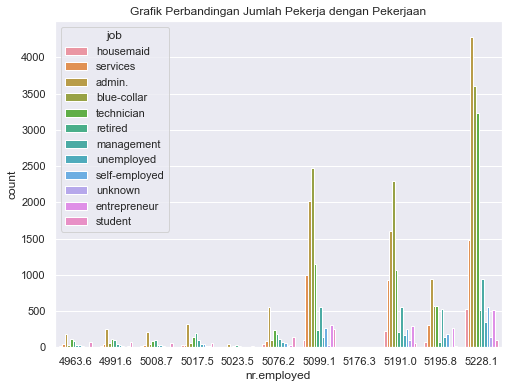

In [342]:
# Visualisasi data Analisis Multivariate antara job dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'job')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Pekerjaan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan jumlah pekerja sebanyak 5228 pekerja dengan dominasi kelompok oleh tipe pekerja admin

### Analisis Multivariate terhadap Marital

In [149]:
# Analisis Multivariate antara marital dan education
(pd.crosstab(index = df['marital'], columns = df['education'], normalize = 'all')*100).round(2)

education  basic 4y  basic 6y  basic 9y  high school  illiterate  \
marital                                                            
divorced       1.19      0.44      1.37         2.90        0.00   
married        7.84      4.29     10.09        12.52        0.04   
single         1.10      0.82      3.20         7.65        0.00   
unknown        0.01      0.01      0.02         0.03        0.00   

education  professional course  university degree  unknown  
marital                                                     
divorced                  1.60               3.25     0.45  
married                   7.66              15.52     2.56  
single                    3.46              10.70     1.17  
unknown                   0.01               0.08     0.02

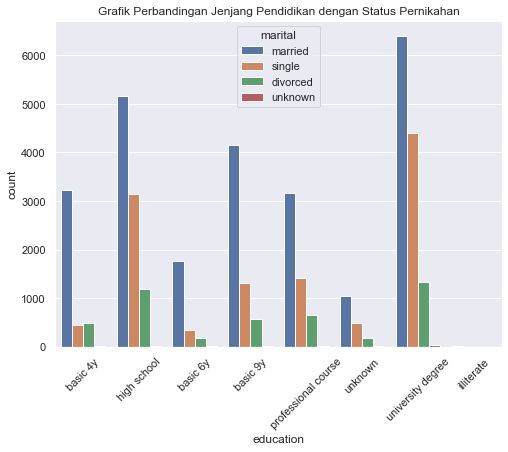

In [344]:
# Visualisasi data Analisis Multivariate antara marital dan education
plt.figure(figsize = (8,6))
sns.countplot(x = 'education', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Jenjang Pendidikan dengan Status Pernikahan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan latar belakang pendidikan perguruan tinggi (sarjana) dengan dominasi kelompok berstatus sudah menikah

In [150]:
# Analisis Multivariate antara marital dan default
(pd.crosstab(index = df['marital'], columns = df['default'], normalize = 'all')*100).round(2)

default      no  unknown   yes
marital                       
divorced   9.18     2.02  0.00
married   45.29    15.22  0.01
single    24.48     3.61  0.00
unknown    0.17     0.03  0.00

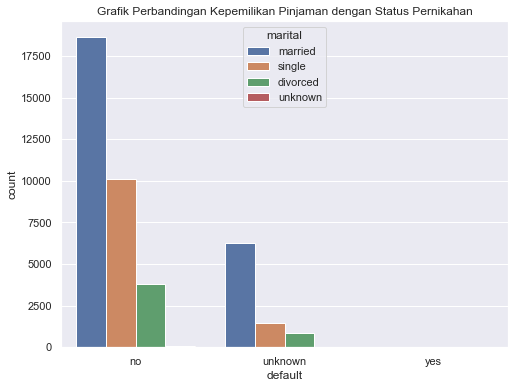

In [345]:
# Visualisasi data Analisis Multivariate antara marital dan default
plt.figure(figsize = (8,6))
sns.countplot(x = 'default', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang tidak memiliki kredit dengan dominasi kelompok oleh status sudah menikah

In [151]:
# Analisis Multivariate antara marital dan housing
(pd.crosstab(index = df['marital'], columns = df['housing'], normalize = 'all')*100).round(2)

housing      no  unknown    yes
marital                        
divorced   5.08     0.29   5.82
married   27.65     1.43  31.44
single    12.37     0.68  15.03
unknown    0.11     0.00   0.08

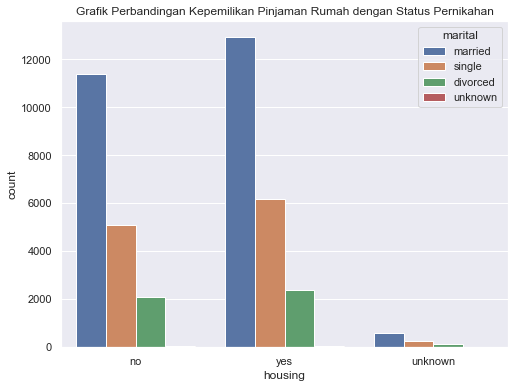

In [346]:
# Visualisasi data Analisis Multivariate antara marital dan housing
plt.figure(figsize = (8,6))
sns.countplot(x = 'housing', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Rumah dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan kepemilikan pinjaman rumah dan didominasi oleh kelompok dengan status sudah menikah

In [152]:
# Analisis Multivariate antara marital dan loan
(pd.crosstab(index = df['marital'], columns = df['loan'], normalize = 'all')*100).round(2)

loan         no  unknown   yes
marital                       
divorced   9.26     0.29  1.64
married   49.93     1.43  9.16
single    23.06     0.68  4.34
unknown    0.16     0.00  0.03

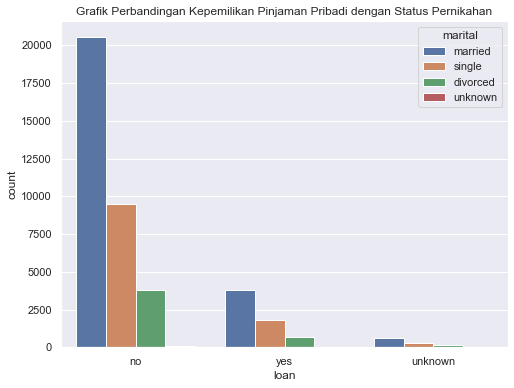

In [347]:
# Visualisasi data Analisis Multivariate antara marital dan loan
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Pribadi dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa pinjaman pribadi dengan dominasi oleh kelompok dengan status sudah menikah

In [153]:
# Analisis Multivariate antara marital dan contact
(pd.crosstab(index = df['marital'], columns = df['contact'], normalize = 'all')*100).round(2)

contact   cellular  telephone
marital                      
divorced      7.06       4.14
married      36.92      23.60
single       19.37       8.72
unknown       0.13       0.07

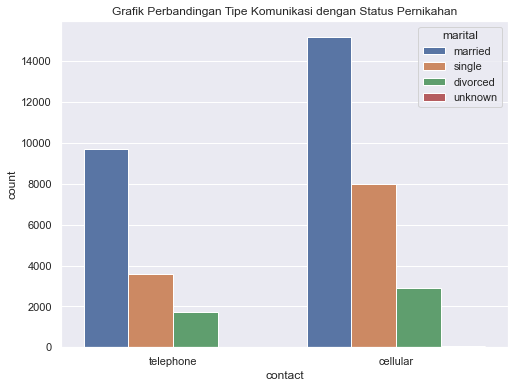

In [349]:
# Visualisasi data Analisis Multivariate antara marital dan contact
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Tipe Komunikasi dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan tipe komunikasi melalui selular dan dominasi kelompok oleh status sudah menikah

In [154]:
# Analisis Multivariate antara marital dan month
(pd.crosstab(index = df['marital'], columns = df['month'], normalize = 'all')*100).round(2)

month      mar   apr    may   jun   jul   aug   sep   oct   nov   dec
marital                                                              
divorced  0.15  0.76   3.61  1.38  2.25  1.39  0.12  0.16  1.34  0.05
married   0.57  3.67  20.67  8.13  9.59  9.74  0.80  0.97  6.10  0.28
single    0.60  1.96   9.07  3.37  5.56  3.85  0.46  0.60  2.50  0.12
unknown   0.01  0.01   0.08  0.03  0.02  0.02  0.00  0.01  0.02  0.00

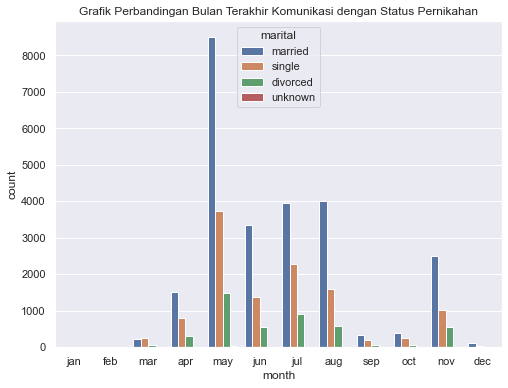

In [351]:
# Visualisasi data Analisis Multivariate antara marital dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang terakhir dihubungi pada bulan Mei dengan dominasi kelompok oleh tipe status sudah menikah

In [155]:
# Analisis Multivariate antara marital dan day_of_week
(pd.crosstab(index = df['marital'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week    mon    tue    wed    thu    fri
marital                                       
divorced      2.39   2.33   2.19   2.22   2.06
married      12.61  11.91  11.87  12.50  11.63
single        5.62   5.37   5.65   6.16   5.28
unknown       0.05   0.03   0.03   0.06   0.03

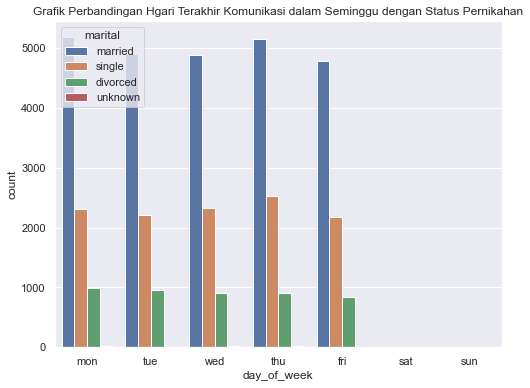

In [352]:
# Visualisasi data Analisis Multivariate antara marital dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Hgari Terakhir Komunikasi dalam Seminggu dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang terakhir dihubungi pada hari Kamis dengan dominasi kelompok oleh status sudah menikah

In [156]:
# Analisis Multivariate antara marital dan duration
(pd.crosstab(index = df['marital'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin   0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
marital                                                         
divorced       10.30         0.87         0.03              0.00
married        55.45         4.93         0.14              0.01
single         25.67         2.34         0.07              0.00
unknown         0.17         0.03         0.00              0.00

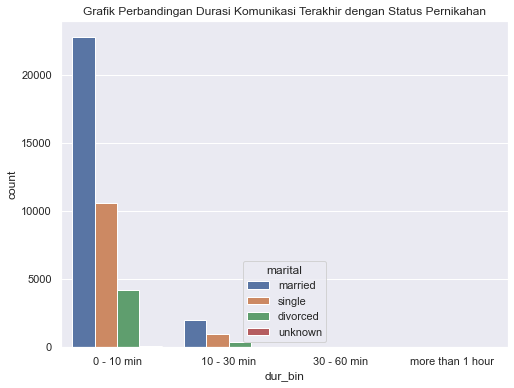

In [353]:
# Visualisasi data Analisis Multivariate antara marital dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Durasi Komunikasi Terakhir dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan lama komunikasi terakhir pada rentang 0 - 10 menit dan dominasi kelompok oleh status sudah menikah

In [157]:
# Analisis Multivariate antara marital dan campaign
(pd.crosstab(index = df['marital'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin   0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
marital                                                               
divorced         10.97           0.19           0.03           0.00   
married          59.22           1.05           0.19           0.05   
single           27.51           0.48           0.08           0.02   
unknown           0.18           0.01           0.00           0.00   

cam_bin   40-50 times  more than 50 times  
marital                                    
divorced         0.00                 0.0  
married          0.01                 0.0  
single           0.00                 0.0  
unknown          0.00                 0.0

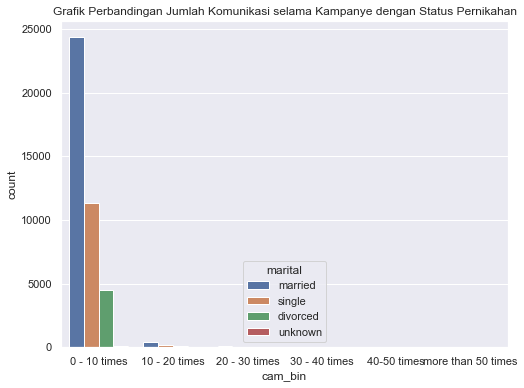

In [354]:
# Visualisasi data Analisis Multivariate antara marital dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Jumlah Komunikasi selama Kampanye dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan jumlah komunikasi selama kampanye sebanyak 0 - 10 kali dan dominasi kelompok oleh status sudah menikah

In [158]:
# Analisis Multivariate antara marital dan pdays
(pd.crosstab(index = df['marital'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin  0 - 10 days  10 - 20 days  20 - 30 days  no contact
marital                                                       
divorced          0.29          0.05          0.00       10.86
married           1.69          0.22          0.01       58.61
single            1.16          0.20          0.01       26.71
unknown           0.01          0.00          0.00        0.18

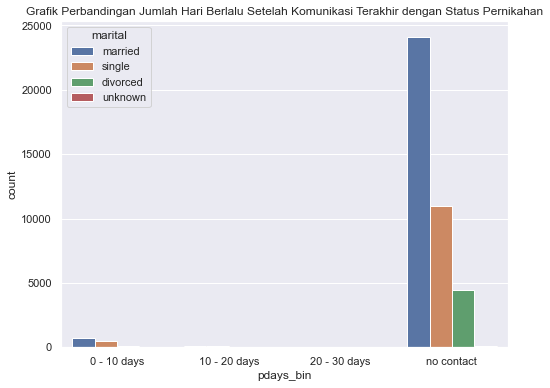

In [356]:
# Visualisasi data Analisis Multivariate antara marital dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu Setelah Komunikasi Terakhir dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa komunikasi selama kampanye dengan dominasi kelompok oleh status sudah menikah

In [159]:
# Analisis Multivariate antara marital dan previuos
(pd.crosstab(index = df['marital'], columns = df['previous'], normalize = 'all')*100).round(2)

previous      0     1     2     3     4     5     6    7
marital                                                 
divorced   9.67  1.29  0.17  0.05  0.01  0.00  0.00  0.0
married   52.98  6.19  0.98  0.25  0.10  0.02  0.01  0.0
single    23.55  3.56  0.67  0.23  0.06  0.02  0.00  0.0
unknown    0.15  0.03  0.01  0.00  0.00  0.00  0.00  0.0

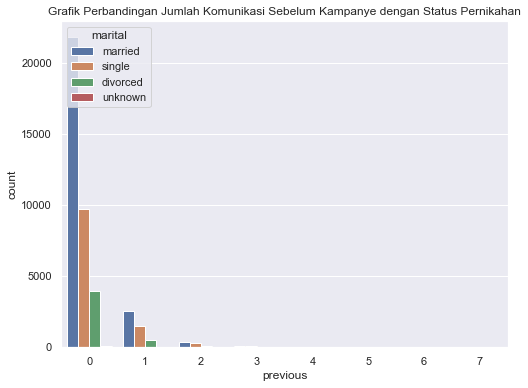

In [357]:
# Visualisasi data Analisis Multivariate antara marital dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Jumlah Komunikasi Sebelum Kampanye dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa komunikasi sebelum kampanye dengan dominasi kelompok oleh status sudah menikah

In [160]:
# Analisis Multivariate antara marital dan poutcome
(pd.crosstab(index = df['marital'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome  failure  nonexistent  success
marital                                
divorced     1.22         9.67     0.31
married      5.79        52.98     1.76
single       3.28        23.55     1.25
unknown      0.03         0.15     0.01

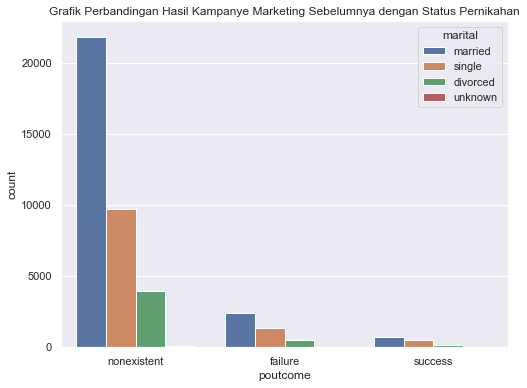

In [358]:
# Visualisasi data Analisis Multivariate antara marital dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Hasil Kampanye Marketing Sebelumnya dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan hasil kampanye marketing sebelumnya berupa tidak ada dan dominasi kelompok oleh status sudah menikah

In [161]:
# Analisis Multivariate antara marital dan emp.var.rate
(pd.crosstab(index = df['marital'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
marital                                                                    
divorced      0.25  0.04  0.32   2.37  0.20  0.16  0.00  1.21   2.14   4.49
married       1.56  0.26  2.08  12.30  0.85  0.76  0.02  5.56  12.61  24.53
single        0.78  0.12  1.62   7.57  0.82  0.62  0.00  2.16   4.05  10.33
unknown       0.00  0.00  0.01   0.06  0.00  0.00  0.00  0.02   0.04   0.06

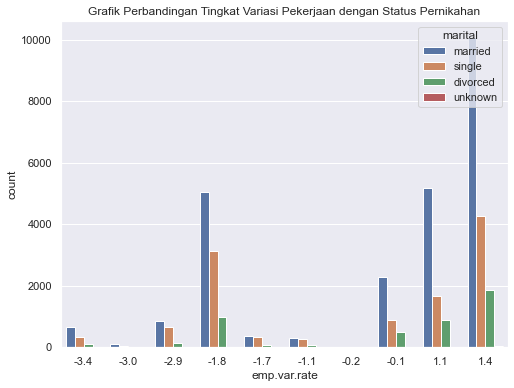

In [359]:
# Visualisasi data Analisis Multivariate antara marital dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan dominasi kelompok oleh status sudah menikah

In [162]:
# Analisis Multivariate antara marital dan cons.price.idx
(pd.crosstab(index = df['marital'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
marital                                                                  
divorced          0.17    0.05    0.09    0.04    0.11    0.04    0.00   
married           1.06    0.44    0.65    0.21    0.47    0.26    0.02   
single            0.63    0.15    0.34    0.18    0.29    0.12    0.00   
unknown           0.01    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
marital                                                                  
divorced          0.07    1.43    0.11    0.69    1.19    0.08    1.15   
married           0.29    7.76    0.81    3.46    5.46    0.27    8.43   
single            0.32    4.84    0.80    1.80    2.11    0.29    2.97   
unknown           0.00    0.04    0.01    0.01    0.02    0.00    0.02   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
marital                                                                  
divorced          0.06    0.02    0.04    2.13    2.14    0.08    0.06   
married           0.21    0.10    0.30    9.04   12.61    0.25    0.26   
single            0.16    0.05    0.17    5.04    4.05    0.24    0.24   
unknown           0.00    0.00    0.00    0.02    0.04    0.00    0.00   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
marital                                                 
divorced          0.07    0.07    1.21    0.05    0.04  
married           0.36    0.34    7.06    0.23    0.17  
single            0.31    0.34    2.32    0.21    0.10  
unknown           0.00    0.00    0.02    0.00    0.00

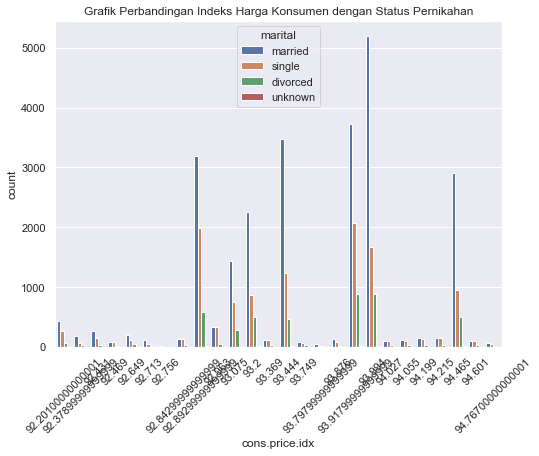

In [361]:
# Visualisasi data Analisis Multivariate antara marital dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Status Pernikahan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan indeks harga konsumen sebesar 93.994 dan kelompok didominasi oleh status sudah menikah

In [163]:
# Analisis Multivariate antara marital dan cons.conf.idx
(pd.crosstab(index = df['marital'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
marital                                                                        
divorced        0.04   0.07   0.05   0.69   1.43   0.00   2.13   1.19   1.21   
married         0.17   0.29   0.23   3.46   7.76   0.02   9.04   5.46   7.06   
single          0.10   0.32   0.21   1.80   4.84   0.00   5.04   2.11   2.32   
unknown         0.00   0.00   0.00   0.01   0.04   0.00   0.02   0.02   0.02   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
marital                                                                        
divorced        0.11   0.02   0.07   0.04   0.06   0.08   0.07   2.14   1.15   
married         0.81   0.10   0.34   0.30   0.26   0.25   0.36  12.61   8.43   
single          0.80   0.05   0.34   0.17   0.24   0.24   0.31   4.05   2.97   
unknown         0.01   0.00   0.00   0.00   0.00   0.00   0.00   0.04   0.02   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
marital                                                                
divorced        0.08   0.06   0.04   0.04   0.17   0.11   0.05   0.09  
married         0.27   0.21   0.21   0.26   1.06   0.47   0.44   0.65  
single          0.29   0.16   0.18   0.12   0.63   0.29   0.15   0.34  
unknown         0.00   0.00   0.00   0.00   0.01   0.00   0.00   0.00

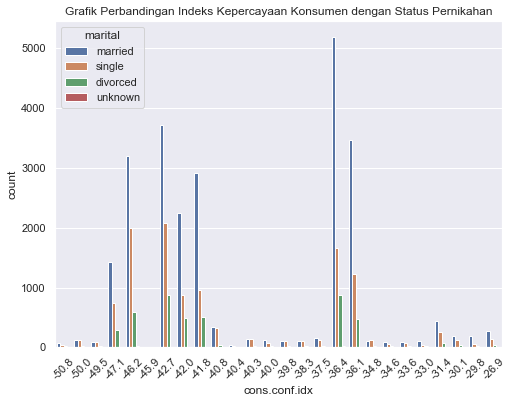

In [363]:
# Visualisasi data Analisis Multivariate antara marital dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Status Pernikahan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok oleh status sudah menikah

In [164]:
# Analisis Multivariate antara marital dan euribor3m
(pd.crosstab(index = df['marital'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin   0 - 1  1 - 2  3 - 4     >4
marital                             
divorced   0.95   2.40   0.00   7.85
married    5.07  12.73   0.02  42.70
single     3.45   8.09   0.01  16.54
unknown    0.02   0.06   0.00   0.11

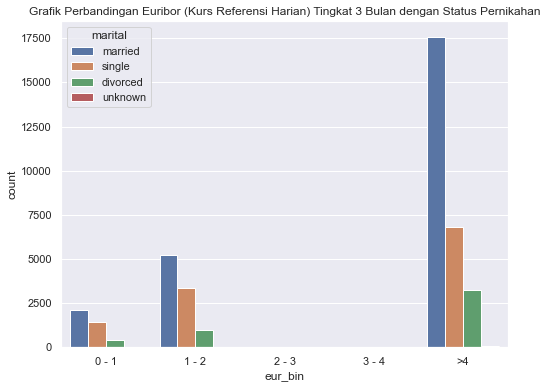

In [364]:
# Visualisasi data Analisis Multivariate antara marital dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan Euribor (Kurs Referensi Harian) lebih besar dari 4 dan dominasi kelompok oleh status sudah menikah

In [165]:
# Analisis Multivariate antara marital dan nr.employed
(pd.crosstab(index = df['marital'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
marital                                                                       
divorced       0.16    0.20    0.17    0.25    0.04    0.32    2.19    0.00   
married        0.76    0.85    0.78    1.56    0.26    2.08   11.52    0.02   
single         0.62    0.82    0.62    0.78    0.12    1.62    6.96    0.00   
unknown        0.00    0.00    0.00    0.00    0.00    0.01    0.05    0.00   

nr.employed  5191.0  5195.8  5228.1  
marital                              
divorced       2.14    1.21    4.49  
married       12.61    5.56   24.53  
single         4.05    2.16   10.33  
unknown        0.04    0.02    0.06

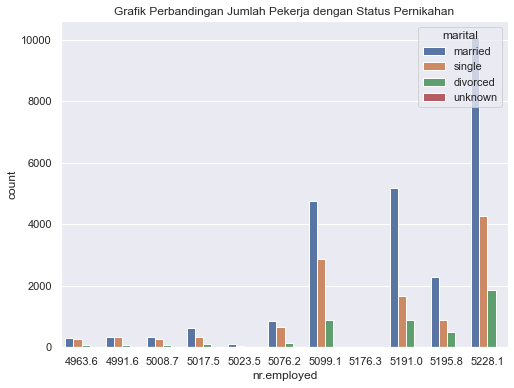

In [365]:
# Visualisasi data Analisis Multivariate antara marital dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'marital')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Status Pernikahan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan jumlah pekerja sebanyak 5228 orang dan dominasi kelompok oleh status sudah menikah

### Analisis Multivariate terhadap Education

In [166]:
# Analisis Multivariate antara education dan default
(pd.crosstab(index = df['education'], columns = df['default'], normalize = 'all')*100).round(2)

default                 no  unknown  yes
education                               
basic 4y              6.01     4.12  0.0
basic 6y              3.50     2.07  0.0
basic 9y             10.73     3.95  0.0
high school          19.19     3.91  0.0
illiterate            0.03     0.02  0.0
professional course  10.77     1.95  0.0
university degree    26.02     3.52  0.0
unknown               2.87     1.33  0.0

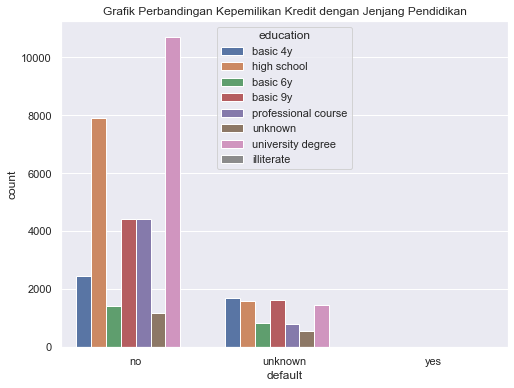

In [366]:
# Visualisasi data Analisis Multivariate antara education dan default
plt.figure(figsize = (8,6))
sns.countplot(x = 'default', data = df , hue = 'education')
plt.title('Grafik Perbandingan Kepemilikan Kredit dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tidak memiliki kredit dengan dominasi kelompok oleh jenjang pendidikan perguruan tinggi (sarjana)

In [167]:
# Analisis Multivariate antara education dan housing
(pd.crosstab(index = df['education'], columns = df['default'], normalize = 'all')*100).round(2)

default                 no  unknown  yes
education                               
basic 4y              6.01     4.12  0.0
basic 6y              3.50     2.07  0.0
basic 9y             10.73     3.95  0.0
high school          19.19     3.91  0.0
illiterate            0.03     0.02  0.0
professional course  10.77     1.95  0.0
university degree    26.02     3.52  0.0
unknown               2.87     1.33  0.0

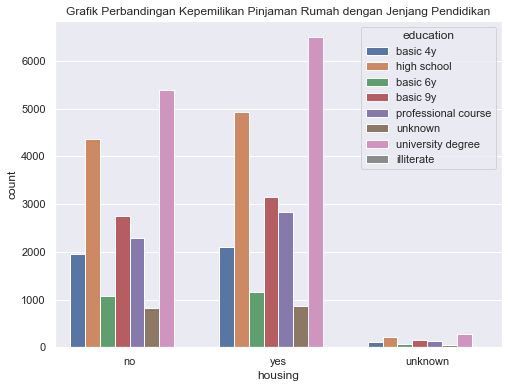

In [367]:
# Visualisasi data Analisis Multivariate antara education dan housing
plt.figure(figsize = (8,6))
sns.countplot(x = 'housing', data = df , hue = 'education')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Rumah dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok yang memiliki pinjaman rumah dengan dominasi kelompok oleh jenjang pendidikan terakhir perguruan tinggi (sarjana)

In [168]:
# Analisis Multivariate antara education dan loan
(pd.crosstab(index = df['education'], columns = df['loan'], normalize = 'all')*100).round(2)

loan                    no  unknown   yes
education                                
basic 4y              8.34     0.28  1.52
basic 6y              4.62     0.15  0.80
basic 9y             12.17     0.37  2.14
high school          19.06     0.53  3.50
illiterate            0.04     0.00  0.01
professional course  10.50     0.30  1.93
university degree    24.18     0.67  4.69
unknown               3.52     0.10  0.59

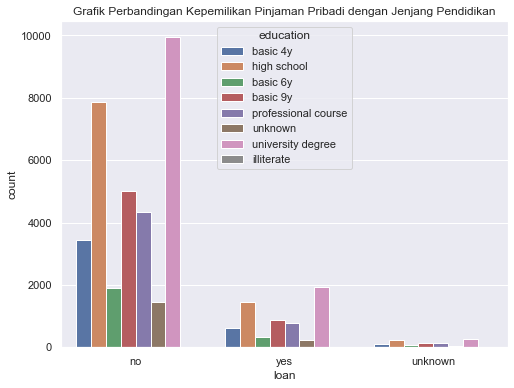

In [368]:
# Visualisasi data Analisis Multivariate antara education dan loan
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'education')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Pribadi dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa pinjaman pribadi dengan dominasi kelompok oleh latar belakang pendidikan perguruan tinggi (sarjana)

In [169]:
# Analisis Multivariate antara education dan contact
(pd.crosstab(index = df['education'], columns = df['contact'], normalize = 'all')*100).round(2)

contact              cellular  telephone
education                               
basic 4y                 5.71       4.43
basic 6y                 3.03       2.54
basic 9y                 8.38       6.30
high school             14.39       8.71
illiterate               0.04       0.01
professional course      8.44       4.29
university degree       21.02       8.52
unknown                  2.47       1.73

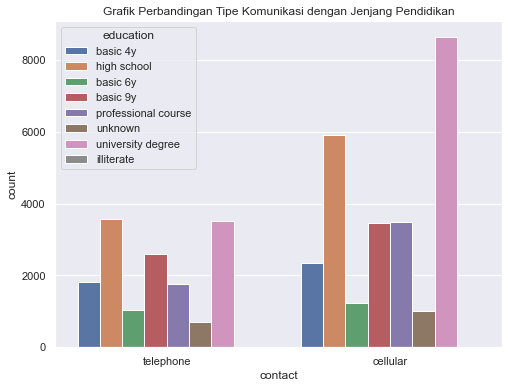

In [369]:
# Visualisasi data Analisis Multivariate antara education dan contact
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'education')
plt.title('Grafik Perbandingan Tipe Komunikasi dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi tipe komunikasi seluler dengan dominasi kelompok oleh jenjang pendidikan terakhir perguruan tinggi (sarjana)

In [170]:
# Analisis Multivariate antara education dan month
(pd.crosstab(index = df['education'], columns = df['month'], normalize = 'all')*100).round(2)

month                 mar   apr   may   jun   jul   aug   sep   oct   nov  \
education                                                                   
basic 4y             0.12  0.65  3.69  1.52  1.81  1.24  0.13  0.23  0.71   
basic 6y             0.03  0.31  2.52  0.82  1.07  0.34  0.04  0.05  0.39   
basic 9y             0.10  0.92  6.40  2.03  2.83  0.90  0.06  0.12  1.27   
high school          0.22  1.50  8.53  3.04  4.52  2.36  0.26  0.41  2.17   
illiterate           0.00  0.00  0.01  0.00  0.01  0.01  0.00  0.00  0.01   
professional course  0.20  0.76  3.72  1.53  1.95  2.78  0.22  0.25  1.27   
university degree    0.57  1.93  7.28  3.35  4.33  6.89  0.55  0.62  3.85   
unknown              0.08  0.31  1.29  0.62  0.91  0.47  0.12  0.08  0.29   

month                 dec  
education                  
basic 4y             0.05  
basic 6y             0.00  
basic 9y             0.04  
high school          0.10  
illiterate           0.00  
professional course  0.05  
university degree    0.17  
unknown              0.03

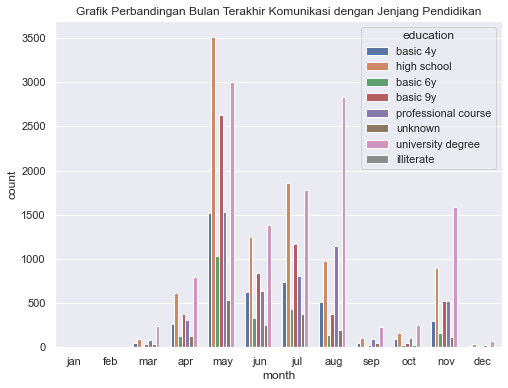

In [370]:
# Visualisasi data Analisis Multivariate antara education dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'education')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan bulan terakhir komunikasi Mei dan kelompok didominasi oleh jenjang terakhir pendidikan perguruan tinggi (sarjana)

In [171]:
# Analisis Multivariate antara education dan day_of_week
(pd.crosstab(index = df['education'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week           mon   tue   wed   thu   fri
education                                        
basic 4y             2.04  2.19  2.03  2.09  1.79
basic 6y             1.03  1.12  1.21  1.18  1.02
basic 9y             3.02  2.70  3.08  3.00  2.88
high school          4.95  4.55  4.61  4.50  4.50
illiterate           0.00  0.01  0.00  0.01  0.01
professional course  2.56  2.62  2.39  2.81  2.35
university degree    6.24  5.60  5.73  6.45  5.51
unknown              0.84  0.84  0.70  0.89  0.93

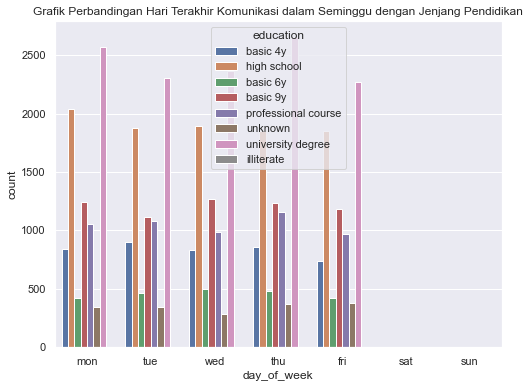

In [371]:
# Visualisasi data Analisis Multivariate antara education dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'education')
plt.title('Grafik Perbandingan Hari Terakhir Komunikasi dalam Seminggu dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok yang terakhir dihubungi pada hari Kamis dengan dominasi kelompok oleh jenjang pendidikan terakhir perguruan tinggi (sarjana)

In [172]:
# Analisis Multivariate antara education dan duration
(pd.crosstab(index = df['education'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin              0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
education                                                                  
basic 4y                   9.31         0.80         0.02              0.00
basic 6y                   5.05         0.49         0.02              0.00
basic 9y                  13.43         1.21         0.03              0.00
high school               21.12         1.93         0.05              0.00
illiterate                 0.04         0.00         0.00              0.00
professional course       11.72         0.98         0.03              0.01
university degree         27.09         2.39         0.07              0.00
unknown                    3.84         0.36         0.00              0.00

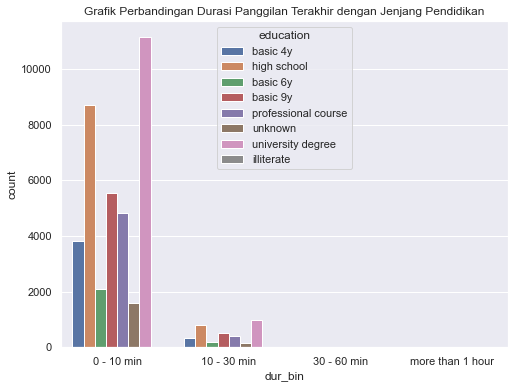

In [372]:
# Visualisasi data Analisis Multivariate antara education dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'education')
plt.title('Grafik Perbandingan Durasi Panggilan Terakhir dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan durasi panggilan terakhir berkisar 0 - 10 menit dan kelompok didominasi oleh jenjang pendidikan terakhir perguruan tinggi (sarjana)

In [173]:
# Analisis Multivariate antara education dan campaign
(pd.crosstab(index = df['education'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin              0 - 10 times  10 - 20 times  20 - 30 times  \
education                                                         
basic 4y                     9.91           0.16           0.06   
basic 6y                     5.47           0.08           0.01   
basic 9y                    14.40           0.21           0.05   
high school                 22.58           0.43           0.07   
illiterate                   0.04           0.00           0.00   
professional course         12.48           0.21           0.03   
university degree           28.91           0.54           0.07   
unknown                      4.09           0.09           0.01   

cam_bin              30 - 40 times  40-50 times  more than 50 times  
education                                                            
basic 4y                      0.00          0.0                 0.0  
basic 6y                      0.00          0.0                 0.0  
basic 9y                      0.01          0.0                 0.0  
high school                   0.02          0.0                 0.0  
illiterate                    0.00          0.0                 0.0  
professional course           0.01          0.0                 0.0  
university degree             0.02          0.0                 0.0  
unknown                       0.00          0.0                 0.0

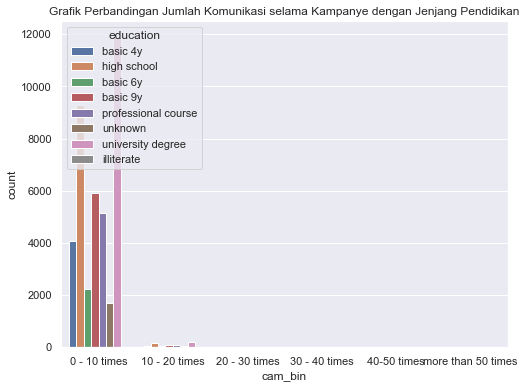

In [373]:
# Visualisasi data Analisis Multivariate antara education dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'education')
plt.title('Grafik Perbandingan Jumlah Komunikasi selama Kampanye dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan banyak panggilan selama kampanye sebenayak 0 - 10 kali dan dominasi kelompok dengan latar belakang pendidikan perguruan tinggi (sarjana)

In [174]:
# Analisis Multivariate antara education dan pdays
(pd.crosstab(index = df['education'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin            0 - 10 days  10 - 20 days  20 - 30 days  no contact
education                                                               
basic 4y                    0.30          0.04          0.00        9.80
basic 6y                    0.08          0.02          0.00        5.46
basic 9y                    0.25          0.04          0.00       14.39
high school                 0.68          0.11          0.00       22.30
illiterate                  0.00          0.00          0.00        0.04
professional course         0.41          0.07          0.01       12.24
university degree           1.23          0.15          0.00       28.15
unknown                     0.20          0.04          0.00        3.97

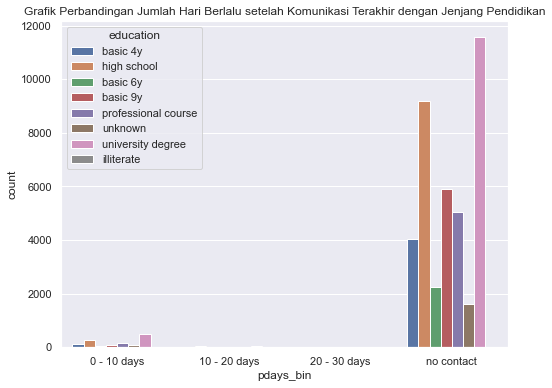

In [374]:
# Visualisasi data Analisis Multivariate antara education dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'education')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu setelah Komunikasi Terakhir dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi dengan tim kampanye dengan dominasi kelompok oleh jenjang pendidikan perguruan tinggi (sarjana)

In [175]:
# Analisis Multivariate antara education dan previous
(pd.crosstab(index = df['education'], columns = df['previous'], normalize = 'all')*100).round(2)

previous                 0     1     2     3     4     5     6    7
education                                                          
basic 4y              8.97  0.92  0.18  0.05  0.02  0.00  0.00  0.0
basic 6y              4.94  0.55  0.06  0.01  0.00  0.00  0.00  0.0
basic 9y             12.88  1.58  0.17  0.04  0.01  0.00  0.00  0.0
high school          19.67  2.80  0.45  0.13  0.03  0.01  0.00  0.0
illiterate            0.04  0.00  0.00  0.00  0.00  0.00  0.00  0.0
professional course  11.06  1.38  0.20  0.05  0.03  0.01  0.00  0.0
university degree    25.23  3.37  0.64  0.22  0.06  0.02  0.01  0.0
unknown               3.55  0.46  0.13  0.03  0.02  0.00  0.00  0.0

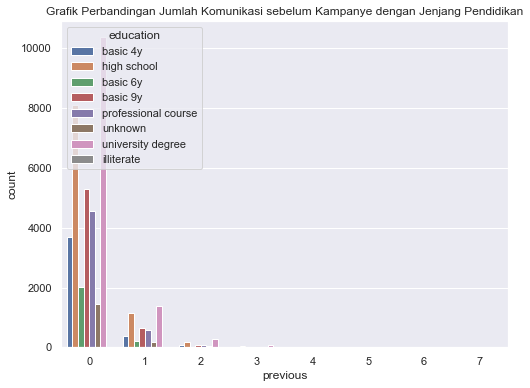

In [375]:
# Visualisasi data Analisis Multivariate antara education dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'education')
plt.title('Grafik Perbandingan Jumlah Komunikasi sebelum Kampanye dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelumnya dengan tim kampanye dengan dominasi kelompok berlatar belakang pendidikan perguruan tinggi (sarjana)

In [176]:
# Analisis Multivariate antara education dan poutcome
(pd.crosstab(index = df['education'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome             failure  nonexistent  success
education                                         
basic 4y                0.86         8.97     0.31
basic 6y                0.53         4.94     0.10
basic 9y                1.53        12.88     0.27
high school             2.72        19.67     0.71
illiterate              0.00         0.04     0.00
professional course     1.22        11.06     0.44
university degree       3.02        25.23     1.29
unknown                 0.45         3.55     0.21

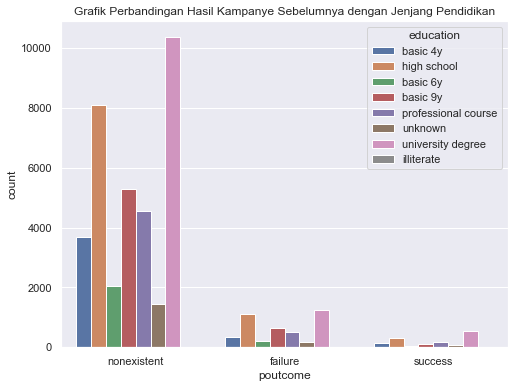

In [376]:
# Visualisasi data Analisis Multivariate antara education dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'education')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan hasil kampanye sebelumnya tidak ada dan kelompok didominasi oleh latar belakang pendidikan perguruan tinggi (sarjana)

In [177]:
# Analisis Multivariate antara education dan emp.var.rate
(pd.crosstab(index = df['education'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate         -3.4  -3.0  -2.9  -1.8  -1.7  -1.1  -0.2  -0.1   1.1  \
education                                                                   
basic 4y             0.34  0.04  0.26  2.05  0.18  0.14  0.01  0.58  2.41   
basic 6y             0.09  0.00  0.08  1.42  0.04  0.02  0.00  0.37  1.44   
basic 9y             0.17  0.04  0.27  3.95  0.13  0.07  0.00  1.22  3.47   
high school          0.52  0.09  0.87  5.74  0.44  0.35  0.01  1.96  4.51   
illiterate           0.00  0.00  0.01  0.01  0.00  0.00  0.00  0.01  0.00   
professional course  0.32  0.05  0.48  2.53  0.23  0.27  0.01  1.14  2.15   
university degree    1.00  0.17  1.84  5.83  0.73  0.59  0.00  3.43  3.95   
unknown              0.16  0.03  0.24  0.77  0.12  0.10  0.00  0.22  0.92   

emp.var.rate           1.4  
education                   
basic 4y              4.13  
basic 6y              2.10  
basic 9y              5.37  
high school           8.60  
illiterate            0.02  
professional course   5.56  
university degree    12.00  
unknown               1.64

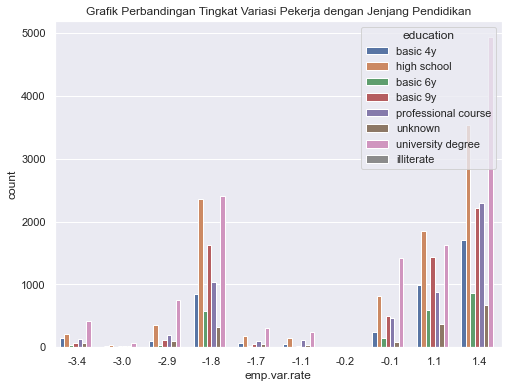

In [377]:
# Visualisasi data Analisis Multivariate antara education dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'education')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerja dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan tingkat variasi pekerja sebesar 1.4 dengan dominasi kelompok berlatar belakang pendidikan perguruan tinggi (sarjana)

In [178]:
# Analisis Multivariate antara education dan cons.price.idx
(pd.crosstab(index = df['education'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx       92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
education                                                                     
basic 4y               0.15    0.07    0.15    0.02    0.12    0.04    0.01   
basic 6y               0.04    0.03    0.05    0.01    0.01    0.00    0.00   
basic 9y               0.12    0.03    0.09    0.01    0.05    0.04    0.00   
high school            0.41    0.11    0.22    0.12    0.19    0.09    0.01   
illiterate             0.01    0.00    0.00    0.00    0.00    0.00    0.00   
professional course    0.22    0.08    0.14    0.03    0.09    0.05    0.01   
university degree      0.80    0.26    0.39    0.21    0.35    0.17    0.00   
unknown                0.12    0.07    0.05    0.04    0.05    0.03    0.00   

cons.price.idx       92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
education                                                                     
basic 4y               0.08    1.24    0.09    0.56    0.57    0.04    1.04   
basic 6y               0.02    1.07    0.04    0.31    0.37    0.01    0.30   
basic 9y               0.06    2.88    0.14    0.90    1.21    0.04    0.74   
high school            0.11    3.90    0.34    1.42    1.91    0.11    1.84   
illiterate             0.00    0.00    0.00    0.00    0.01    0.00    0.00   
professional course    0.10    1.49    0.22    0.71    1.12    0.10    2.50   
university degree      0.30    3.14    0.84    1.79    3.37    0.27    5.85   
unknown                0.01    0.33    0.08    0.26    0.21    0.07    0.30   

cons.price.idx       93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
education                                                                     
basic 4y               0.08    0.00    0.03    1.70    2.41    0.05    0.04   
basic 6y               0.00    0.00    0.01    1.04    1.44    0.00    0.02   
basic 9y               0.02    0.01    0.04    2.76    3.47    0.05    0.02   
high school            0.08    0.05    0.12    4.22    4.51    0.11    0.16   
illiterate             0.00    0.00    0.00    0.01    0.00    0.00    0.00   
professional course    0.05    0.02    0.07    1.82    2.15    0.06    0.07   
university degree      0.14    0.06    0.19    3.86    3.95    0.24    0.23   
unknown                0.05    0.01    0.05    0.82    0.92    0.05    0.02   

cons.price.idx       94.199  94.215  94.465  94.601  94.767  
education                                                    
basic 4y               0.06    0.09    1.39    0.07    0.02  
basic 6y               0.01    0.02    0.76    0.00    0.01  
basic 9y               0.03    0.06    1.87    0.02    0.01  
high school            0.15    0.18    2.55    0.14    0.07  
illiterate             0.00    0.00    0.00    0.00    0.00  
professional course    0.14    0.09    1.24    0.08    0.06  
university degree      0.30    0.27    2.29    0.17    0.12  
unknown                0.06    0.05    0.52    0.02    0.03

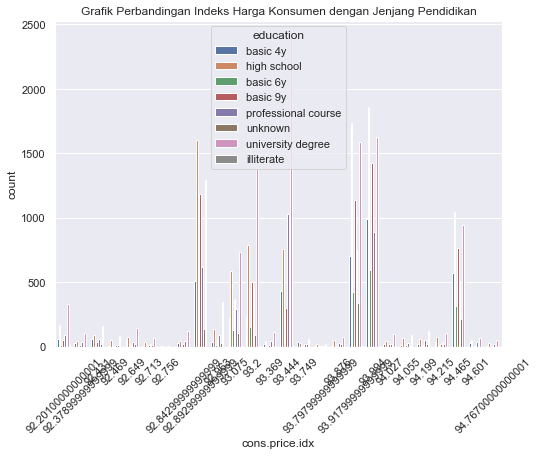

In [379]:
# Visualisasi data Analisis Multivariate antara education dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'education')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Jenjang Pendidikan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.444 dan kelompok didominasi oleh latar belakang pendidikan perguruan tinggi (sarjana)

In [179]:
# Analisis Multivariate antara education dan cons.conf.idx
(pd.crosstab(index = df['education'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx        -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  \
education                                                                     
basic 4y              0.02   0.08   0.07   0.56   1.24   0.01   1.70   0.57   
basic 6y              0.01   0.02   0.00   0.31   1.07   0.00   1.04   0.37   
basic 9y              0.01   0.06   0.02   0.90   2.88   0.00   2.76   1.21   
high school           0.07   0.11   0.14   1.42   3.90   0.01   4.22   1.91   
illiterate            0.00   0.00   0.00   0.00   0.00   0.00   0.01   0.01   
professional course   0.06   0.10   0.08   0.71   1.49   0.01   1.82   1.12   
university degree     0.12   0.30   0.17   1.79   3.14   0.00   3.86   3.37   
unknown               0.03   0.01   0.02   0.26   0.33   0.00   0.82   0.21   

cons.conf.idx        -41.8  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  \
education                                                                     
basic 4y              1.39   0.09   0.00   0.09   0.03   0.04   0.05   0.06   
basic 6y              0.76   0.04   0.00   0.02   0.01   0.02   0.00   0.01   
basic 9y              1.87   0.14   0.01   0.06   0.04   0.02   0.05   0.03   
high school           2.55   0.34   0.05   0.18   0.12   0.16   0.11   0.15   
illiterate            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
professional course   1.24   0.22   0.02   0.09   0.07   0.07   0.06   0.14   
university degree     2.29   0.84   0.06   0.27   0.19   0.23   0.24   0.30   
unknown               0.52   0.08   0.01   0.05   0.05   0.02   0.05   0.06   

cons.conf.idx        -36.4  -36.1  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  \
education                                                                     
basic 4y              2.41   1.04   0.04   0.08   0.02   0.04   0.15   0.12   
basic 6y              1.44   0.30   0.01   0.00   0.01   0.00   0.04   0.01   
basic 9y              3.47   0.74   0.04   0.02   0.01   0.04   0.12   0.05   
high school           4.51   1.84   0.11   0.08   0.12   0.09   0.41   0.19   
illiterate            0.00   0.00   0.00   0.00   0.00   0.00   0.01   0.00   
professional course   2.15   2.50   0.10   0.05   0.03   0.05   0.22   0.09   
university degree     3.95   5.85   0.27   0.14   0.21   0.17   0.80   0.35   
unknown               0.92   0.30   0.07   0.05   0.04   0.03   0.12   0.05   

cons.conf.idx        -29.8  -26.9  
education                          
basic 4y              0.07   0.15  
basic 6y              0.03   0.05  
basic 9y              0.03   0.09  
high school           0.11   0.22  
illiterate            0.00   0.00  
professional course   0.08   0.14  
university degree     0.26   0.39  
unknown               0.07   0.05

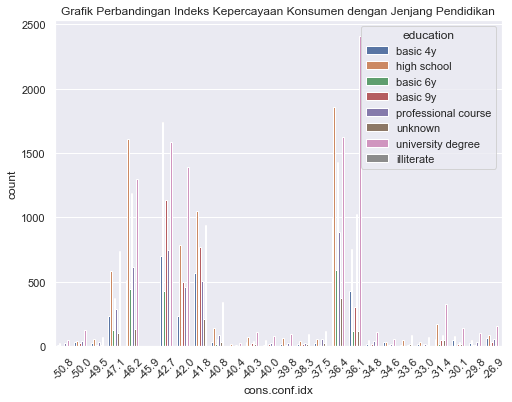

In [381]:
# Visualisasi data Analisis Multivariate antara education dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'education')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Jenjang Pendidikan')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.1 dan dominasi kelompok oleh latar belakang pendidikan perguruan tinggi (sarjana)

In [180]:
# Analisis Multivariate antara education dan euribor3m
(pd.crosstab(index = df['education'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin              0 - 1  1 - 2  3 - 4     >4
education                                      
basic 4y              0.99   2.02   0.01   7.12
basic 6y              0.20   1.45   0.00   3.91
basic 9y              0.61   4.01   0.00  10.06
high school           2.01   6.00   0.01  15.07
illiterate            0.01   0.01   0.00   0.03
professional course   1.23   2.64   0.01   8.85
university degree     3.75   6.41   0.00  19.38
unknown               0.69   0.73   0.00   2.78

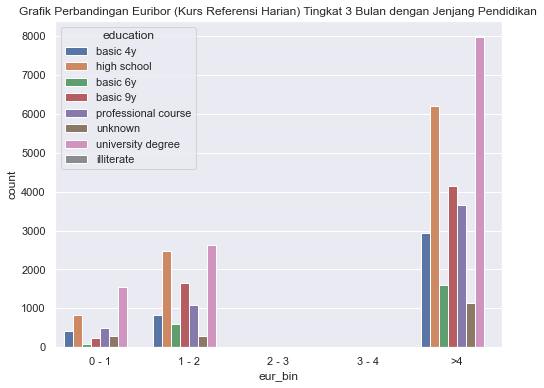

In [382]:
# Visualisasi data Analisis Multivariate antara education dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'education')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor (kurs referensi harian) lebih besar dari 4 dan kelompok didominasi oleh latar belakang pendidikan perguruan tinggi (sarjana)

In [181]:
# Analisis Multivariate antara education dan nr.employed
(pd.crosstab(index = df['education'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed          4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  \
education                                                                     
basic 4y               0.14    0.18    0.16    0.34    0.04    0.26    1.88   
basic 6y               0.02    0.04    0.01    0.09    0.00    0.08    1.40   
basic 9y               0.07    0.13    0.10    0.17    0.04    0.27    3.85   
high school            0.35    0.44    0.31    0.52    0.09    0.87    5.43   
illiterate             0.00    0.00    0.00    0.00    0.00    0.01    0.01   
professional course    0.27    0.23    0.22    0.32    0.05    0.48    2.31   
university degree      0.59    0.73    0.59    1.00    0.17    1.84    5.24   
unknown                0.10    0.12    0.17    0.16    0.03    0.24    0.60   

nr.employed          5176.3  5191.0  5195.8  5228.1  
education                                            
basic 4y               0.01    2.41    0.58    4.13  
basic 6y               0.00    1.44    0.37    2.10  
basic 9y               0.00    3.47    1.22    5.37  
high school            0.01    4.51    1.96    8.60  
illiterate             0.00    0.00    0.01    0.02  
professional course    0.01    2.15    1.14    5.56  
university degree      0.00    3.95    3.43   12.00  
unknown                0.00    0.92    0.22    1.64

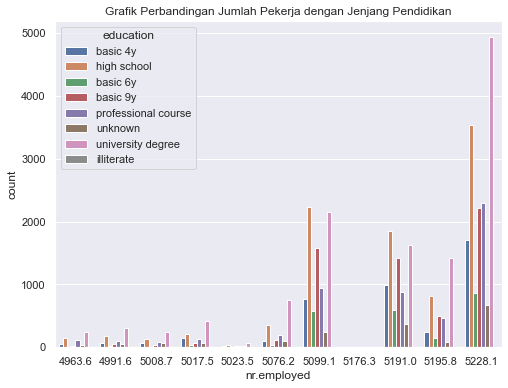

In [383]:
# Visualisasi data Analisis Multivariate antara education dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'education')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Jenjang Pendidikan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanyak 5228 orang dan kelompok didominasi oleh latar belakang pendidikan perguruan tinggi (sarjana)

### Analisis Multivariate terhadap Default

In [182]:
# Analisis Multivariate antara default dan housing
(pd.crosstab(index = df['default'], columns = df['housing'], normalize = 'all')*100).round(2)

housing     no  unknown    yes
default                       
no       35.48     1.85  41.79
unknown   9.73     0.55  10.60
yes       0.00     0.00   0.00

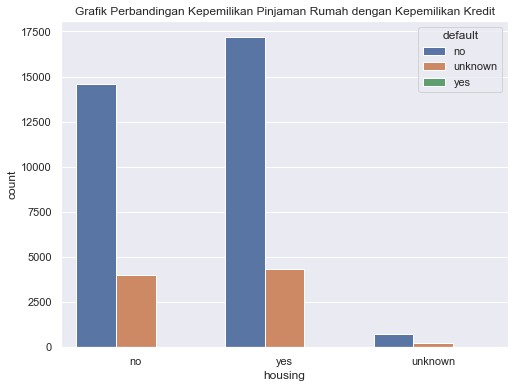

In [429]:
# Visualisasi data Analisis Multivariate antara default dan housing
plt.figure(figsize = (8,6))
sns.countplot(x = 'housing', data = df , hue = 'default')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Rumah dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa pinjaman rumah dengan dominasi kelompok tidak memiilki kredit

In [183]:
# Analisis Multivariate antara default dan loan
(pd.crosstab(index = df['default'], columns = df['loan'], normalize = 'all')*100).round(2)

loan        no  unknown    yes
default                       
no       65.19     1.85  12.08
unknown  17.23     0.55   3.09
yes       0.01     0.00   0.00

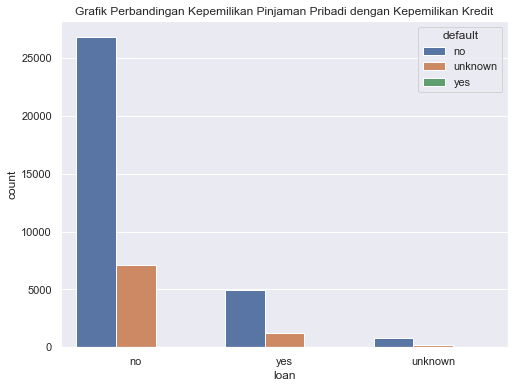

In [430]:
# Visualisasi data Analisis Multivariate antara default dan loan
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'default')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Pribadi dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa kepemilikan pinjaman pribadi dan dominasi kelompok tidak memiliki kredit

In [184]:
# Analisis Multivariate antara default dan contact
(pd.crosstab(index = df['default'], columns = df['contact'], normalize = 'all')*100).round(2)

contact  cellular  telephone
default                     
no          52.87      26.25
unknown     10.60      10.28
yes          0.01       0.00

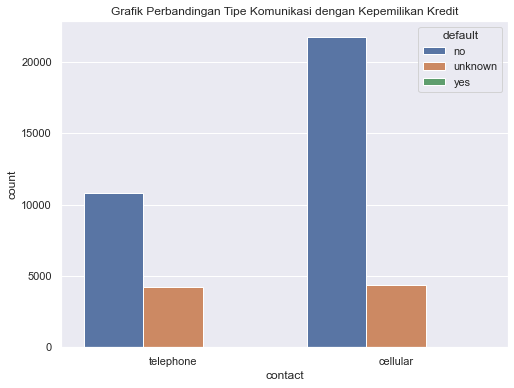

In [431]:
# Visualisasi data Analisis Multivariate antara default dan contact
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'default')
plt.title('Grafik Perbandingan Tipe Komunikasi dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tipe komunikasi menggunakan seluler dan kelompok didominasi oleh kelompok tanpa kepemilikan kredit

In [185]:
# Analisis Multivariate antara default dan month
(pd.crosstab(index = df['default'], columns = df['month'], normalize = 'all')*100).round(2)

month     mar   apr    may   jun    jul    aug   sep   oct   nov   dec
default                                                               
no       1.29  5.54  25.16  9.53  13.20  11.99  1.35  1.70  8.92  0.43
unknown  0.04  0.85   8.27  3.38   4.22   3.00  0.03  0.04  1.03  0.01
yes      0.00  0.00   0.00  0.00   0.00   0.00  0.00  0.00  0.00  0.00

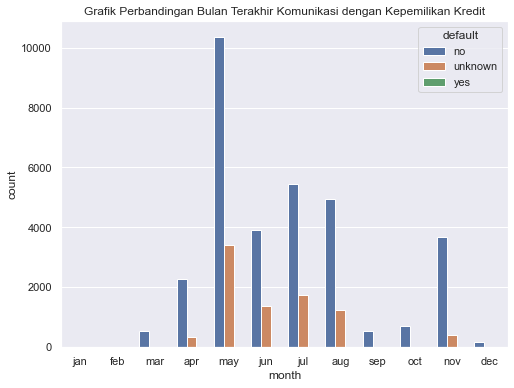

In [432]:
# Visualisasi data Analisis Multivariate antara default dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'default')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan bulan terakhir komunikasi Mei dan kelompok didominasi oleh status tanpa kepemilikan kredit

In [186]:
# Analisis Multivariate antara default dan day_of_week
(pd.crosstab(index = df['default'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week    mon    tue    wed    thu    fri
default                                       
no           16.24  15.49  15.78  16.65  14.97
unknown       4.43   4.15   3.97   4.29   4.03
yes           0.00   0.01   0.00   0.00   0.00

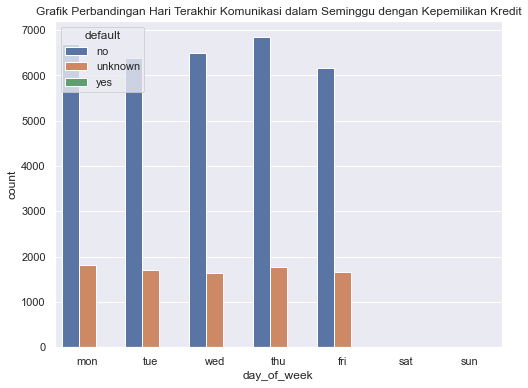

In [433]:
# Visualisasi data Analisis Multivariate antara default dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'default')
plt.title('Grafik Perbandingan Hari Terakhir Komunikasi dalam Seminggu dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan hari terakhir komunikasi pada hari Kamis dan dominasi kelompok tanpa kepemilikan kredit

In [187]:
# Analisis Multivariate antara default dan duration
(pd.crosstab(index = df['default'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin  0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
default                                                        
no            72.39         6.53         0.19              0.01
unknown       19.19         1.64         0.04              0.00
yes            0.01         0.00         0.00              0.00

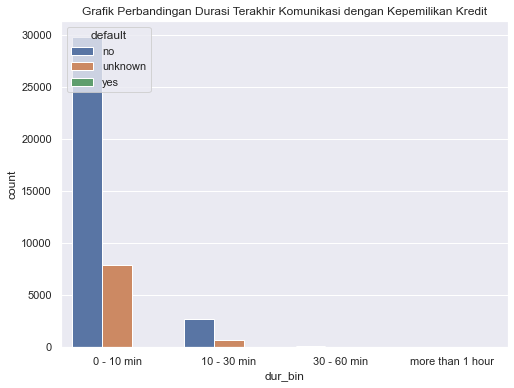

In [434]:
# Visualisasi data Analisis Multivariate antara default dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'default')
plt.title('Grafik Perbandingan Durasi Terakhir Komunikasi dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan durasi panggilan terakhir pada rentang 0 - 10 menit dan dominasi kelompok tidak memiliki kredit

In [188]:
# Analisis Multivariate antara default dan campaign
(pd.crosstab(index = df['default'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin  0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
default                                                              
no              77.58           1.25           0.23           0.05   
unknown         20.30           0.48           0.07           0.01   
yes              0.01           0.00           0.00           0.00   

cam_bin  40-50 times  more than 50 times  
default                                   
no              0.01                 0.0  
unknown         0.00                 0.0  
yes             0.00                 0.0

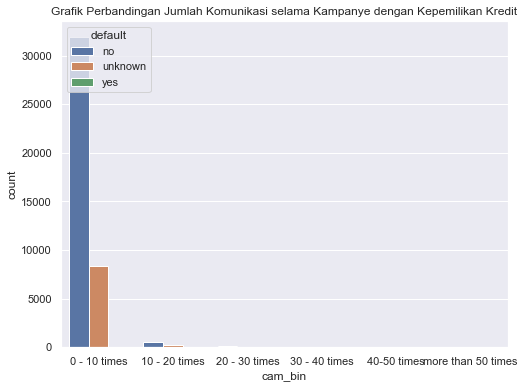

In [435]:
# Visualisasi data Analisis Multivariate antara default dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'default')
plt.title('Grafik Perbandingan Jumlah Komunikasi selama Kampanye dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah komunikasi selama kampanye sebanyak 0 - 10 kali dengan dominasi kelompok tanpa kepemilikan kredit

In [189]:
# Analisis Multivariate antara default dan pdays
(pd.crosstab(index = df['default'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin  0 - 10 days  10 - 20 days  20 - 30 days  no contact
default                                                       
no                3.01          0.46          0.02       75.62
unknown           0.14          0.01          0.00       20.72
yes               0.00          0.00          0.00        0.01

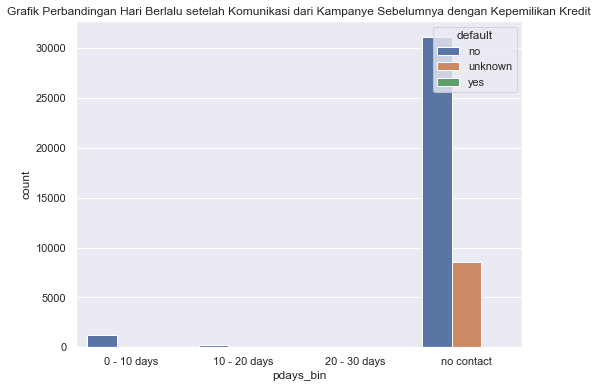

In [436]:
# Visualisasi data Analisis Multivariate antara default dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'default')
plt.title('Grafik Perbandingan Hari Berlalu setelah Komunikasi dari Kampanye Sebelumnya dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi dari kampanye sebelumnya dengan dominasi kelompok tanpa kepemilikan kredit

In [190]:
# Analisis Multivariate antara default dan previous
(pd.crosstab(index = df['default'], columns = df['previous'], normalize = 'all')*100).round(2)

previous      0     1     2     3     4     5     6    7
default                                                 
no        66.86  9.80  1.72  0.51  0.17  0.04  0.01  0.0
unknown   19.48  1.27  0.11  0.01  0.00  0.00  0.00  0.0
yes        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0

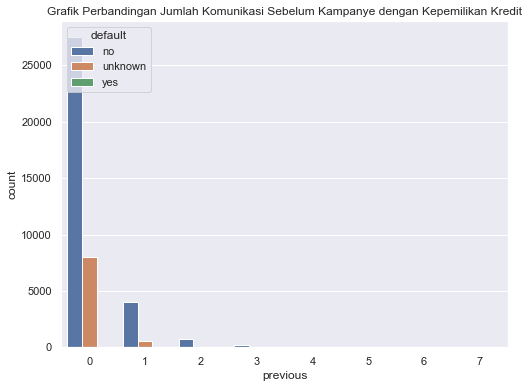

In [437]:
# Visualisasi data Analisis Multivariate antara default dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'default')
plt.title('Grafik Perbandingan Jumlah Komunikasi Sebelum Kampanye dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelum kampanye dengan dominasi kelompok tanpa kepemilikan kredit

In [191]:
# Analisis Multivariate antara default dan poutcome
(pd.crosstab(index = df['default'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome  failure  nonexistent  success
default                                
no           9.07        66.86     3.19
unknown      1.25        19.48     0.14
yes          0.00         0.00     0.00

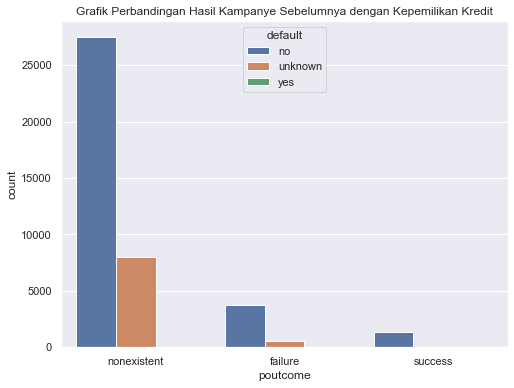

In [438]:
# Visualisasi data Analisis Multivariate antara default dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'default')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil kampanye sebelumnya tidak ada dan kelompok didominasi oleh kelompok tanpa kepemilikan kredit

In [192]:
# Analisis Multivariate antara default dan emp.var.rate
(pd.crosstab(index = df['default'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9  -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
default                                                                   
no            2.55  0.40  3.93  19.1  1.84  1.51  0.02  7.92  12.89  28.96
unknown       0.05  0.01  0.11   3.2  0.04  0.03  0.00  1.02   5.96  10.45
yes           0.00  0.00  0.00   0.0  0.00  0.00  0.00  0.00   0.00   0.00

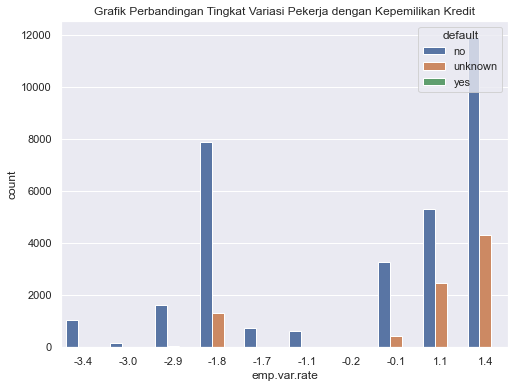

In [439]:
# Visualisasi data Analisis Multivariate antara default dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'default')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerja dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerja sebesar 1.4 dan kelompok didominasi oleh status tanpa kepemilikan kredit

In [193]:
# Analisis Multivariate antara default dan cons.price.idx
(pd.crosstab(index = df['default'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
default                                                                  
no                1.81    0.64    1.05    0.42    0.86    0.40    0.02   
unknown           0.06    0.01    0.03    0.01    0.01    0.01    0.00   
yes               0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
default                                                                  
no                0.66   11.77    1.69    5.13    7.75    0.62    9.63   
unknown           0.02    2.30    0.04    0.84    1.02    0.02    2.93   
yes               0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
default                                                                  
no                0.41    0.16    0.51   12.03   12.89    0.55    0.54   
unknown           0.01    0.00    0.01    4.20    5.96    0.01    0.02   
yes               0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
default                                                 
no                0.72    0.75    7.30    0.48    0.31  
unknown           0.02    0.01    3.32    0.01    0.00  
yes               0.00    0.00    0.00    0.00    0.00

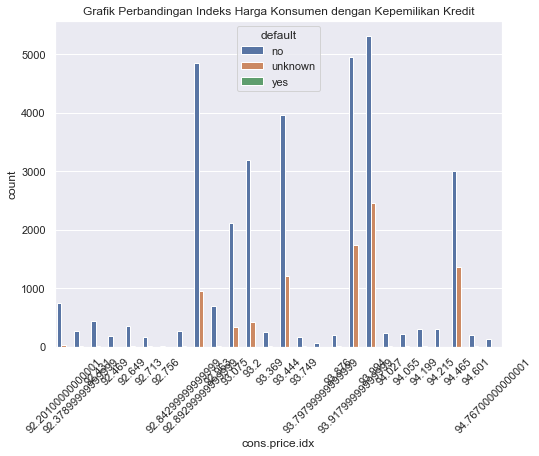

In [440]:
# Visualisasi data Analisis Multivariate antara default dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'default')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Kepemilikan Kredit')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan kelompok didominasi oleh status tanpa kepemilikan kredit

In [194]:
# Analisis Multivariate antara default dan cons.conf.idx
(pd.crosstab(index = df['default'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
default                                                                        
no              0.31   0.66   0.48   5.13  11.77   0.02  12.03   7.75   7.30   
unknown         0.00   0.02   0.01   0.84   2.30   0.00   4.20   1.02   3.32   
yes             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
default                                                                        
no              1.69   0.16   0.75   0.51   0.54   0.55   0.72  12.89   9.63   
unknown         0.04   0.00   0.01   0.01   0.02   0.01   0.02   5.96   2.93   
yes             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
default                                                                
no              0.62   0.41   0.42   0.40   1.81   0.86   0.64   1.05  
unknown         0.02   0.01   0.01   0.01   0.06   0.01   0.01   0.03  
yes             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

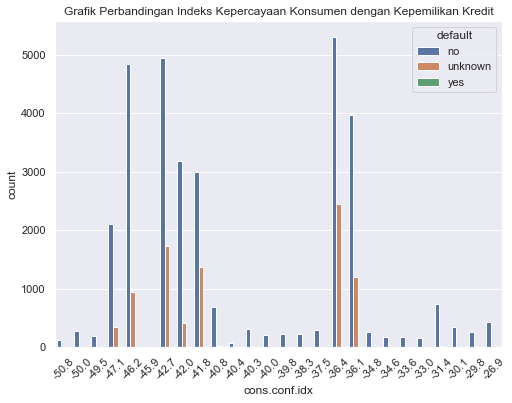

In [441]:
# Visualisasi data Analisis Multivariate antara default dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'default')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Kepemilikan Kredit')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan kelompok didominasi oleh status tanpa kepemilikan kredit

In [195]:
# Analisis Multivariate antara default dan euribor3m
(pd.crosstab(index = df['default'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin  0 - 1  1 - 2  3 - 4     >4
default                            
no        9.25  20.08   0.03  49.76
unknown   0.24   3.21   0.00  17.43
yes       0.00   0.00   0.00   0.01

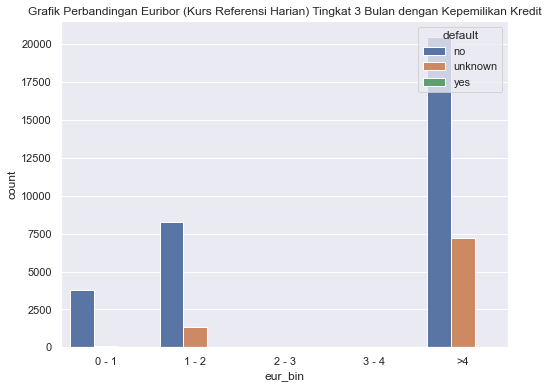

In [442]:
# Visualisasi data Analisis Multivariate antara default dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'default')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan euribor (kurs referensi harian) lebih besar dari 4 dan kelompok didominasi status tanpa kepemilikan kredit

In [196]:
# Analisis Multivariate antara default dan nr.employed
(pd.crosstab(index = df['default'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
default                                                                       
no             1.51    1.84    1.54    2.55    0.40    3.93   17.56    0.02   
unknown        0.03    0.04    0.04    0.05    0.01    0.11    3.16    0.00   
yes            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

nr.employed  5191.0  5195.8  5228.1  
default                              
no            12.89    7.92   28.96  
unknown        5.96    1.02   10.45  
yes            0.00    0.00    0.00

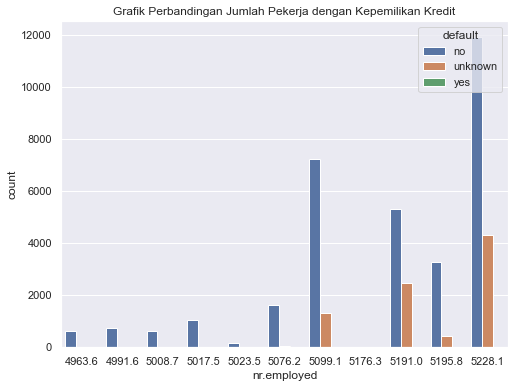

In [443]:
# Visualisasi data Analisis Multivariate antara default dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'default')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Kepemilikan Kredit')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah karyawan sebanyak 5228 orang dan kelompok didominasi status tanpa kepemilikan kredit

### Analisis Multivariate terhadap Housing

In [197]:
# Analisis Multivariate antara housing dan loan
(pd.crosstab(index = df['housing'], columns = df['loan'], normalize = 'all')*100).round(2)

loan        no  unknown   yes
housing                      
no       39.00      0.0  6.21
unknown   0.00      2.4  0.00
yes      43.42      0.0  8.96

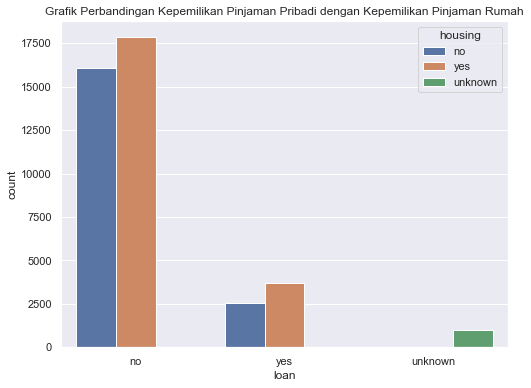

In [410]:
# Visualisasi data Analisis Multivariate antara housing dan loan
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Kepemilikan Pinjaman Pribadi dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa pinjaman pribadi dan kelompok didominasi oleh status dengan kepemilikan pinjaman rumah

In [198]:
# Analisis Multivariate antara housing dan contact
(pd.crosstab(index = df['housing'], columns = df['contact'], normalize = 'all')*100).round(2)

contact  cellular  telephone
housing                     
no          26.83      18.38
unknown      1.36       1.04
yes         35.28      17.10

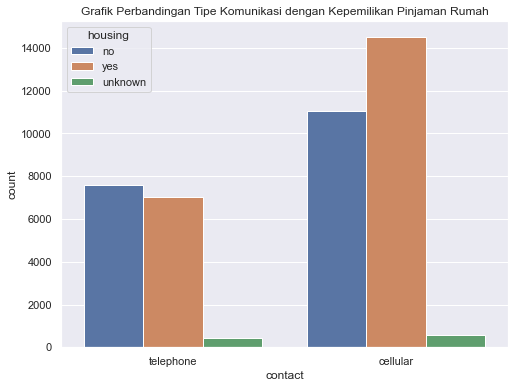

In [411]:
# Visualisasi data Analisis Multivariate antara housing dan contact
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Tipe Komunikasi dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tipe komunikasi dengan seluler dan kelompok didominasi status kepemilikan pinjaman rumah

In [199]:
# Analisis Multivariate antara housing dan month
(pd.crosstab(index = df['housing'], columns = df['month'], normalize = 'all')*100).round(2)

month     mar   apr    may   jun   jul   aug   sep   oct   nov   dec
housing                                                             
no       0.53  2.54  15.61  6.69  7.92  6.35  0.58  0.76  4.05  0.17
unknown  0.03  0.14   0.85  0.42  0.36  0.32  0.04  0.05  0.18  0.01
yes      0.77  3.71  16.97  5.80  9.14  8.33  0.76  0.93  5.72  0.25

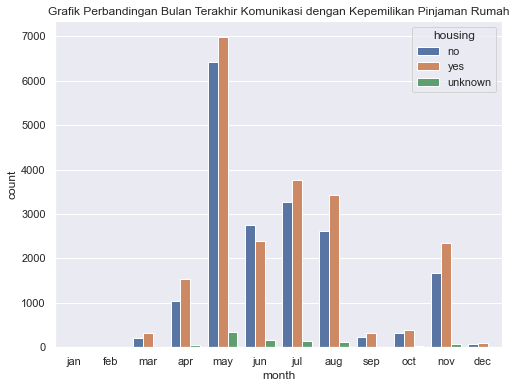

In [412]:
# Visualisasi data Analisis Multivariate antara housing dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan bulan terakhir komunikasi pada Mei dan dominasi kelompok dengan status dengan pinjaman rumah

In [200]:
# Analisis Multivariate antara housing dan day_of_week
(pd.crosstab(index = df['housing'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week    mon    tue    wed    thu   fri
housing                                      
no            9.13   9.07   8.89   9.25  8.87
unknown       0.46   0.51   0.48   0.46  0.49
yes          11.08  10.07  10.38  11.23  9.64

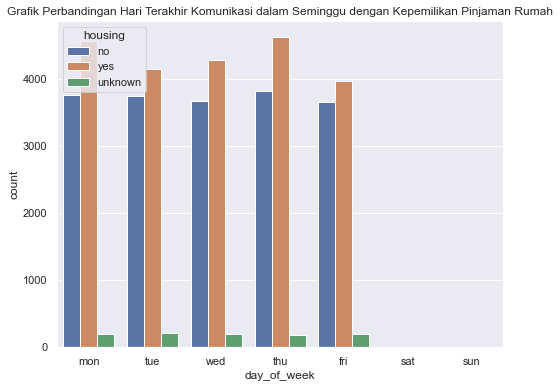

In [413]:
# Visualisasi data Analisis Multivariate antara housing dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Hari Terakhir Komunikasi dalam Seminggu dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hari terakhir komunikasi dalam seminggu pada hari Kamis dan dominasi kelompok dengan kepemilikan pinjaman rumah

In [201]:
# Analisis Multivariate antara housing dan duration
(pd.crosstab(index = df['housing'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin  0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
housing                                                        
no            41.34         3.77         0.09              0.01
unknown        2.21         0.19         0.00              0.00
yes           48.04         4.20         0.14              0.00

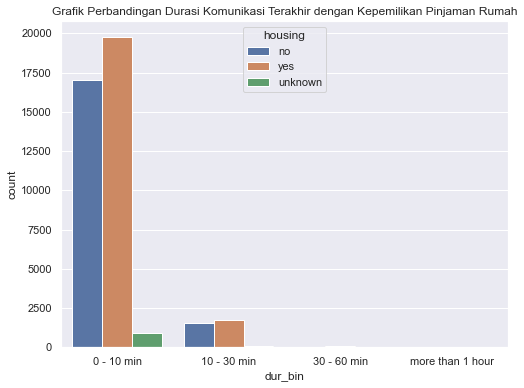

In [414]:
# Visualisasi data Analisis Multivariate antara housing dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Durasi Komunikasi Terakhir dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan lama panggilan terakhir pada masa kampanye selama 0 - 10 menit dan kelompok didominasi status dengan kepemilikan pinjaman rumah

In [202]:
# Analisis Multivariate antara housing dan campaign
(pd.crosstab(index = df['housing'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin  0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
housing                                                              
no              44.18           0.86           0.15           0.03   
unknown          2.36           0.04           0.00           0.00   
yes             51.36           0.83           0.15           0.04   

cam_bin  40-50 times  more than 50 times  
housing                                   
no              0.00                 0.0  
unknown         0.00                 0.0  
yes             0.01                 0.0

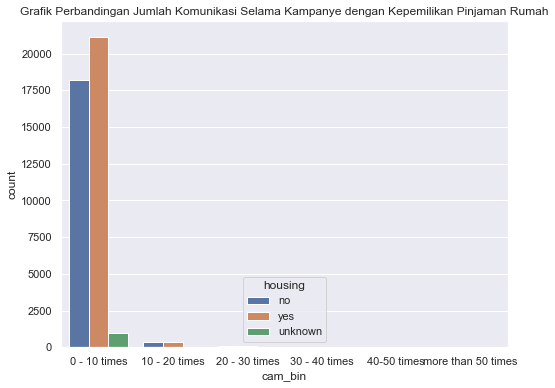

In [415]:
# Visualisasi data Analisis Multivariate antara housing dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Jumlah Komunikasi Selama Kampanye dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah komunikasi selama kampanye sebanyak 0 - 10 kali dengan dominasi kelompok oleh status memiliki pinjaman rumah

In [203]:
# Analisis Multivariate antara housing dan pdays
(pd.crosstab(index = df['housing'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin  0 - 10 days  10 - 20 days  20 - 30 days  no contact
housing                                                       
no                1.33          0.22          0.01       43.66
unknown           0.08          0.00          0.00        2.32
yes               1.74          0.25          0.01       50.38

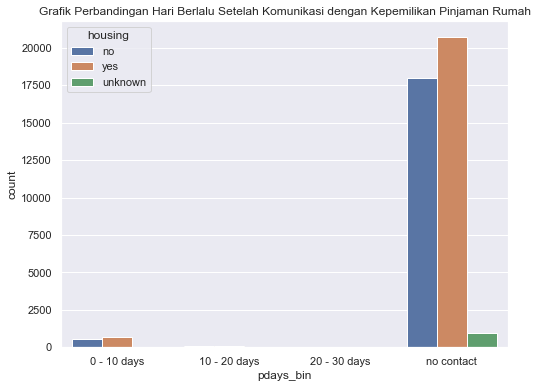

In [416]:
# Visualisasi data Analisis Multivariate antara housing dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Hari Berlalu Setelah Komunikasi dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi selama kampanye dengan dominasi kelompok oleh status dengan kepemilikan pinjaman rumah

In [204]:
# Analisis Multivariate antara housing dan previous
(pd.crosstab(index = df['housing'], columns = df['previous'], normalize = 'all')*100).round(2)

previous      0     1     2     3     4     5     6    7
housing                                                 
no        39.47  4.62  0.82  0.22  0.06  0.02  0.00  0.0
unknown    2.07  0.27  0.04  0.02  0.01  0.00  0.00  0.0
yes       44.81  6.19  0.97  0.29  0.10  0.03  0.01  0.0

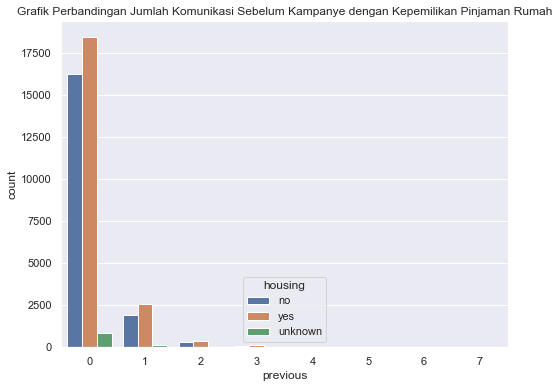

In [417]:
# Visualisasi data Analisis Multivariate antara housing dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Jumlah Komunikasi Sebelum Kampanye dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelumnya dengan dominasi kelompok oleh status dengan kepemilikan pinjaman rumah

In [205]:
# Analisis Multivariate antara housing dan poutcome
(pd.crosstab(index = df['housing'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome  failure  nonexistent  success
housing                                
no           4.34        39.47     1.41
unknown      0.27         2.07     0.07
yes          5.72        44.81     1.86

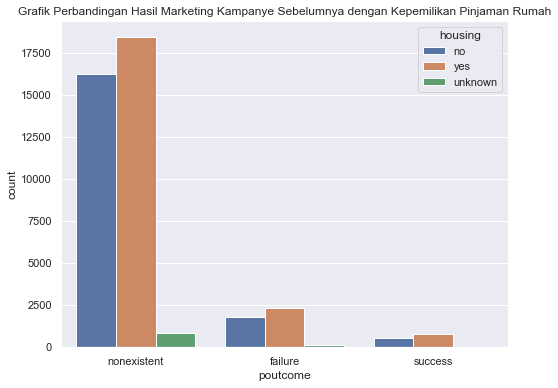

In [418]:
# Visualisasi data Analisis Multivariate antara housing dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Hasil Marketing Kampanye Sebelumnya dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil marketing kampanye sebelumnya tidak ada dan dominasi kelompok oleh status dengan kepemilikan pinjaman rumah

In [206]:
# Analisis Multivariate antara housing dan emp.var.rate
(pd.crosstab(index = df['housing'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1   1.1    1.4
housing                                                                   
no            1.12  0.17  1.72   9.04  0.82  0.64  0.00  3.63  9.63  18.42
unknown       0.06  0.01  0.12   0.49  0.04  0.05  0.00  0.16  0.53   0.93
yes           1.42  0.23  2.20  12.77  1.01  0.85  0.02  5.15  8.68  20.06

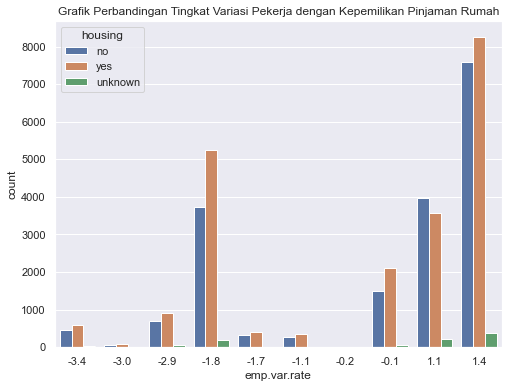

In [419]:
# Visualisasi data Analisis Multivariate antara housing dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerja dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerja sebesar 1.4 dan kelompok didominasi oleh status dengan kepemilikan pinjaman rumah

In [207]:
# Analisis Multivariate antara housing dan cons.price.idx
(pd.crosstab(index = df['housing'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
housing                                                                  
no                0.84    0.25    0.49    0.18    0.39    0.17    0.00   
unknown           0.05    0.01    0.03    0.01    0.02    0.01    0.00   
yes               0.98    0.39    0.57    0.24    0.46    0.23    0.02   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
housing                                                                  
no                0.24    5.78    0.70    2.38    3.55    0.29    5.25   
unknown           0.01    0.30    0.06    0.14    0.16    0.01    0.25   
yes               0.43    7.99    0.97    3.45    5.07    0.34    7.06   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
housing                                                                  
no                0.16    0.08    0.20    7.42    9.63    0.26    0.24   
unknown           0.00    0.00    0.01    0.33    0.53    0.02    0.01   
yes               0.26    0.08    0.30    8.48    8.68    0.29    0.31   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
housing                                                 
no                0.33    0.32    5.74    0.20    0.11  
unknown           0.03    0.02    0.35    0.02    0.00  
yes               0.37    0.42    4.52    0.28    0.20

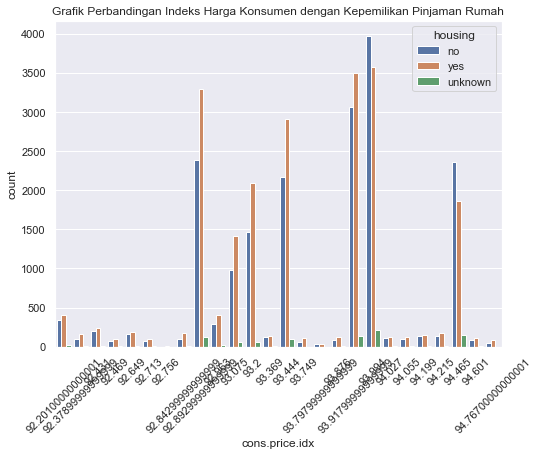

In [424]:
# Visualisasi data Analisis Multivariate antara housing dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Kepemilikan Pinjaman Rumah')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok indeks harga pelanggan sebesar 93.994 dengan dominasi kelompok oleh status tanpa pinjaman rumah

In [208]:
# Analisis Multivariate antara housing dan cons.conf.idx
(pd.crosstab(index = df['housing'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
housing                                                                        
no              0.11   0.24   0.20   2.38   5.78   0.00   7.42   3.55   5.74   
unknown         0.00   0.01   0.02   0.14   0.30   0.00   0.33   0.16   0.35   
yes             0.20   0.43   0.28   3.45   7.99   0.02   8.48   5.07   4.52   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
housing                                                                        
no              0.70   0.08   0.32   0.20   0.24   0.26   0.33   9.63   5.25   
unknown         0.06   0.00   0.02   0.01   0.01   0.02   0.03   0.53   0.25   
yes             0.97   0.08   0.42   0.30   0.31   0.29   0.37   8.68   7.06   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
housing                                                                
no              0.29   0.16   0.18   0.17   0.84   0.39   0.25   0.49  
unknown         0.01   0.00   0.01   0.01   0.05   0.02   0.01   0.03  
yes             0.34   0.26   0.24   0.23   0.98   0.46   0.39   0.57

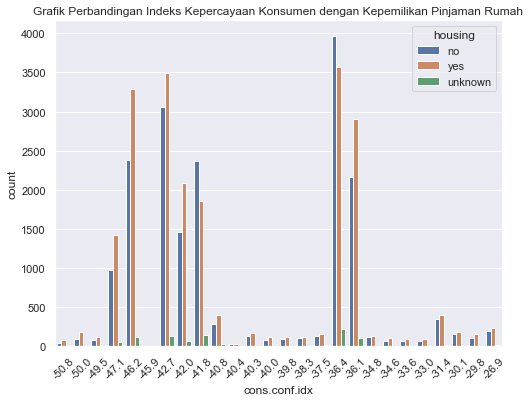

In [423]:
# Visualisasi data Analisis Multivariate antara housing dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Kepemilikan Pinjaman Rumah')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok oleh status tanpa kepemilikan pinjaman rumah

In [209]:
# Analisis Multivariate antara housing dan euribor3m
(pd.crosstab(index = df['housing'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin  0 - 1  1 - 2  3 - 4     >4
housing                            
no        4.11   9.41   0.01  31.68
unknown   0.24   0.53   0.00   1.63
yes       5.13  13.34   0.03  33.88

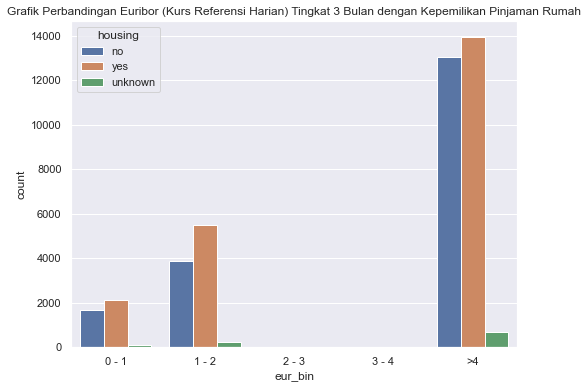

In [425]:
# Visualisasi data Analisis Multivariate antara housing dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan euribor (kurs referensi harian) lebih besar dari 4 dan dominasi kelompok oleh status dengan kepemilikan pinjaman rumah

In [210]:
# Analisis Multivariate antara housing dan nr.employed
(pd.crosstab(index = df['housing'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
housing                                                                       
no             0.64    0.82    0.65    1.12    0.17    1.72    8.40    0.00   
unknown        0.05    0.04    0.03    0.06    0.01    0.12    0.45    0.00   
yes            0.85    1.01    0.90    1.42    0.23    2.20   11.87    0.02   

nr.employed  5191.0  5195.8  5228.1  
housing                              
no             9.63    3.63   18.42  
unknown        0.53    0.16    0.93  
yes            8.68    5.15   20.06

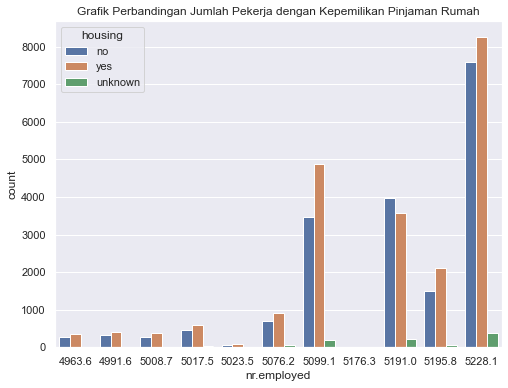

In [427]:
# Visualisasi data Analisis Multivariate antara housing dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'housing')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Kepemilikan Pinjaman Rumah')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah karyawan sebanyak 5228 orang dan kelompok didominasi oleh status memiliki pinjaman rumah

### Analisis Multivariate terhadap Loan

In [211]:
# Analisis Multivariate antara loan dan contact
(pd.crosstab(index = df['loan'], columns = df['contact'], normalize = 'all')*100).round(2)

contact  cellular  telephone
loan                        
no          52.25      30.17
unknown      1.36       1.04
yes          9.86       5.31

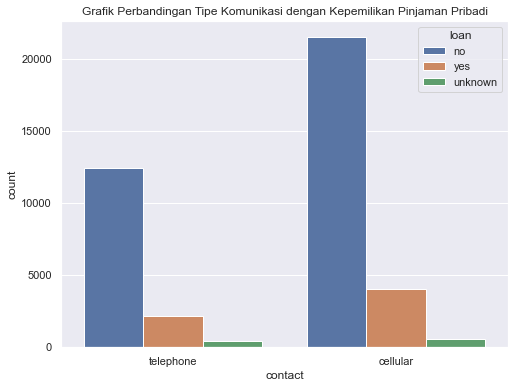

In [428]:
# Visualisasi data Analisis Multivariate antara loan dan contact
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Tipe Komunikasi dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tipe komunikasi menggunakan seluler dengan dominasi kelompok tanpa pinjaman pribadi

In [212]:
# Analisis Multivariate antara loan dan month
(pd.crosstab(index = df['loan'], columns = df['month'], normalize = 'all')*100).round(2)

month     mar   apr    may    jun    jul    aug   sep   oct   nov   dec
loan                                                                   
no       1.11  5.27  27.50  10.64  14.20  12.43  1.15  1.48  8.30  0.34
unknown  0.03  0.14   0.85   0.42   0.36   0.32  0.04  0.05  0.18  0.01
yes      0.18  0.98   5.08   1.84   2.86   2.25  0.20  0.22  1.47  0.08

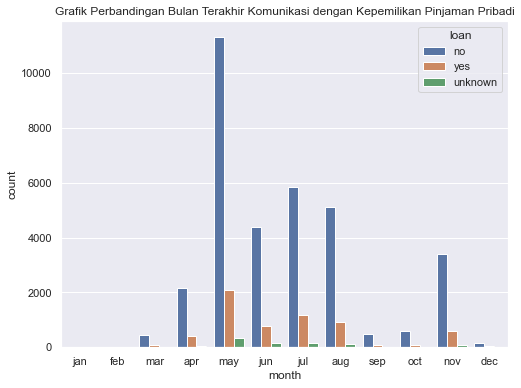

In [444]:
# Visualisasi data Analisis Multivariate antara loan dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok terakhir komunikasi pada bulan Mei dan dominasi kelompok dengan status tanpa kepemilikan pinjaman pribadi

In [213]:
# Analisis Multivariate antara loan dan day_of_week
(pd.crosstab(index = df['loan'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week    mon    tue    wed    thu    fri
loan                                          
no           16.97  16.29  16.31  17.32  15.54
unknown       0.46   0.51   0.48   0.46   0.49
yes           3.24   2.84   2.96   3.16   2.97

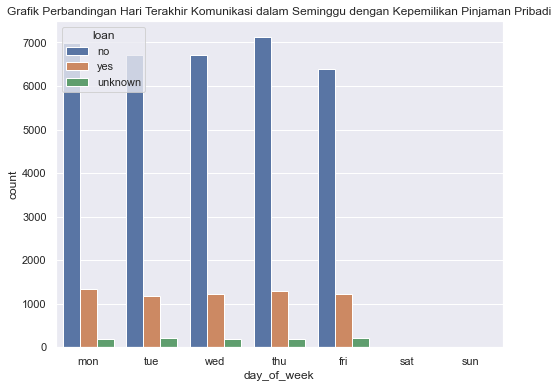

In [445]:
# Visualisasi data Analisis Multivariate antara loan dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Hari Terakhir Komunikasi dalam Seminggu dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok hari terakhir komunikasi pada hari Kamis dengan dominasi kelompok tanpa kepemilikan pinjaman pribadi

In [214]:
# Analisis Multivariate antara loan dan duration
(pd.crosstab(index = df['loan'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin  0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
loan                                                           
no            75.51         6.73         0.18              0.01
unknown        2.21         0.19         0.00              0.00
yes           13.87         1.24         0.05              0.00

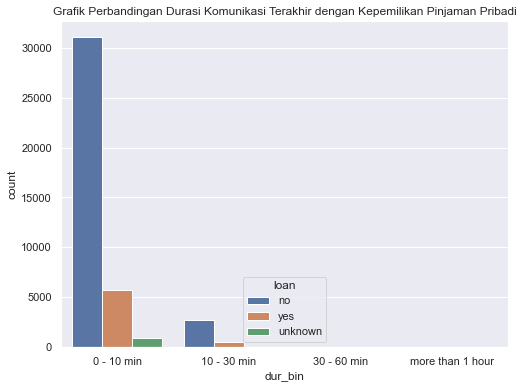

In [446]:
# Visualisasi data Analisis Multivariate antara loan dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Durasi Komunikasi Terakhir dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok durasi komunikasi terakhir pada rentang 0 - 10 menit dengan dominasi kelompok oleh status tidak memiliki pinjaman pribadi

In [215]:
# Analisis Multivariate antara loan dan campaign
(pd.crosstab(index = df['loan'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin  0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
loan                                                                 
no              80.68           1.43           0.25           0.06   
unknown          2.36           0.04           0.00           0.00   
yes             14.86           0.26           0.05           0.00   

cam_bin  40-50 times  more than 50 times  
loan                                      
no              0.01                 0.0  
unknown         0.00                 0.0  
yes             0.00                 0.0

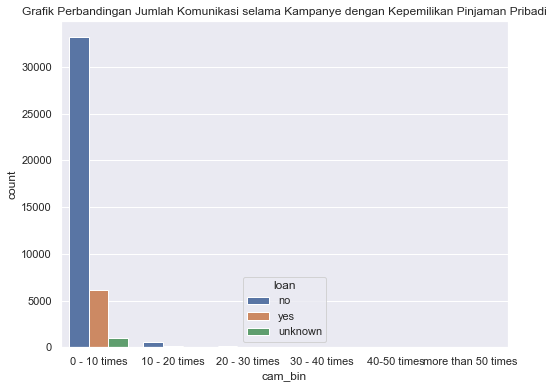

In [447]:
# Visualisasi data Analisis Multivariate antara loan dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Jumlah Komunikasi selama Kampanye dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah komunikasi sebanyak 0 - 10 kali dan dominasi kelompok oleh status tanpa pinjaman pribadi

In [216]:
# Analisis Multivariate antara loan dan pdays
(pd.crosstab(index = df['loan'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin  0 - 10 days  10 - 20 days  20 - 30 days  no contact
loan                                                          
no                2.59          0.40          0.02       79.42
unknown           0.08          0.00          0.00        2.32
yes               0.48          0.07          0.00       14.62

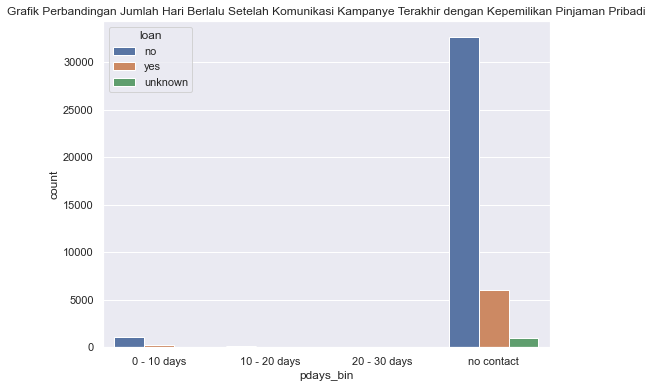

In [449]:
# Visualisasi data Analisis Multivariate antara loan dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu Setelah Komunikasi Kampanye Terakhir dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa komunikasi setelah kampanye terakhir dengan dominasi kelompok oleh status tanpa kepemilikan pinjaman pribadi

In [217]:
# Analisis Multivariate antara loan dan previous
(pd.crosstab(index = df['loan'], columns = df['previous'], normalize = 'all')*100).round(2)

previous      0     1     2     3     4     5     6    7
loan                                                    
no        71.18  9.12  1.49  0.45  0.13  0.04  0.01  0.0
unknown    2.07  0.27  0.04  0.02  0.01  0.00  0.00  0.0
yes       13.10  1.68  0.29  0.06  0.03  0.00  0.00  0.0

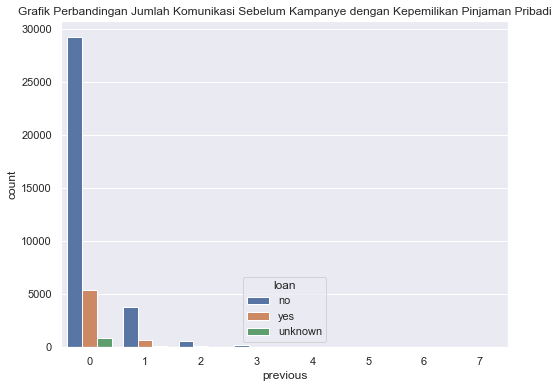

In [450]:
# Visualisasi data Analisis Multivariate antara loan dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Jumlah Komunikasi Sebelum Kampanye dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok tanpa komunikasi sebelum kampanye dan dominasi kelompok dengan status tanpa pinjaman pribadi

In [218]:
# Analisis Multivariate antara loan dan poutcome
(pd.crosstab(index = df['loan'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome  failure  nonexistent  success
loan                                   
no           8.49        71.18     2.76
unknown      0.27         2.07     0.07
yes          1.57        13.10     0.50

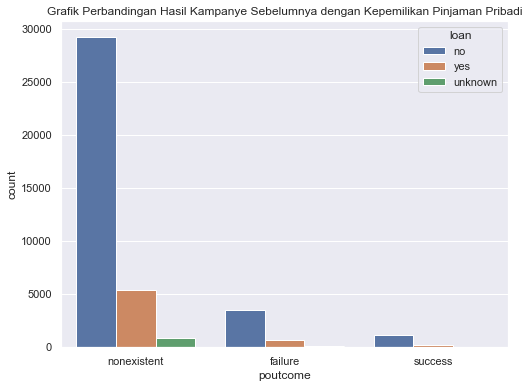

In [451]:
# Visualisasi data Analisis Multivariate antara loan dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil kampamnye sebelumnya tidak ada dan kelompok didominasi oleh status tanpa kepemilikan pinjaman pribadi

In [219]:
# Analisis Multivariate antara loan dan emp.var.rate
(pd.crosstab(index = df['loan'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
loan                                                                       
no            2.18  0.33  3.37  18.29  1.53  1.30  0.01  7.45  15.59  32.37
unknown       0.06  0.01  0.12   0.49  0.04  0.05  0.00  0.16   0.53   0.93
yes           0.36  0.07  0.55   3.52  0.30  0.20  0.01  1.33   2.72   6.11

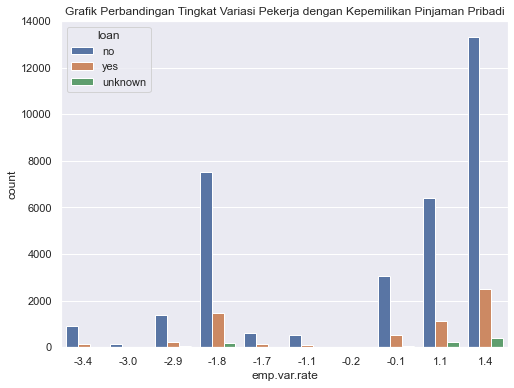

In [452]:
# Visualisasi data Analisis Multivariate antara loan dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerja dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerja sebesar 1.4 dengan dominasi kelompok oleh status tanpa kepemilikan pinjaman pribadi

In [220]:
# Analisis Multivariate antara loan dan cons.price.idx
(pd.crosstab(index = df['loan'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
loan                                                                     
no                1.59    0.53    0.93    0.35    0.72    0.33    0.01   
unknown           0.05    0.01    0.03    0.01    0.02    0.01    0.00   
yes               0.24    0.10    0.13    0.07    0.13    0.07    0.01   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
loan                                                                     
no                0.55   11.49    1.43    4.93    7.31    0.56   10.35   
unknown           0.01    0.30    0.06    0.14    0.16    0.01    0.25   
yes               0.12    2.28    0.25    0.91    1.31    0.07    1.97   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
loan                                                                     
no                0.34    0.15    0.43   13.26   15.59    0.50    0.45   
unknown           0.00    0.00    0.01    0.33    0.53    0.02    0.01   
yes               0.08    0.01    0.07    2.64    2.72    0.05    0.09   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
loan                                                    
no                0.61    0.59    8.76    0.41    0.28  
unknown           0.03    0.02    0.35    0.02    0.00  
yes               0.09    0.15    1.50    0.07    0.03

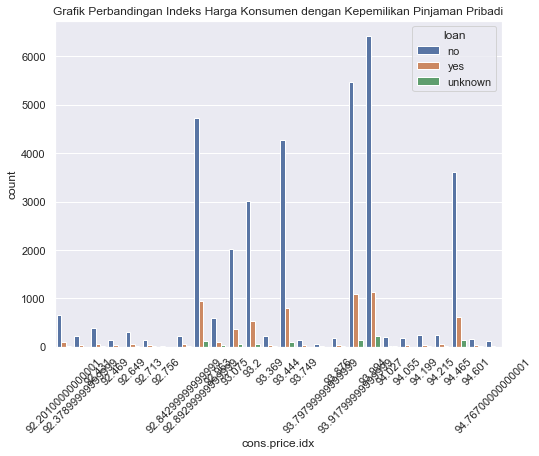

In [454]:
# Visualisasi data Analisis Multivariate antara loan dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Kepemilikan Pinjaman Pribadi')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok oleh status tidak memiliki pinjaman pribadi

In [221]:
# Analisis Multivariate antara loan dan cons.conf.idx
(pd.crosstab(index = df['loan'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
loan                                                                           
no              0.28   0.55   0.41   4.93  11.49   0.01  13.26   7.31   8.76   
unknown         0.00   0.01   0.02   0.14   0.30   0.00   0.33   0.16   0.35   
yes             0.03   0.12   0.07   0.91   2.28   0.01   2.64   1.31   1.50   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
loan                                                                           
no              1.43   0.15   0.59   0.43   0.45   0.50   0.61  15.59  10.35   
unknown         0.06   0.00   0.02   0.01   0.01   0.02   0.03   0.53   0.25   
yes             0.25   0.01   0.15   0.07   0.09   0.05   0.09   2.72   1.97   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
loan                                                                   
no              0.56   0.34   0.35   0.33   1.59   0.72   0.53   0.93  
unknown         0.01   0.00   0.01   0.01   0.05   0.02   0.01   0.03  
yes             0.07   0.08   0.07   0.07   0.24   0.13   0.10   0.13

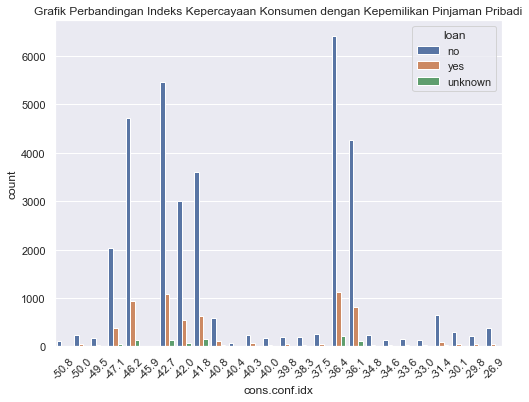

In [456]:
# Visualisasi data Analisis Multivariate antara loan dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Kepemilikan Pinjaman Pribadi')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan kelompok didominasi oleh status tanpa pinjaman pribadi

In [222]:
# Analisis Multivariate antara loan dan euribor3m
(pd.crosstab(index = df['loan'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin  0 - 1  1 - 2  3 - 4     >4
loan                               
no        7.88  19.12   0.02  55.41
unknown   0.24   0.53   0.00   1.63
yes       1.36   3.63   0.01  10.16

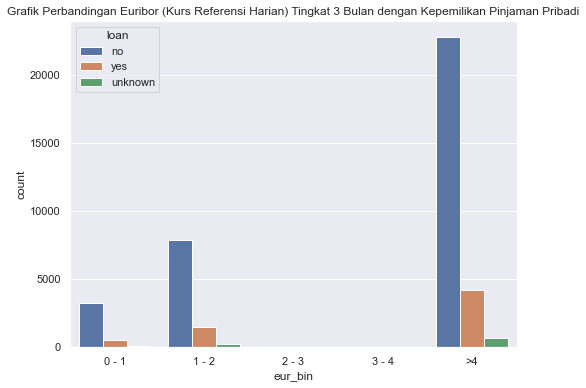

In [458]:
# Visualisasi data Analisis Multivariate antara loan dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan euribor (kurs referensi harian) lebih besar dari 4 dan kelompok didominasi oleh status tanpa kepemilikan pinjaman pribadi

In [223]:
# Analisis Multivariate antara loan dan nr.employed
(pd.crosstab(index = df['loan'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
loan                                                                          
no             1.30    1.53    1.33    2.18    0.33    3.37   16.97    0.01   
unknown        0.05    0.04    0.03    0.06    0.01    0.12    0.45    0.00   
yes            0.20    0.30    0.22    0.36    0.07    0.55    3.30    0.01   

nr.employed  5191.0  5195.8  5228.1  
loan                                 
no            15.59    7.45   32.37  
unknown        0.53    0.16    0.93  
yes            2.72    1.33    6.11

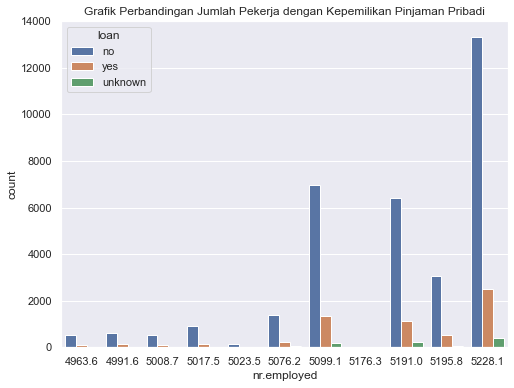

In [460]:
# Visualisasi data Analisis Multivariate antara loan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'loan')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Kepemilikan Pinjaman Pribadi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi oleh kelompok dengan jumlah pekerja sebanyak 5228 orang dan kelompok didominasi oleh status tanpa kepemilikan pinjaman pribadi

### Analisis Multivariate terhadap Contact

In [224]:
# Analisis Multivariate antara contact dan month
(pd.crosstab(index = df['contact'], columns = df['month'], normalize = 'all')*100).round(2)

month       mar   apr    may    jun    jul    aug   sep   oct   nov   dec
contact                                                                  
cellular   1.18  5.94  13.40   1.99  14.80  14.35  1.17  1.37  8.92  0.36
telephone  0.15  0.45  20.03  10.92   2.62   0.65  0.21  0.38  1.03  0.08

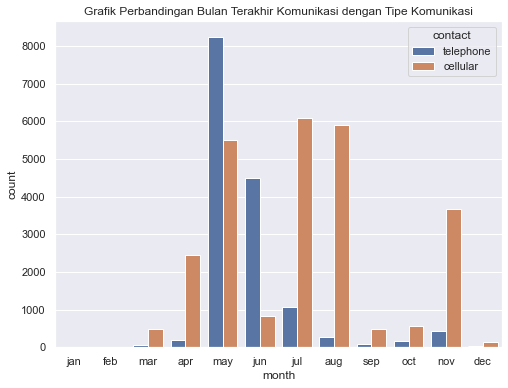

In [461]:
# Visualisasi data Analisis Multivariate antara contact dan month
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok yang terakhir dihubungi pada bulan Mei dengan dominasi kelompok oleh tipe komunikasi dengan seluler

In [225]:
# Analisis Multivariate antara contact dan day_of_week
(pd.crosstab(index = df['contact'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week    mon    tue    wed    thu    fri
contact                                       
cellular     13.44  12.40  12.27  14.09  11.28
telephone     7.23   7.24   7.48   6.84   7.73

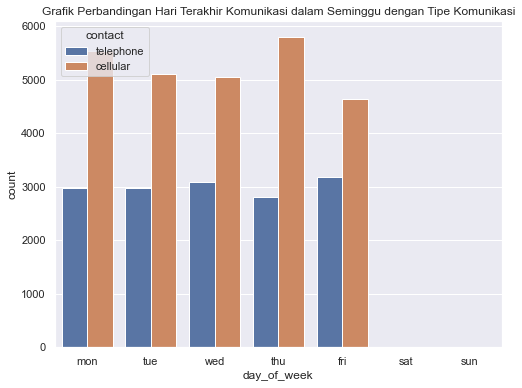

In [462]:
# Visualisasi data Analisis Multivariate antara contact dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Hari Terakhir Komunikasi dalam Seminggu dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok yang terakhir komunikasi pada hari Kamis dengan dominasi kelompok oleh tipe komunikasi dengan seluler

In [226]:
# Analisis Multivariate antara contact dan duration
(pd.crosstab(index = df['contact'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin    0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
contact                                                          
cellular        57.81         5.52         0.14              0.00
telephone       33.78         2.64         0.09              0.01

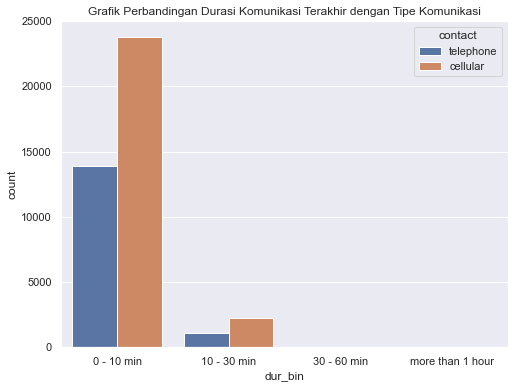

In [463]:
# Visualisasi data Analisis Multivariate antara contact dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Durasi Komunikasi Terakhir dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok yang durasi komunikasi pada panggilan terakhir dalam rentang 0 - 10 menit dan dominasi kelompok oleh tipe komunikasi dengan seluler

In [227]:
# Analisis Multivariate antara contact dan campaign
(pd.crosstab(index = df['contact'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin    0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
contact                                                                
cellular          62.50           0.83           0.12           0.03   
telephone         35.39           0.90           0.18           0.04   

cam_bin    40-50 times  more than 50 times  
contact                                     
cellular          0.00                 0.0  
telephone         0.01                 0.0

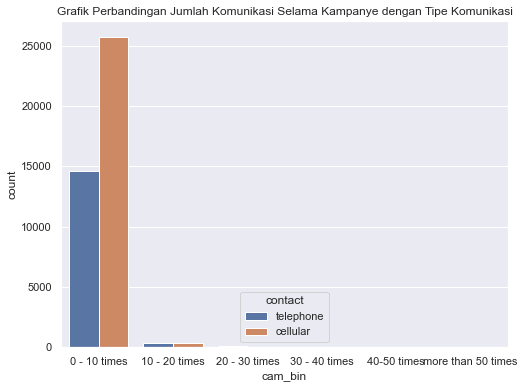

In [464]:
# Visualisasi data Analisis Multivariate antara contact dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Jumlah Komunikasi Selama Kampanye dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah komunikasi selama kampanye pada rentang 0 - 10 kali dengan dominasi kelompok oleh tipe komunikasi seluler

In [228]:
# Analisis Multivariate antara contact dan pdays
(pd.crosstab(index = df['contact'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin  0 - 10 days  10 - 20 days  20 - 30 days  no contact
contact                                                       
cellular          2.92          0.44          0.02       60.09
telephone         0.23          0.03          0.00       36.26

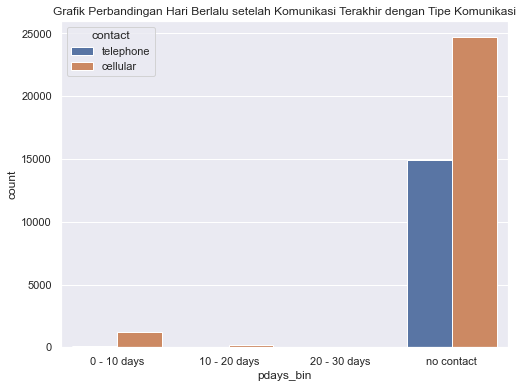

In [465]:
# Visualisasi data Analisis Multivariate antara contact dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Hari Berlalu setelah Komunikasi Terakhir dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi selama kampanye dan dominasi kelompok oleh tipe komunikasi dengan seluler

In [229]:
# Analisis Multivariate antara contact dan previous
(pd.crosstab(index = df['contact'], columns = df['previous'], normalize = 'all')*100).round(2)

previous       0      1     2     3     4     5     6    7
contact                                                   
cellular   50.80  10.29  1.68  0.50  0.15  0.04  0.01  0.0
telephone  35.55   0.78  0.15  0.03  0.02  0.00  0.00  0.0

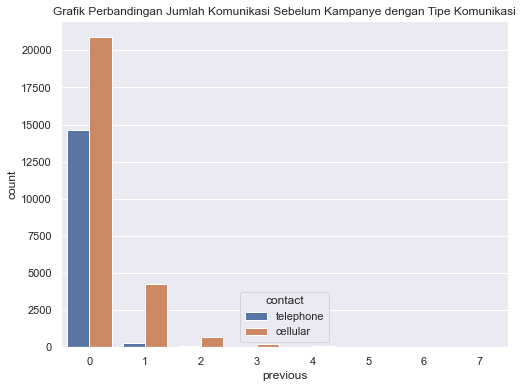

In [466]:
# Visualisasi data Analisis Multivariate antara contact dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Jumlah Komunikasi Sebelum Kampanye dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelum kampanye dan dominasi kelompok oleh tipe komunikasi melalui seluler

In [230]:
# Analisis Multivariate antara contact dan poutcome
(pd.crosstab(index = df['contact'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome   failure  nonexistent  success
contact                                 
cellular      9.60        50.80     3.08
telephone     0.73        35.55     0.25

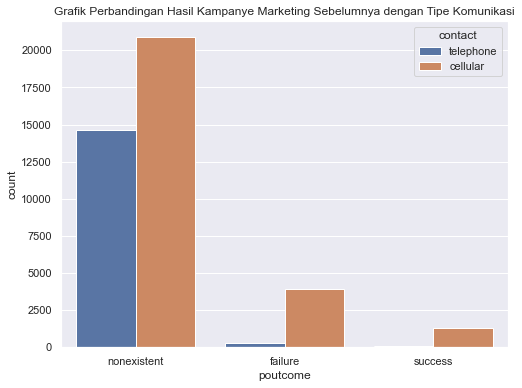

In [467]:
# Visualisasi data Analisis Multivariate antara contact dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Hasil Kampanye Marketing Sebelumnya dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil dari kampanye sebelumnya berupa tidak ada dan kelompok didominasi oleh tipe komunikasi dengan seluler

In [231]:
# Analisis Multivariate antara contact dan emp.var.rate
(pd.crosstab(index = df['contact'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
contact                                                                    
cellular      2.28  0.36  3.66  20.51  1.44  1.29  0.00  7.89   0.00  26.04
telephone     0.32  0.06  0.37   1.78  0.44  0.25  0.02  1.05  18.85  13.38

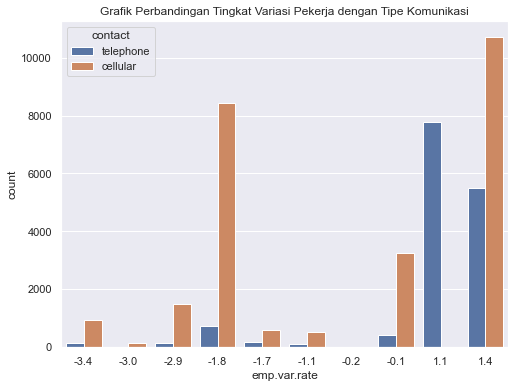

In [468]:
# Visualisasi data Analisis Multivariate antara contact dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerja dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerja sebesar 1.4 dan dominasi kelompok oleh tipe komunikasi dengan seluler

In [232]:
# Analisis Multivariate antara contact dan cons.price.idx
(pd.crosstab(index = df['contact'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
contact                                                                  
cellular          1.70    0.58    0.95    0.37    0.76    0.36    0.00   
telephone         0.17    0.07    0.14    0.06    0.11    0.06    0.02   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
contact                                                                  
cellular          0.64   12.98    1.59    5.57    7.89    0.54   12.21   
telephone         0.05    1.09    0.15    0.40    0.89    0.10    0.36   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
contact                                                                  
cellular          0.37    0.00    0.42   13.83    0.00    0.43    0.40   
telephone         0.06    0.16    0.10    2.40   18.85    0.13    0.15   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
contact                                                 
cellular          0.59    0.60    0.00    0.42    0.28  
telephone         0.14    0.16   10.62    0.08    0.03

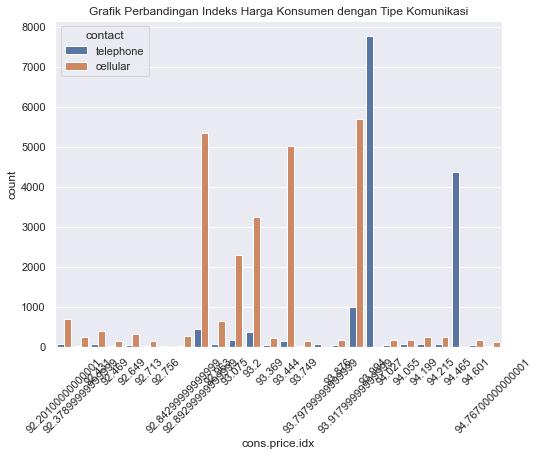

In [470]:
# Visualisasi data Analisis Multivariate antara contact dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Tipe Komunikasi')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok oleh jenis komunikasi menggunakan telepon

In [233]:
# Analisis Multivariate antara contact dan cons.conf.idx
(pd.crosstab(index = df['contact'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
contact                                                                        
cellular        0.28   0.64   0.42   5.57  12.98   0.00  13.83   7.89   0.00   
telephone       0.03   0.05   0.08   0.40   1.09   0.02   2.40   0.89  10.62   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
contact                                                                        
cellular        1.59   0.00   0.60   0.42   0.40   0.43   0.59   0.00  12.21   
telephone       0.15   0.16   0.16   0.10   0.15   0.13   0.14  18.85   0.36   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
contact                                                                
cellular        0.54   0.37   0.37   0.36   1.70   0.76   0.58   0.95  
telephone       0.10   0.06   0.06   0.06   0.17   0.11   0.07   0.14

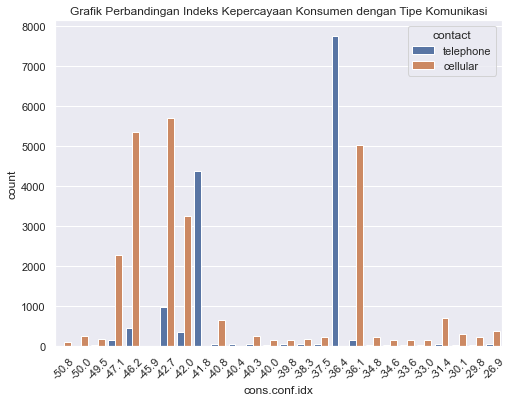

In [472]:
# Visualisasi data Analisis Multivariate antara contact dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Tipe Komunikasi')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok oleh tipe komunikasi dengan telepon

In [234]:
# Analisis Multivariate antara contact dan euribor3m
(pd.crosstab(index = df['contact'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin    0 - 1  1 - 2  3 - 4     >4
contact                              
cellular    8.03  21.51   0.00  33.93
telephone   1.45   1.77   0.03  33.27

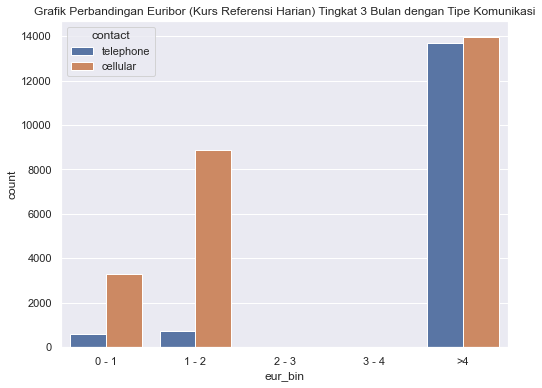

In [473]:
# Visualisasi data Analisis Multivariate antara contact dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok euribor (kurs referensi harian) lebih besar dari 4 dan dominasi kelompok oleh tipe komunikasi menggunakan seluler

In [235]:
# Analisis Multivariate antara contact dan nr.employed
(pd.crosstab(index = df['contact'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
contact                                                                       
cellular       1.29    1.44    1.33    2.28    0.36    3.66   19.19    0.00   
telephone      0.25    0.44    0.25    0.32    0.06    0.37    1.53    0.02   

nr.employed  5191.0  5195.8  5228.1  
contact                              
cellular       0.00    7.89   26.04  
telephone     18.85    1.05   13.38

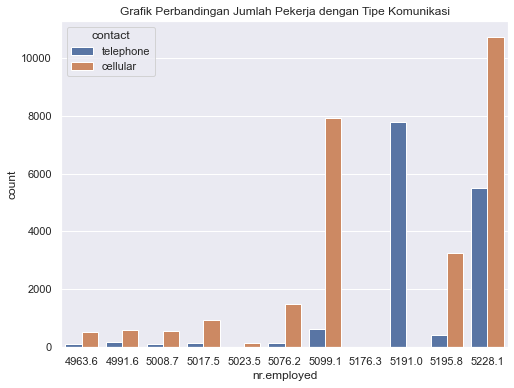

In [474]:
# Visualisasi data Analisis Multivariate antara contact dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'contact')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Tipe Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanyak 5228 orang dan dominasi kelompok oleh tipe komunikasi dengan seluler

### Analisis Multivariate terhadap Month

In [236]:
# Analisis Multivariate antara month dan day_of_week
(pd.crosstab(index = df['month'], columns = df['day_of_week'], normalize = 'all')*100).round(2)

day_of_week   mon   tue   wed   thu   fri
month                                    
mar          0.35  0.34  0.17  0.24  0.23
apr          1.70  0.61  0.73  1.86  1.48
may          6.41  6.82  7.10  6.16  6.94
jun          3.04  2.36  2.39  2.35  2.78
jul          3.68  3.68  3.54  4.06  2.46
aug          2.97  3.15  3.02  3.27  2.60
sep          0.22  0.29  0.30  0.30  0.28
oct          0.31  0.36  0.33  0.40  0.34
nov          1.86  1.98  2.10  2.19  1.83
dec          0.13  0.06  0.08  0.11  0.06

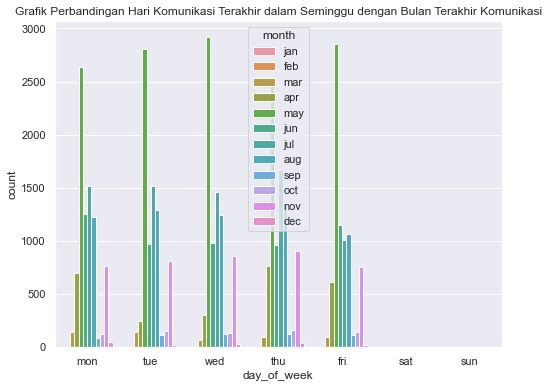

In [476]:
# Visualisasi data Analisis Multivariate antara month dan day_of_week
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'month')
plt.title('Grafik Perbandingan Hari Komunikasi Terakhir dalam Seminggu dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hari terakhir komunikasi pada hari Kamis dengan dominasi kelompok terakhir dihubungi pada bulan Mei

In [237]:
# Analisis Multivariate antara month dan duration
(pd.crosstab(index = df['month'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin  0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
month                                                          
mar            1.26         0.06         0.00               0.0
apr            5.72         0.65         0.02               0.0
may           30.74         2.63         0.06               0.0
jun           11.94         0.94         0.03               0.0
jul           15.58         1.79         0.04               0.0
aug           13.99         0.98         0.03               0.0
sep            1.24         0.14         0.00               0.0
oct            1.58         0.16         0.01               0.0
nov            9.15         0.78         0.02               0.0
dec            0.39         0.05         0.00               0.0

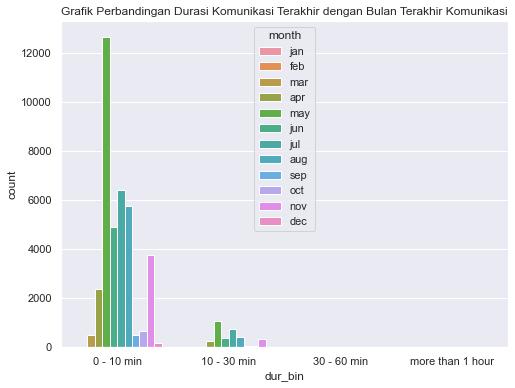

In [479]:
# Visualisasi data Analisis Multivariate antara month dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'month')
plt.title('Grafik Perbandingan Durasi Komunikasi Terakhir dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompoj dengan durasi komunikasi terakhir pada rentang 0 - 10 menit dan dominasi kelompok dihubungi terakhir pada bulan Mei

In [239]:
# Analisis Multivariate antara month dan campaign
(pd.crosstab(index = df['month'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin  0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
month                                                                
mar              1.31           0.02           0.00           0.00   
apr              6.37           0.02           0.00           0.00   
may             33.00           0.37           0.04           0.01   
jun             12.36           0.41           0.12           0.02   
jul             16.69           0.56           0.13           0.04   
aug             14.64           0.34           0.01           0.00   
sep              1.38           0.00           0.00           0.00   
oct              1.74           0.00           0.00           0.00   
nov              9.95           0.00           0.00           0.00   
dec              0.44           0.00           0.00           0.00   

cam_bin  40-50 times  more than 50 times  
month                                     
mar              0.0                 0.0  
apr              0.0                 0.0  
may              0.0                 0.0  
jun              0.0                 0.0  
jul              0.0                 0.0  
aug              0.0                 0.0  
sep              0.0                 0.0  
oct              0.0                 0.0  
nov              0.0                 0.0  
dec              0.0                 0.0

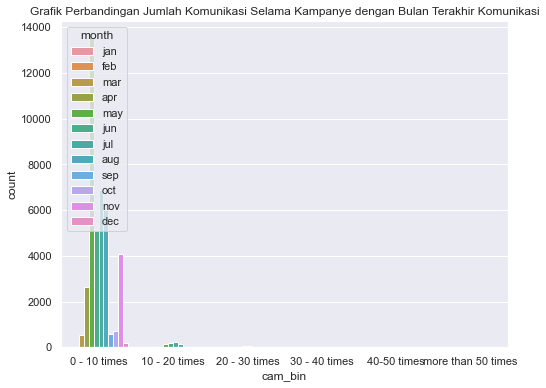

In [480]:
# Visualisasi data Analisis Multivariate antara month dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'month')
plt.title('Grafik Perbandingan Jumlah Komunikasi Selama Kampanye dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah komunikasi selama kampanye pada rentang 0 - 10 kali dan dominasi kelompok terakhir dihubungi pada bulan Mei

In [240]:
# Analisis Multivariate antara month dan pdays
(pd.crosstab(index = df['month'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin  0 - 10 days  10 - 20 days  20 - 30 days  no contact
month                                                         
mar               0.19          0.03           0.0        1.11
apr               0.25          0.02           0.0        6.11
may               0.48          0.12           0.0       32.84
jun               0.33          0.05           0.0       12.54
jul               0.20          0.08           0.0       17.14
aug               0.47          0.08           0.0       14.43
sep               0.34          0.04           0.0        0.99
oct               0.34          0.04           0.0        1.36
nov               0.44          0.01           0.0        9.50
dec               0.11          0.00           0.0        0.33

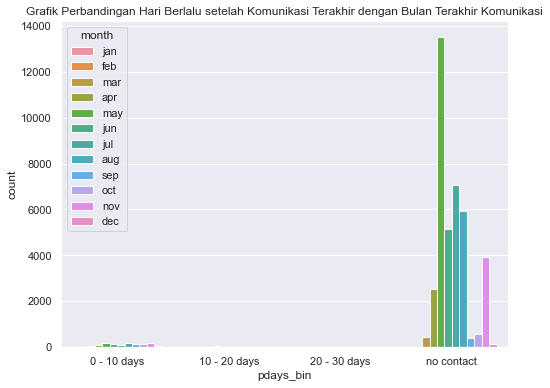

In [481]:
# Visualisasi data Analisis Multivariate antara month dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'month')
plt.title('Grafik Perbandingan Hari Berlalu setelah Komunikasi Terakhir dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi selama masa kampanye dan dominasi kelompok terakhir dihubungi pada bulan Mei

In [241]:
# Analisis Multivariate antara month dan previous
(pd.crosstab(index = df['month'], columns = df['previous'], normalize = 'all')*100).round(2)

previous      0     1     2     3     4     5     6    7
month                                                   
mar        0.89  0.28  0.11  0.03  0.01  0.00  0.00  0.0
apr        4.55  1.64  0.18  0.01  0.00  0.00  0.00  0.0
may       28.55  4.41  0.37  0.06  0.02  0.01  0.00  0.0
jun       12.15  0.55  0.15  0.04  0.02  0.00  0.00  0.0
jul       16.86  0.34  0.17  0.04  0.00  0.00  0.00  0.0
aug       13.89  0.71  0.26  0.09  0.03  0.01  0.01  0.0
sep        0.69  0.41  0.17  0.07  0.04  0.01  0.00  0.0
oct        1.01  0.46  0.18  0.08  0.01  0.00  0.00  0.0
nov        7.52  2.13  0.18  0.08  0.02  0.01  0.00  0.0
dec        0.24  0.15  0.05  0.01  0.00  0.00  0.00  0.0

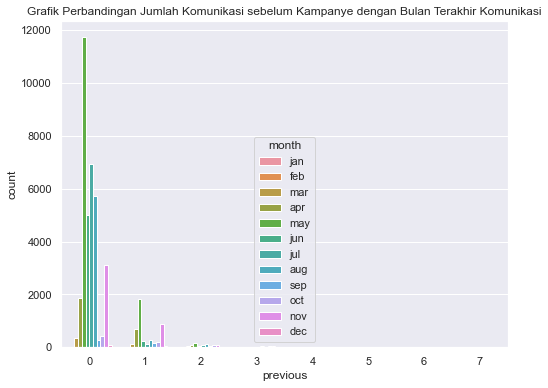

In [482]:
# Visualisasi data Analisis Multivariate antara month dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'month')
plt.title('Grafik Perbandingan Jumlah Komunikasi sebelum Kampanye dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelum kampanye dan kelompok didominasi bulan terakhir komunikasi pada Bulan Mei

In [242]:
# Analisis Multivariate antara month dan poutcome
(pd.crosstab(index = df['month'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome  failure  nonexistent  success
month                                  
mar          0.24         0.89     0.20
apr          1.57         4.55     0.27
may          4.32        28.55     0.56
jun          0.42        12.15     0.35
jul          0.29        16.86     0.26
aug          0.62        13.89     0.50
sep          0.33         0.69     0.36
oct          0.41         1.01     0.33
nov          2.04         7.52     0.40
dec          0.09         0.24     0.11

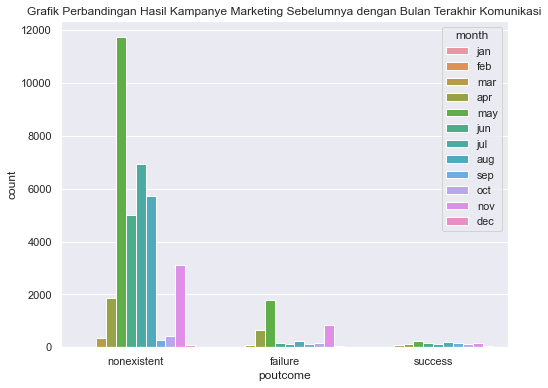

In [483]:
# Visualisasi data Analisis Multivariate antara month dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'month')
plt.title('Grafik Perbandingan Hasil Kampanye Marketing Sebelumnya dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasbah didominasi kelompok dengan hasil kampanye marketing sebelumnya berupa tidak ada dan dominasi kelompok terakhir dihubungi pada bulan Mei

In [243]:
# Analisis Multivariate antara month dan emp.var.rate
(pd.crosstab(index = df['month'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
month                                                                      
mar           0.00  0.00  0.00   1.33  0.00  0.00  0.00  0.00   0.00   0.00
apr           0.00  0.00  0.00   6.39  0.00  0.00  0.00  0.00   0.00   0.00
may           0.00  0.00  0.00  14.58  0.00  0.00  0.00  0.00  18.85   0.00
jun           0.00  0.00  1.74   0.00  0.56  0.00  0.00  0.00   0.00  10.62
jul           0.00  0.00  0.43   0.00  0.76  0.00  0.00  0.00   0.00  16.23
aug           0.00  0.00  1.87   0.00  0.57  0.00  0.00  0.00   0.00  12.56
sep           0.65  0.00  0.00   0.00  0.00  0.74  0.00  0.00   0.00   0.00
oct           1.09  0.00  0.00   0.00  0.00  0.50  0.00  0.16   0.00   0.00
nov           0.87  0.00  0.00   0.00  0.00  0.31  0.00  8.78   0.00   0.00
dec           0.00  0.42  0.00   0.00  0.00  0.00  0.02  0.00   0.00   0.00

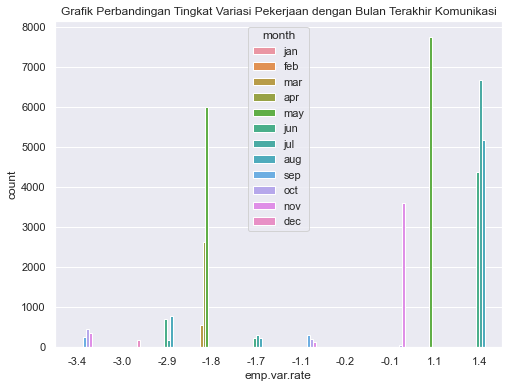

In [484]:
# Visualisasi data Analisis Multivariate antara month dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'month')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan dominasi kelompok terkahir dihubungi pada Bulan Agustus

In [244]:
# Analisis Multivariate antara month dan cons.price.idx
(pd.crosstab(index = df['month'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
month                                                                    
mar               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
apr               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
may               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
jun               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
jul               0.00    0.00    0.00    0.43    0.00    0.00    0.00   
aug               1.87    0.00    0.00    0.00    0.00    0.00    0.00   
sep               0.00    0.65    0.00    0.00    0.00    0.00    0.00   
oct               0.00    0.00    1.09    0.00    0.00    0.00    0.00   
nov               0.00    0.00    0.00    0.00    0.87    0.00    0.00   
dec               0.00    0.00    0.00    0.00    0.00    0.42    0.02   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
month                                                                    
mar               0.68    0.00    0.00    0.00    0.00    0.64    0.00   
apr               0.00    0.00    0.00    5.97    0.00    0.00    0.00   
may               0.00   14.07    0.00    0.00    0.00    0.00    0.00   
jun               0.00    0.00    1.74    0.00    0.00    0.00    0.00   
jul               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
aug               0.00    0.00    0.00    0.00    0.00    0.00   12.56   
sep               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
oct               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
nov               0.00    0.00    0.00    0.00    8.78    0.00    0.00   
dec               0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
month                                                                    
mar               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
apr               0.42    0.00    0.00    0.00    0.00    0.00    0.00   
may               0.00    0.00    0.51    0.00   18.85    0.00    0.00   
jun               0.00    0.00    0.00    0.00    0.00    0.00    0.56   
jul               0.00    0.00    0.00   16.23    0.00    0.00    0.00   
aug               0.00    0.00    0.00    0.00    0.00    0.57    0.00   
sep               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
oct               0.00    0.16    0.00    0.00    0.00    0.00    0.00   
nov               0.00    0.00    0.00    0.00    0.00    0.00    0.00   
dec               0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
month                                                   
mar               0.00    0.00    0.00     0.0    0.00  
apr               0.00    0.00    0.00     0.0    0.00  
may               0.00    0.00    0.00     0.0    0.00  
jun               0.00    0.00   10.62     0.0    0.00  
jul               0.00    0.76    0.00     0.0    0.00  
aug               0.00    0.00    0.00     0.0    0.00  
sep               0.74    0.00    0.00     0.0    0.00  
oct               0.00    0.00    0.00     0.5    0.00  
nov               0.00    0.00    0.00     0.0    0.31  
dec               0.00    0.00    0.00     0.0    0.00

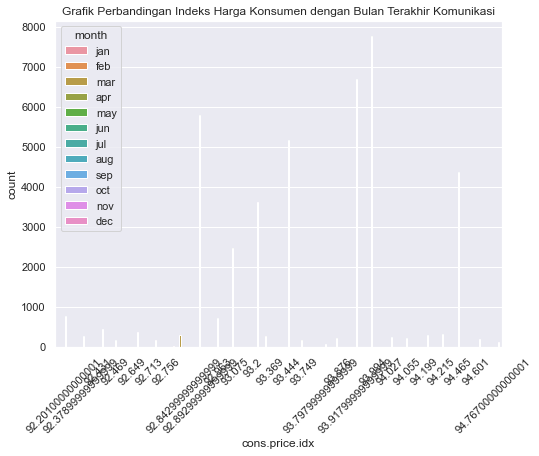

In [486]:
# Visualisasi data Analisis Multivariate antara month dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'month')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Bulan Terakhir Komunikasi')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.918 dan kelompok didominasi bulan terakhir komunikasi pada masa kampanye pada bulan Juli

In [245]:
# Analisis Multivariate antara month dan cons.conf.idx
(pd.crosstab(index = df['month'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
month                                                                          
mar             0.00   0.68    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
apr             0.00   0.00    0.0   5.97   0.00   0.00   0.00   0.00   0.00   
may             0.00   0.00    0.0   0.00  14.07   0.00   0.00   0.00   0.00   
jun             0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00  10.62   
jul             0.00   0.00    0.0   0.00   0.00   0.00  16.23   0.00   0.00   
aug             0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
sep             0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
oct             0.00   0.00    0.5   0.00   0.00   0.00   0.00   0.00   0.00   
nov             0.31   0.00    0.0   0.00   0.00   0.00   0.00   8.78   0.00   
dec             0.00   0.00    0.0   0.00   0.00   0.02   0.00   0.00   0.00   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
month                                                                          
mar             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
apr             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
may             0.00   0.00   0.00   0.51   0.00   0.00   0.00  18.85   0.00   
jun             1.74   0.00   0.00   0.00   0.56   0.00   0.00   0.00   0.00   
jul             0.00   0.00   0.76   0.00   0.00   0.00   0.00   0.00   0.00   
aug             0.00   0.00   0.00   0.00   0.00   0.57   0.00   0.00  12.56   
sep             0.00   0.00   0.00   0.00   0.00   0.00   0.74   0.00   0.00   
oct             0.00   0.16   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
nov             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
dec             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
month                                                                  
mar             0.64   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
apr             0.00   0.42   0.00   0.00   0.00   0.00   0.00   0.00  
may             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
jun             0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
jul             0.00   0.00   0.43   0.00   0.00   0.00   0.00   0.00  
aug             0.00   0.00   0.00   0.00   1.87   0.00   0.00   0.00  
sep             0.00   0.00   0.00   0.00   0.00   0.00   0.65   0.00  
oct             0.00   0.00   0.00   0.00   0.00   0.00   0.00   1.09  
nov             0.00   0.00   0.00   0.00   0.00   0.87   0.00   0.00  
dec             0.00   0.00   0.00   0.42   0.00   0.00   0.00   0.00

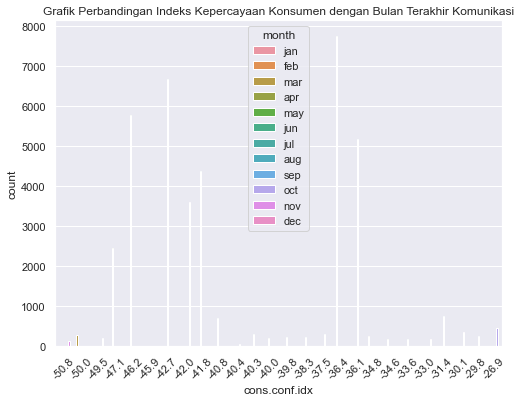

In [488]:
# Visualisasi data Analisis Multivariate antara month dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'month')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Bulan Terakhir Komunikasi')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok terakhir dihubungi pada bulan Mei

In [246]:
# Analisis Multivariate antara month dan euribor3m
(pd.crosstab(index = df['month'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin  0 - 1  1 - 2  3 - 4     >4
month                              
mar       0.64   0.68   0.00   0.00
apr       0.42   5.97   0.00   0.00
may       0.51  14.07   0.00  18.85
jun       0.56   1.74   0.00  10.62
jul       0.84   0.34   0.00  16.23
aug       2.44   0.00   0.00  12.56
sep       1.38   0.00   0.00   0.00
oct       1.41   0.17   0.00   0.16
nov       0.87   0.31   0.01   8.77
dec       0.42   0.00   0.02   0.00

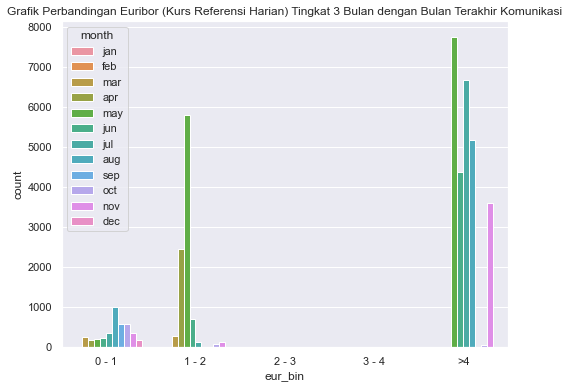

In [489]:
# Visualisasi data Analisis Multivariate antara month dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'month')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Bulan Terakhir Komunikasi')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor (kurs referensi harian) tingkat 3 bulan lebih besar dari 4 dan kelompok didominasi bulan terakhir komunikasi pada bulan Mei

### Analisis Multivariate terhadap Day_of_week

In [247]:
# Analisis Multivariate antara day_of_week dan duration
(pd.crosstab(index = df['day_of_week'], columns = df['dur_bin'], normalize = 'all')*100).round(2)

dur_bin      0 - 10 min  10 - 30 min  30 - 60 min  more than 1 hour
day_of_week                                                        
mon               19.16         1.47         0.03               0.0
tue               18.06         1.53         0.05               0.0
wed               17.94         1.77         0.04               0.0
thu               19.02         1.84         0.07               0.0
fri               17.40         1.55         0.04               0.0

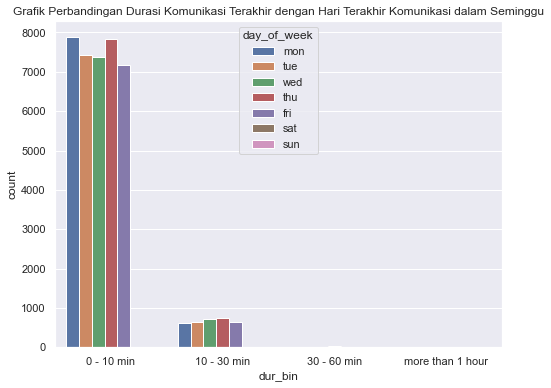

In [491]:
# Visualisasi data Analisis Multivariate antara day_of_week dan duration
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Durasi Komunikasi Terakhir dengan Hari Terakhir Komunikasi dalam Seminggu')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan durasi komunikasi pada rentang 0 - 10 menit dan kelompok didominasi hari terakhir komunikasi dalam seminggu pada Hari Senin

In [248]:
# Analisis Multivariate antara day_of_week dan campaign
(pd.crosstab(index = df['day_of_week'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin      0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
day_of_week                                                              
mon                 20.29           0.31           0.05           0.02   
tue                 19.28           0.31           0.04           0.01   
wed                 19.39           0.32           0.04           0.00   
thu                 20.38           0.42           0.11           0.03   
fri                 18.55           0.37           0.07           0.01   

cam_bin      40-50 times  more than 50 times  
day_of_week                                   
mon                  0.0                 0.0  
tue                  0.0                 0.0  
wed                  0.0                 0.0  
thu                  0.0                 0.0  
fri                  0.0                 0.0

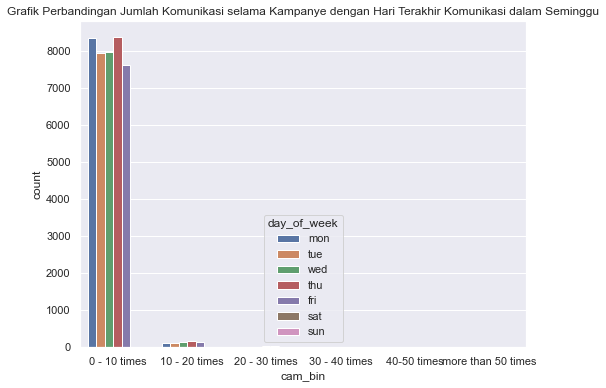

In [492]:
# Visualisasi data Analisis Multivariate antara day_of_week dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Jumlah Komunikasi selama Kampanye dengan Hari Terakhir Komunikasi dalam Seminggu')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah komunikasi selama kampanye sebanyak 0 - 10 kali dan dominasi kelompok terakhir dihubungi pada hari Kamis

In [249]:
# Analisis Multivariate antara day_of_week dan pdays
(pd.crosstab(index = df['day_of_week'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin    0 - 10 days  10 - 20 days  20 - 30 days  no contact
day_of_week                                                     
mon                 0.64          0.11          0.00       19.93
tue                 0.67          0.11          0.00       18.87
wed                 0.61          0.08          0.00       19.04
thu                 0.71          0.10          0.01       20.11
fri                 0.51          0.08          0.00       18.41

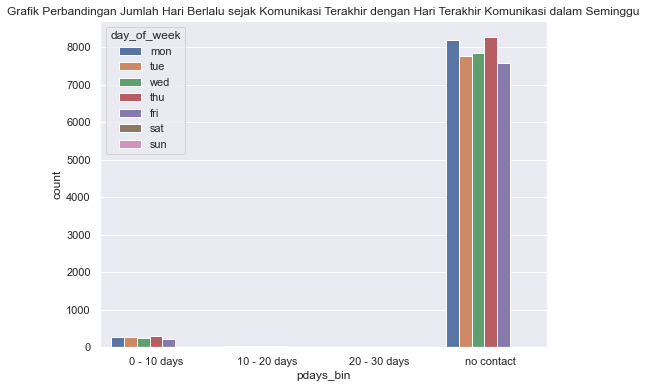

In [493]:
# Visualisasi data Analisis Multivariate antara day_of_week dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu sejak Komunikasi Terakhir dengan Hari Terakhir Komunikasi dalam Seminggu')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi selama kampanye dan dominasi kelompok terakhir dihubungi pada hari Kamis

In [250]:
# Analisis Multivariate antara day_of_week dan previous
(pd.crosstab(index = df['day_of_week'], columns = df['previous'], normalize = 'all')*100).round(2)

previous         0     1     2     3     4     5    6    7
day_of_week                                               
mon          17.88  2.27  0.37  0.10  0.04  0.01  0.0  0.0
tue          16.98  2.11  0.41  0.10  0.03  0.01  0.0  0.0
wed          17.14  2.11  0.33  0.10  0.04  0.02  0.0  0.0
thu          18.07  2.32  0.38  0.11  0.04  0.01  0.0  0.0
fri          16.27  2.26  0.34  0.10  0.03  0.00  0.0  0.0

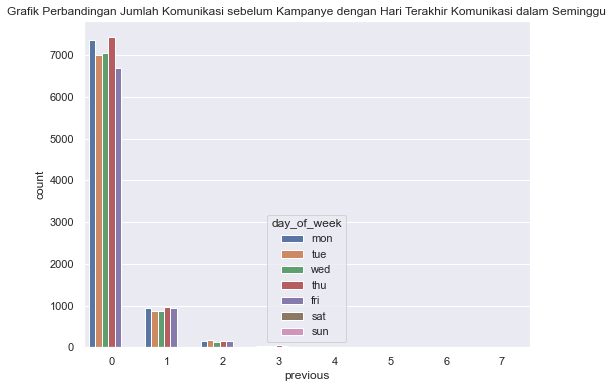

In [494]:
# Visualisasi data Analisis Multivariate antara day_of_week dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Jumlah Komunikasi sebelum Kampanye dengan Hari Terakhir Komunikasi dalam Seminggu')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelum kampanye dan dominasi kelompok terakhir dihubungi pada Hari Kamis

In [251]:
# Analisis Multivariate antara day_of_week dan poutcome
(pd.crosstab(index = df['day_of_week'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome     failure  nonexistent  success
day_of_week                               
mon             2.12        17.88     0.67
tue             1.95        16.98     0.71
wed             1.95        17.14     0.66
thu             2.10        18.07     0.76
fri             2.19        16.27     0.54

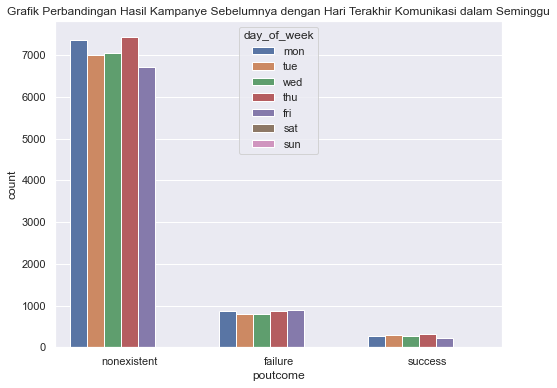

In [495]:
# Visualisasi data Analisis Multivariate antara day_of_week dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Hari Terakhir Komunikasi dalam Seminggu')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil kampanye sebelumnya tidak ada dan dominasi kelompok terakhir dihubungi pada Hari Kamis

In [252]:
# Analisis Multivariate antara day_of_week dan emp.var.rate
(pd.crosstab(index = df['day_of_week'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9  -1.8  -1.7  -1.1  -0.2  -0.1   1.1   1.4
day_of_week                                                             
mon           0.50  0.12  0.84  5.13  0.39  0.35  0.01  1.54  3.33  8.45
tue           0.63  0.06  1.00  3.62  0.44  0.25  0.00  1.75  4.15  7.75
wed           0.49  0.08  0.76  3.87  0.34  0.33  0.00  1.90  4.13  7.84
thu           0.48  0.10  0.70  5.06  0.39  0.35  0.00  2.05  3.20  8.59
fri           0.51  0.05  0.74  4.62  0.32  0.25  0.01  1.70  4.03  6.78

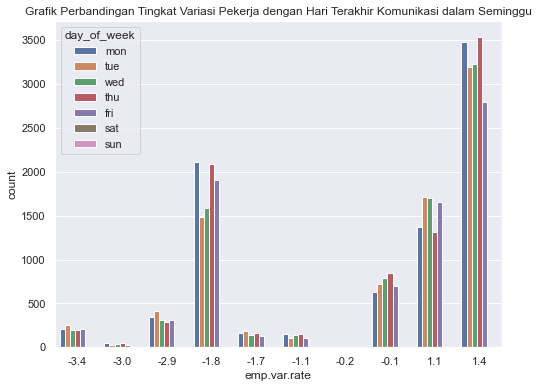

In [496]:
# Visualisasi data Analisis Multivariate antara day_of_week dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerja dengan Hari Terakhir Komunikasi dalam Seminggu')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerja sebesar 1.4 dan dominasi kelompok terakhir dihubungi pada hari Kamis

In [253]:
# Analisis Multivariate antara day_of_week dan cons.price.idx
(pd.crosstab(index = df['day_of_week'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
day_of_week                                                              
mon               0.32    0.08    0.14    0.04    0.27    0.12    0.01   
tue               0.38    0.18    0.25    0.12    0.19    0.06    0.00   
wed               0.35    0.12    0.20    0.11    0.17    0.08    0.00   
thu               0.40    0.08    0.28    0.10    0.11    0.10    0.00   
fri               0.42    0.18    0.21    0.07    0.12    0.05    0.01   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
day_of_week                                                              
mon               0.18    3.00    0.49    1.60    1.50    0.17    2.52   
tue               0.17    2.59    0.50    0.53    1.71    0.17    2.64   
wed               0.09    2.86    0.30    0.69    1.88    0.08    2.56   
thu               0.12    2.83    0.20    1.73    2.03    0.12    2.76   
fri               0.12    2.79    0.25    1.42    1.66    0.10    2.08   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
day_of_week                                                              
mon               0.11    0.03    0.08    3.50    3.33    0.13    0.12   
tue               0.08    0.04    0.08    3.42    4.15    0.13    0.17   
wed               0.04    0.03    0.11    3.33    4.13    0.11    0.13   
thu               0.13    0.02    0.13    3.76    3.20    0.11    0.07   
fri               0.06    0.04    0.12    2.23    4.03    0.09    0.06   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
day_of_week                                             
mon               0.13    0.15    2.44    0.14    0.08  
tue               0.10    0.14    1.68    0.07    0.08  
wed               0.18    0.10    1.95    0.10    0.05  
thu               0.21    0.20    2.08    0.09    0.05  
fri               0.10    0.16    2.47    0.10    0.05

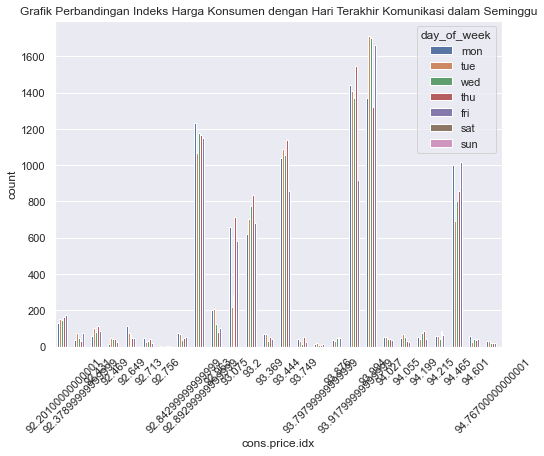

In [498]:
# Visualisasi data Analisis Multivariate antara day_of_week dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Hari Terakhir Komunikasi dalam Seminggu')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok terakhir komunikasi dengan tim kampanye pada hari Selasa

In [254]:
# Analisis Multivariate antara day_of_week dan cons.conf.idx
(pd.crosstab(index = df['day_of_week'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
day_of_week                                                                    
mon             0.08   0.18   0.14   1.60   3.00   0.01   3.50   1.50   2.44   
tue             0.08   0.17   0.07   0.53   2.59   0.00   3.42   1.71   1.68   
wed             0.05   0.09   0.10   0.69   2.86   0.00   3.33   1.88   1.95   
thu             0.05   0.12   0.09   1.73   2.83   0.00   3.76   2.03   2.08   
fri             0.05   0.12   0.10   1.42   2.79   0.01   2.23   1.66   2.47   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
day_of_week                                                                    
mon             0.49   0.03   0.15   0.08   0.12   0.13   0.13   3.33   2.52   
tue             0.50   0.04   0.14   0.08   0.17   0.13   0.10   4.15   2.64   
wed             0.30   0.03   0.10   0.11   0.13   0.11   0.18   4.13   2.56   
thu             0.20   0.02   0.20   0.13   0.07   0.11   0.21   3.20   2.76   
fri             0.25   0.04   0.16   0.12   0.06   0.09   0.10   4.03   2.08   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
day_of_week                                                            
mon             0.17   0.11   0.04   0.12   0.32   0.27   0.08   0.14  
tue             0.17   0.08   0.12   0.06   0.38   0.19   0.18   0.25  
wed             0.08   0.04   0.11   0.08   0.35   0.17   0.12   0.20  
thu             0.12   0.13   0.10   0.10   0.40   0.11   0.08   0.28  
fri             0.10   0.06   0.07   0.05   0.42   0.12   0.18   0.21

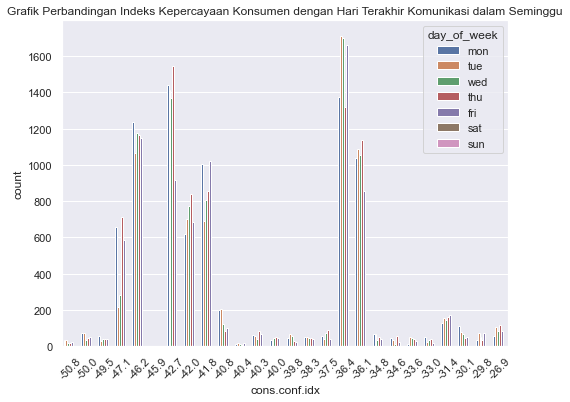

In [499]:
# Visualisasi data Analisis Multivariate antara day_of_week dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Hari Terakhir Komunikasi dalam Seminggu')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok terakhir dihubungi tim kampanye pada hari Selasa

In [255]:
# Analisis Multivariate antara day_of_week dan euribor3m
(pd.crosstab(index = df['day_of_week'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin      0 - 1  1 - 2  3 - 4     >4
day_of_week                            
mon           1.94   5.40   0.01  13.32
tue           2.01   3.98   0.00  13.65
wed           1.75   4.13   0.00  13.87
thu           2.03   5.05   0.01  13.84
fri           1.76   4.72   0.01  12.51

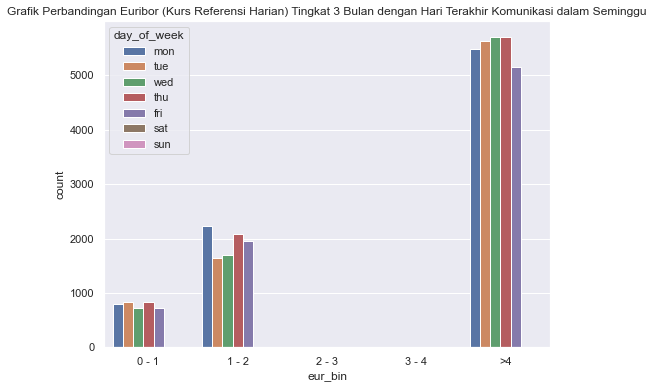

In [501]:
# Visualisasi data Analisis Multivariate antara day_of_week dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Hari Terakhir Komunikasi dalam Seminggu')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor lebih besar dari 4 dan kelompok didominasi hari terakhir komunikasi pada Hari Rabu

In [256]:
# Analisis Multivariate antara day_of_week dan nr.employed
(pd.crosstab(index = df['day_of_week'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
day_of_week                                                                   
mon            0.35    0.39    0.36    0.50    0.12    0.84    4.77    0.01   
tue            0.25    0.44    0.32    0.63    0.06    1.00    3.29    0.00   
wed            0.33    0.34    0.23    0.49    0.08    0.76    3.64    0.00   
thu            0.35    0.39    0.38    0.48    0.10    0.70    4.68    0.00   
fri            0.25    0.32    0.28    0.51    0.05    0.74    4.33    0.01   

nr.employed  5191.0  5195.8  5228.1  
day_of_week                          
mon            3.33    1.54    8.45  
tue            4.15    1.75    7.75  
wed            4.13    1.90    7.84  
thu            3.20    2.05    8.59  
fri            4.03    1.70    6.78

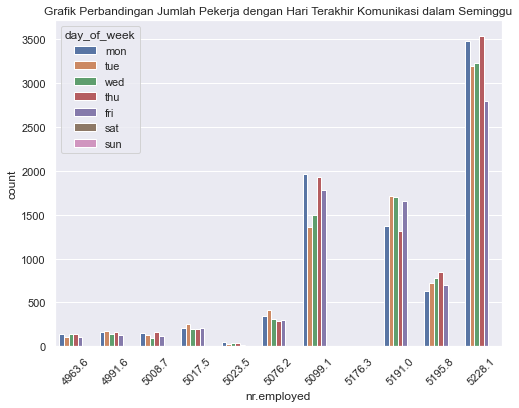

In [502]:
# Visualisasi data Analisis Multivariate antara day_of_week dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'day_of_week')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Hari Terakhir Komunikasi dalam Seminggu')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanyak 5228 orang dan kelompok didominasi hari terakhir komunikasi dalam seminggu pada hari Kamis

### Analisis Multivariate terhadap Duration

In [257]:
# Analisis Multivariate antara duration dan campaign
(pd.crosstab(index = df['dur_bin'], columns = df['cam_bin'], normalize = 'all')*100).round(2)

cam_bin           0 - 10 times  10 - 20 times  20 - 30 times  30 - 40 times  \
dur_bin                                                                       
0 - 10 min               89.59           1.63           0.29           0.07   
10 - 30 min               8.06           0.10           0.01           0.00   
30 - 60 min               0.23           0.00           0.00           0.00   
more than 1 hour          0.01           0.00           0.00           0.00   

cam_bin           40-50 times  more than 50 times  
dur_bin                                            
0 - 10 min               0.01                 0.0  
10 - 30 min              0.00                 0.0  
30 - 60 min              0.00                 0.0  
more than 1 hour         0.00                 0.0

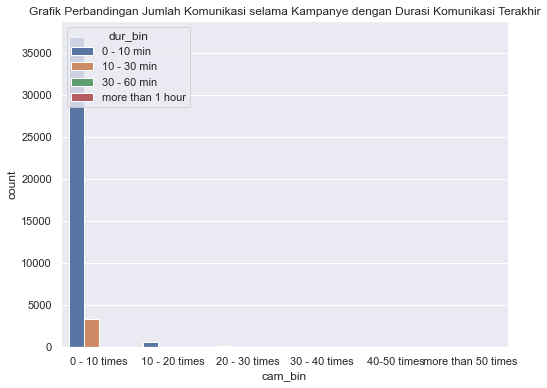

In [505]:
# Visualisasi data Analisis Multivariate antara duration dan campaign
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Jumlah Komunikasi selama Kampanye dengan Durasi Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah komunikasi selama kampanye pada rentang 0 - 10 kali dan kelompok didominasi durasi panggilan pada rentang 0 - 10 menit

In [258]:
# Analisis Multivariate antara duration dan pdays
(pd.crosstab(index = df['dur_bin'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin         0 - 10 days  10 - 20 days  20 - 30 days  no contact
dur_bin                                                              
0 - 10 min               2.81          0.40          0.02       88.36
10 - 30 min              0.33          0.08          0.00        7.76
30 - 60 min              0.01          0.00          0.00        0.23
more than 1 hour         0.00          0.00          0.00        0.01

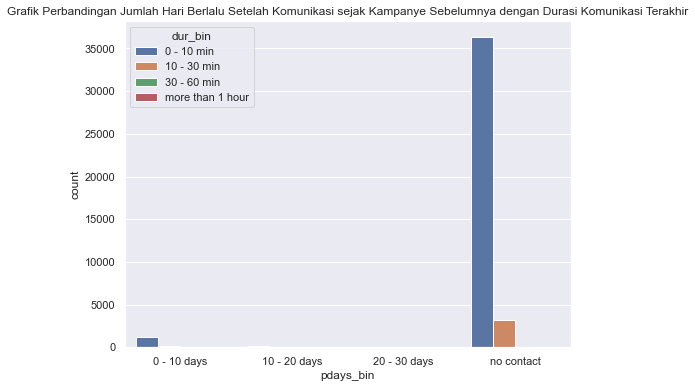

In [506]:
# Visualisasi data Analisis Multivariate antara duration dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu Setelah Komunikasi sejak Kampanye Sebelumnya dengan Durasi Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sejak kampanye sebelumnya dan dominasi kelompok dengan durasi panggilan pada rentang 0 - 10 menit

In [259]:
# Analisis Multivariate antara duration dan previous
(pd.crosstab(index = df['dur_bin'], columns = df['previous'], normalize = 'all')*100).round(2)

previous              0      1     2     3     4     5     6    7
dur_bin                                                          
0 - 10 min        79.03  10.23  1.64  0.48  0.16  0.04  0.01  0.0
10 - 30 min        7.08   0.83  0.19  0.05  0.01  0.00  0.00  0.0
30 - 60 min        0.22   0.01  0.00  0.00  0.00  0.00  0.00  0.0
more than 1 hour   0.01   0.00  0.00  0.00  0.00  0.00  0.00  0.0

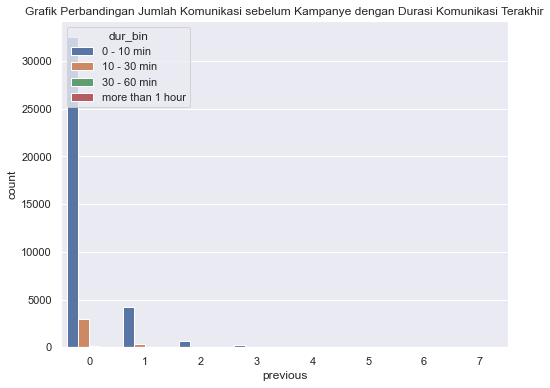

In [507]:
# Visualisasi data Analisis Multivariate antara duration dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Jumlah Komunikasi sebelum Kampanye dengan Durasi Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelum kampanye dan dominasi kelompok dengan durasi komunikasi pada rentang 0 - 10 menit

In [260]:
# Analisis Multivariate antara duration dan poutcome
(pd.crosstab(index = df['dur_bin'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome          failure  nonexistent  success
dur_bin                                        
0 - 10 min           9.59        79.03     2.97
10 - 30 min          0.72         7.08     0.36
30 - 60 min          0.01         0.22     0.01
more than 1 hour     0.00         0.01     0.00

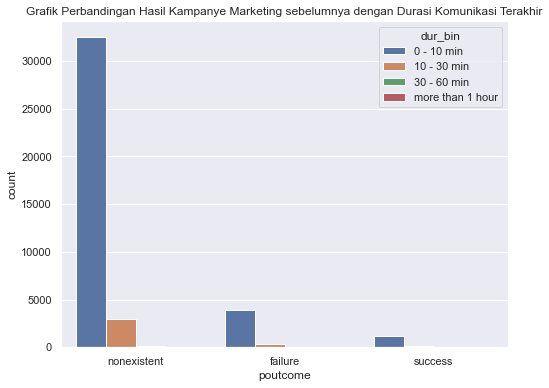

In [508]:
# Visualisasi data Analisis Multivariate antara duration dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Hasil Kampanye Marketing sebelumnya dengan Durasi Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil kampanye marketing sebelumnya berupa tidak ada dan kelompok didominasi kelompok dengan rentang durasi panggilan terakhir 0 - 10 menit

In [261]:
# Analisis Multivariate antara duration dan emp.var.rate
(pd.crosstab(index = df['dur_bin'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate      -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1  \
dur_bin                                                                    
0 - 10 min        2.38  0.36  3.80  20.34  1.68  1.37  0.02  8.21  17.38   
10 - 30 min       0.21  0.05  0.23   1.90  0.19  0.17  0.00  0.70   1.43   
30 - 60 min       0.01  0.00  0.00   0.06  0.00  0.00  0.00  0.03   0.03   
more than 1 hour  0.00  0.00  0.00   0.00  0.00  0.00  0.00  0.00   0.00   

emp.var.rate        1.4  
dur_bin                  
0 - 10 min        36.03  
10 - 30 min        3.29  
30 - 60 min        0.09  
more than 1 hour   0.00

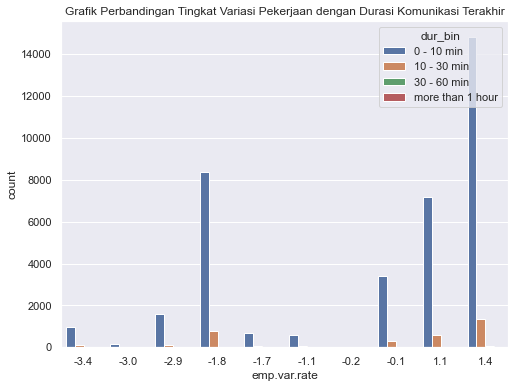

In [509]:
# Visualisasi data Analisis Multivariate antara duration dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Durasi Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan kelompok didominasi rentang durasi panggilan terakhir 0 - 10 menit

In [262]:
# Analisis Multivariate antara duration dan cons.price.idx
(pd.crosstab(index = df['dur_bin'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx    92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
dur_bin                                                                    
0 - 10 min          1.77    0.59    0.99    0.39    0.80    0.36    0.02   
10 - 30 min         0.10    0.05    0.10    0.04    0.06    0.05    0.00   
30 - 60 min         0.00    0.00    0.00    0.00    0.00    0.00    0.00   
more than 1 hour    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx    92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
dur_bin                                                                    
0 - 10 min          0.66   12.89    1.64    5.35    8.07    0.60   11.70   
10 - 30 min         0.02    1.15    0.09    0.60    0.69    0.03    0.83   
30 - 60 min         0.00    0.03    0.00    0.02    0.02    0.00    0.03   
more than 1 hour    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx    93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
dur_bin                                                                    
0 - 10 min          0.37    0.15    0.46   14.52   17.38    0.52    0.49   
10 - 30 min         0.05    0.01    0.05    1.67    1.43    0.04    0.06   
30 - 60 min         0.00    0.01    0.00    0.04    0.03    0.00    0.00   
more than 1 hour    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx    94.199  94.215  94.465  94.601  94.767  
dur_bin                                                   
0 - 10 min          0.64    0.67    9.81    0.44    0.28  
10 - 30 min         0.09    0.08    0.78    0.05    0.02  
30 - 60 min         0.00    0.00    0.03    0.00    0.00  
more than 1 hour    0.00    0.00    0.00    0.00    0.00

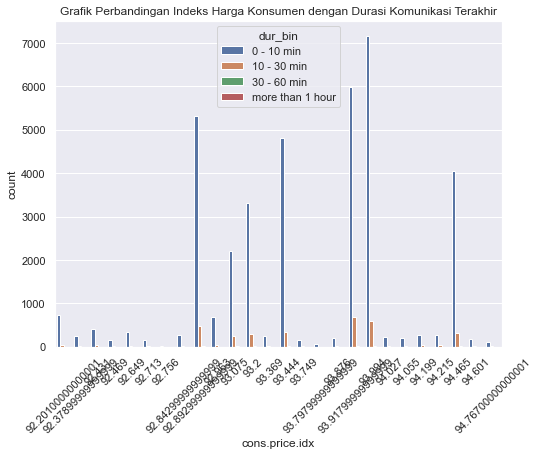

In [511]:
# Visualisasi data Analisis Multivariate antara duration dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Durasi Komunikasi Terakhir')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok pada panggilan terakhir pada rentang 0 - 10 menit

In [263]:
# Analisis Multivariate antara duration dan cons.conf.idx
(pd.crosstab(index = df['dur_bin'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx     -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  \
dur_bin                                                                    
0 - 10 min         0.28   0.66   0.44   5.35  12.89   0.02  14.52   8.07   
10 - 30 min        0.02   0.02   0.05   0.60   1.15   0.00   1.67   0.69   
30 - 60 min        0.00   0.00   0.00   0.02   0.03   0.00   0.04   0.02   
more than 1 hour   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx     -41.8  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  \
dur_bin                                                                    
0 - 10 min         9.81   1.64   0.15   0.67   0.46   0.49   0.52   0.64   
10 - 30 min        0.78   0.09   0.01   0.08   0.05   0.06   0.04   0.09   
30 - 60 min        0.03   0.00   0.01   0.00   0.00   0.00   0.00   0.00   
more than 1 hour   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx     -36.4  -36.1  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  \
dur_bin                                                                    
0 - 10 min        17.38  11.70   0.60   0.37   0.39   0.36   1.77   0.80   
10 - 30 min        1.43   0.83   0.03   0.05   0.04   0.05   0.10   0.06   
30 - 60 min        0.03   0.03   0.00   0.00   0.00   0.00   0.00   0.00   
more than 1 hour   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx     -29.8  -26.9  
dur_bin                         
0 - 10 min         0.59   0.99  
10 - 30 min        0.05   0.10  
30 - 60 min        0.00   0.00  
more than 1 hour   0.00   0.00

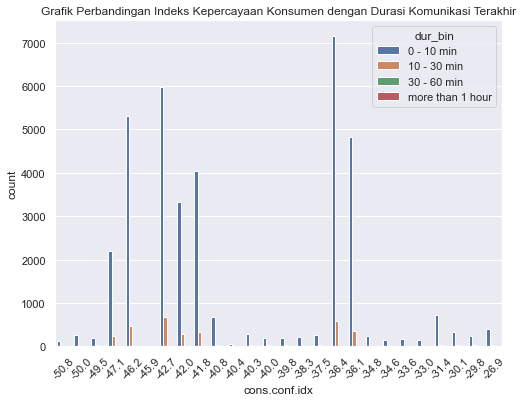

In [513]:
# Visualisasi data Analisis Multivariate antara duration dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Durasi Komunikasi Terakhir')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok dengan durasi panggilan terakhir pada rentang 0 - 10 menit

In [264]:
# Analisis Multivariate antara duration dan euribor3m
(pd.crosstab(index = df['dur_bin'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin           0 - 1  1 - 2  3 - 4     >4
dur_bin                                     
0 - 10 min         8.67  21.28   0.03  61.61
10 - 30 min        0.80   1.95   0.00   5.42
30 - 60 min        0.02   0.06   0.00   0.16
more than 1 hour   0.00   0.00   0.00   0.01

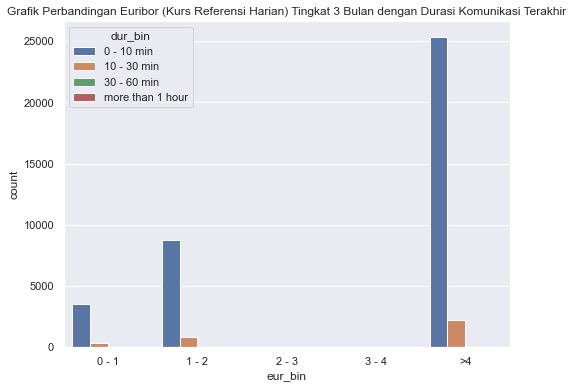

In [514]:
# Visualisasi data Analisis Multivariate antara duration dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Durasi Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor (kurs referensi harian) tingkat 3 bulan lebih besar dari 4 dan kelompok didominasi durasi panggi;lan terakhir pada rentang 0 - 10 menit

In [265]:
# Analisis Multivariate antara duration dan nr.employed
(pd.crosstab(index = df['dur_bin'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed       4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  \
dur_bin                                                                    
0 - 10 min          1.37    1.68    1.44    2.38    0.36    3.80   18.90   
10 - 30 min         0.17    0.19    0.13    0.21    0.05    0.23    1.77   
30 - 60 min         0.00    0.00    0.00    0.01    0.00    0.00    0.05   
more than 1 hour    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

nr.employed       5176.3  5191.0  5195.8  5228.1  
dur_bin                                           
0 - 10 min          0.02   17.38    8.21   36.03  
10 - 30 min         0.00    1.43    0.70    3.29  
30 - 60 min         0.00    0.03    0.03    0.09  
more than 1 hour    0.00    0.00    0.00    0.00

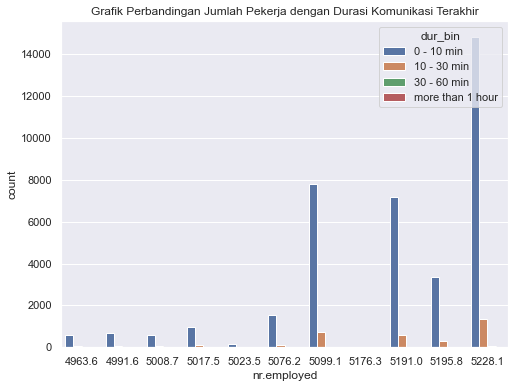

In [515]:
# Visualisasi data Analisis Multivariate antara duration dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'dur_bin')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Durasi Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanyak 5228 orang dan dominasi kelompok dengan durasi panggilan terakhir pada rentang 0 - 10 menit

### Analisis Multivariate terhadap Campaign

In [266]:
# Analisis Multivariate antara campaign dan pdays
(pd.crosstab(index = df['cam_bin'], columns = df['pdays_bin'], normalize = 'all')*100).round(2)

pdays_bin           0 - 10 days  10 - 20 days  20 - 30 days  no contact
cam_bin                                                                
0 - 10 times               3.15          0.47          0.02       94.25
10 - 20 times              0.00          0.00          0.00        1.72
20 - 30 times              0.00          0.00          0.00        0.30
30 - 40 times              0.00          0.00          0.00        0.07
40-50 times                0.00          0.00          0.00        0.01
more than 50 times         0.00          0.00          0.00        0.00

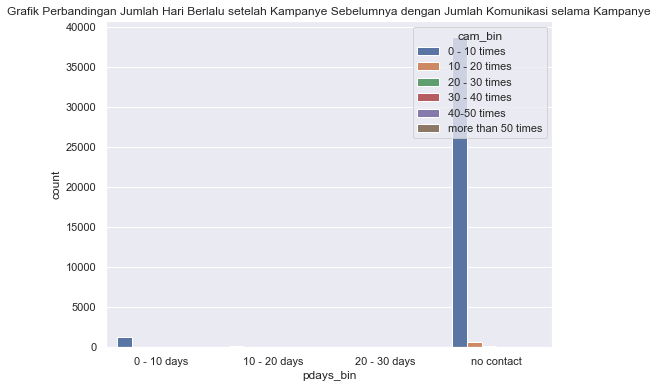

In [517]:
# Visualisasi data Analisis Multivariate antara campaign dan pdays
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu setelah Kampanye Sebelumnya dengan Jumlah Komunikasi selama Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi setelah kampanye sebelumnya dan dominasi kelompok dengan jumlah komunikasi selama kampanye pada rentang 0 - 10 kali

In [267]:
# Analisis Multivariate antara campaign dan previous
(pd.crosstab(index = df['cam_bin'], columns = df['previous'], normalize = 'all')*100).round(2)

previous                0      1     2     3     4     5     6    7
cam_bin                                                            
0 - 10 times        84.26  11.06  1.83  0.52  0.17  0.04  0.01  0.0
10 - 20 times        1.71   0.02  0.00  0.00  0.00  0.00  0.00  0.0
20 - 30 times        0.30   0.00  0.00  0.00  0.00  0.00  0.00  0.0
30 - 40 times        0.07   0.00  0.00  0.00  0.00  0.00  0.00  0.0
40-50 times          0.01   0.00  0.00  0.00  0.00  0.00  0.00  0.0
more than 50 times   0.00   0.00  0.00  0.00  0.00  0.00  0.00  0.0

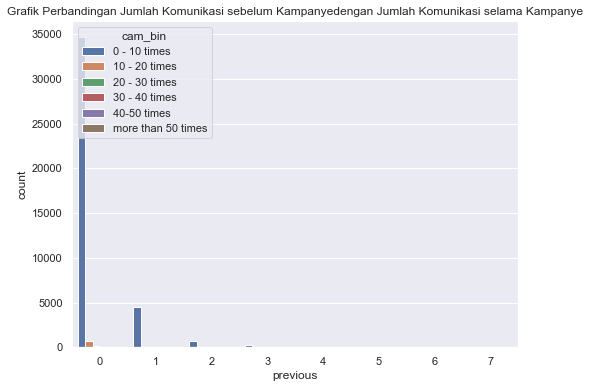

In [518]:
# Visualisasi data Analisis Multivariate antara campaign dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Jumlah Komunikasi sebelum Kampanyedengan Jumlah Komunikasi selama Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelum kampanye dan dominasi kelompok dengan jumlah komunikasi selama kammpanye pada rentang 0 - 10 kali

In [268]:
# Analisis Multivariate antara campaign dan poutcome
(pd.crosstab(index = df['cam_bin'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome            failure  nonexistent  success
cam_bin                                          
0 - 10 times          10.30        84.26     3.33
10 - 20 times          0.02         1.71     0.00
20 - 30 times          0.00         0.30     0.00
30 - 40 times          0.00         0.07     0.00
40-50 times            0.00         0.01     0.00
more than 50 times     0.00         0.00     0.00

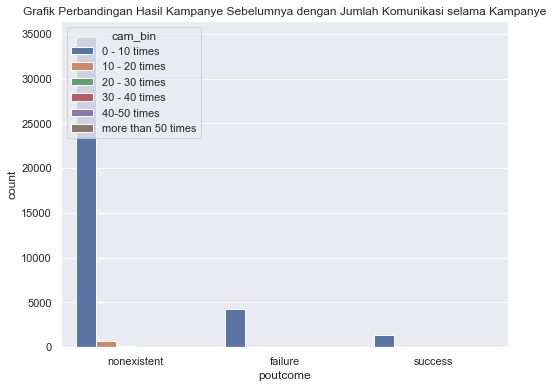

In [519]:
# Visualisasi data Analisis Multivariate antara campaign dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Jumlah Komunikasi selama Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil kampanye sebelumnya berupa tidak ada dan dominasi kelompok dengan jumlah komunikasi selama kampanye pada rentang 0 - 10 kali

In [269]:
# Analisis Multivariate antara campaign dan emp.var.rate
(pd.crosstab(index = df['cam_bin'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate        -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1  \
cam_bin                                                                      
0 - 10 times         2.6  0.42  4.03  22.19  1.87  1.54  0.02  8.94  18.49   
10 - 20 times        0.0  0.00  0.01   0.11  0.00  0.00  0.00  0.00   0.30   
20 - 30 times        0.0  0.00  0.00   0.00  0.00  0.00  0.00  0.00   0.04   
30 - 40 times        0.0  0.00  0.00   0.00  0.00  0.00  0.00  0.00   0.01   
40-50 times          0.0  0.00  0.00   0.00  0.00  0.00  0.00  0.00   0.00   
more than 50 times   0.0  0.00  0.00   0.00  0.00  0.00  0.00  0.00   0.00   

emp.var.rate          1.4  
cam_bin                    
0 - 10 times        37.79  
10 - 20 times        1.30  
20 - 30 times        0.26  
30 - 40 times        0.06  
40-50 times          0.01  
more than 50 times   0.00

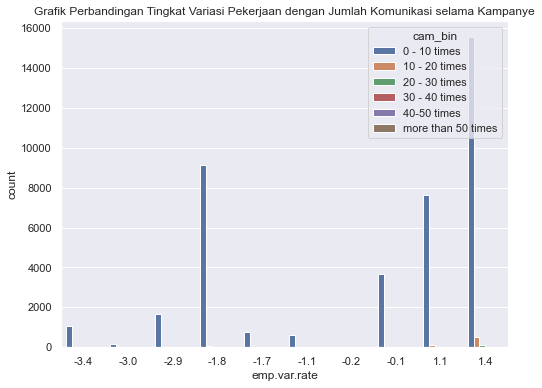

In [520]:
# Visualisasi data Analisis Multivariate antara campaign dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Jumlah Komunikasi selama Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan dominasi kelompok dengan jumlah komunikasi selama kampanye pada rentang 0 - 10 kali

In [270]:
# Analisis Multivariate antara campaign dan cons.price.idx
(pd.crosstab(index = df['cam_bin'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx      92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
cam_bin                                                                      
0 - 10 times          1.86    0.65    1.09    0.43    0.87    0.42    0.02   
10 - 20 times         0.00    0.00    0.00    0.00    0.00    0.00    0.00   
20 - 30 times         0.00    0.00    0.00    0.00    0.00    0.00    0.00   
30 - 40 times         0.00    0.00    0.00    0.00    0.00    0.00    0.00   
40-50 times           0.00    0.00    0.00    0.00    0.00    0.00    0.00   
more than 50 times    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx      92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
cam_bin                                                                      
0 - 10 times          0.67   14.00    1.73    5.94    8.78    0.64   12.21   
10 - 20 times         0.02    0.07    0.00    0.02    0.00    0.00    0.34   
20 - 30 times         0.00    0.00    0.00    0.00    0.00    0.00    0.01   
30 - 40 times         0.00    0.00    0.00    0.00    0.00    0.00    0.00   
40-50 times           0.00    0.00    0.00    0.00    0.00    0.00    0.00   
more than 50 times    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx      93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
cam_bin                                                                      
0 - 10 times          0.42    0.16    0.51   15.51   18.49    0.56    0.56   
10 - 20 times         0.00    0.00    0.00    0.56    0.30    0.00    0.00   
20 - 30 times         0.00    0.00    0.00    0.13    0.04    0.00    0.00   
30 - 40 times         0.00    0.00    0.00    0.04    0.01    0.00    0.00   
40-50 times           0.00    0.00    0.00    0.00    0.00    0.00    0.00   
more than 50 times    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx      94.199  94.215  94.465  94.601  94.767  
cam_bin                                                     
0 - 10 times          0.74    0.75   10.07     0.5    0.31  
10 - 20 times         0.00    0.00    0.41     0.0    0.00  
20 - 30 times         0.00    0.00    0.12     0.0    0.00  
30 - 40 times         0.00    0.00    0.02     0.0    0.00  
40-50 times           0.00    0.00    0.00     0.0    0.00  
more than 50 times    0.00    0.00    0.00     0.0    0.00

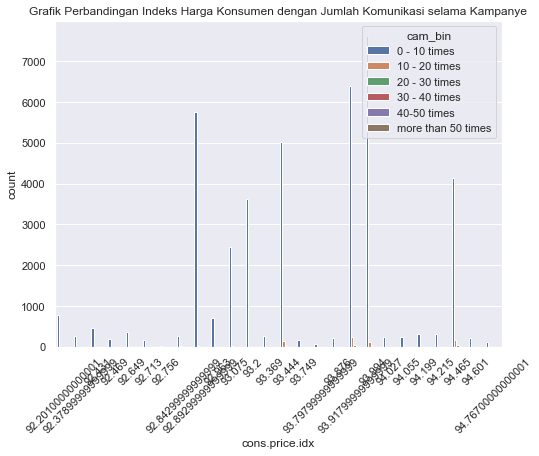

In [522]:
# Visualisasi data Analisis Multivariate antara campaign dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Jumlah Komunikasi selama Kampanye')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok dihubungi sebanyak 0 - 10 kali selama kampanye

In [271]:
# Analisis Multivariate antara campaign dan cons.conf.idx
(pd.crosstab(index = df['cam_bin'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx       -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  \
cam_bin                                                                      
0 - 10 times         0.31   0.67    0.5   5.94  14.00   0.02  15.51   8.78   
10 - 20 times        0.00   0.02    0.0   0.02   0.07   0.00   0.56   0.00   
20 - 30 times        0.00   0.00    0.0   0.00   0.00   0.00   0.13   0.00   
30 - 40 times        0.00   0.00    0.0   0.00   0.00   0.00   0.04   0.00   
40-50 times          0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   
more than 50 times   0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx       -41.8  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  \
cam_bin                                                                      
0 - 10 times        10.07   1.73   0.16   0.75   0.51   0.56   0.56   0.74   
10 - 20 times        0.41   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
20 - 30 times        0.12   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
30 - 40 times        0.02   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
40-50 times          0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
more than 50 times   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx       -36.4  -36.1  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  \
cam_bin                                                                      
0 - 10 times        18.49  12.21   0.64   0.42   0.43   0.42   1.86   0.87   
10 - 20 times        0.30   0.34   0.00   0.00   0.00   0.00   0.00   0.00   
20 - 30 times        0.04   0.01   0.00   0.00   0.00   0.00   0.00   0.00   
30 - 40 times        0.01   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
40-50 times          0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
more than 50 times   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx       -29.8  -26.9  
cam_bin                           
0 - 10 times         0.65   1.09  
10 - 20 times        0.00   0.00  
20 - 30 times        0.00   0.00  
30 - 40 times        0.00   0.00  
40-50 times          0.00   0.00  
more than 50 times   0.00   0.00

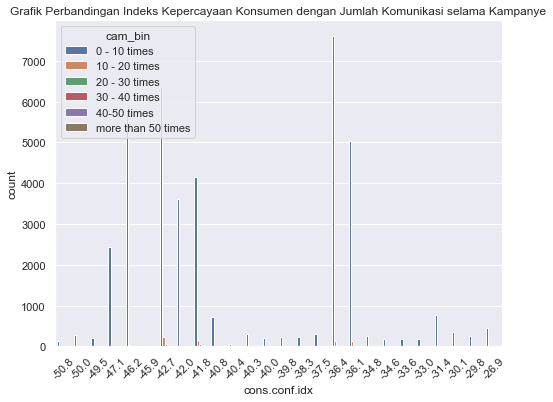

In [524]:
# Visualisasi data Analisis Multivariate antara campaign dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Jumlah Komunikasi selama Kampanye')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok dengan durasi komunikasi selama kampanye sebanyak 0 - 10 kali

In [272]:
# Analisis Multivariate antara campaign dan euribor3m
(pd.crosstab(index = df['cam_bin'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin             0 - 1  1 - 2  3 - 4     >4
cam_bin                                       
0 - 10 times         9.48  23.17   0.03  65.21
10 - 20 times        0.01   0.11   0.00   1.61
20 - 30 times        0.00   0.00   0.00   0.30
30 - 40 times        0.00   0.00   0.00   0.07
40-50 times          0.00   0.00   0.00   0.01
more than 50 times   0.00   0.00   0.00   0.00

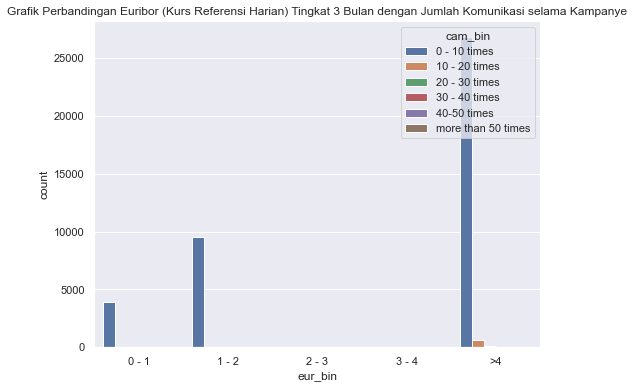

In [525]:
# Visualisasi data Analisis Multivariate antara campaign dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Jumlah Komunikasi selama Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor (kurs referensi harian) tingkat 3 bulan lebih besar dari 4 dan dominasi kelompok dihubungi sebanyak 0 - 10 kali selama kampanye

In [273]:
# Analisis Multivariate antara campaign dan nr.employed
(pd.crosstab(index = df['cam_bin'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed         4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  \
cam_bin                                                                      
0 - 10 times          1.54    1.87    1.58     2.6    0.42    4.03   20.61   
10 - 20 times         0.00    0.00    0.00     0.0    0.00    0.01    0.11   
20 - 30 times         0.00    0.00    0.00     0.0    0.00    0.00    0.00   
30 - 40 times         0.00    0.00    0.00     0.0    0.00    0.00    0.00   
40-50 times           0.00    0.00    0.00     0.0    0.00    0.00    0.00   
more than 50 times    0.00    0.00    0.00     0.0    0.00    0.00    0.00   

nr.employed         5176.3  5191.0  5195.8  5228.1  
cam_bin                                             
0 - 10 times          0.02   18.49    8.94   37.79  
10 - 20 times         0.00    0.30    0.00    1.30  
20 - 30 times         0.00    0.04    0.00    0.26  
30 - 40 times         0.00    0.01    0.00    0.06  
40-50 times           0.00    0.00    0.00    0.01  
more than 50 times    0.00    0.00    0.00    0.00

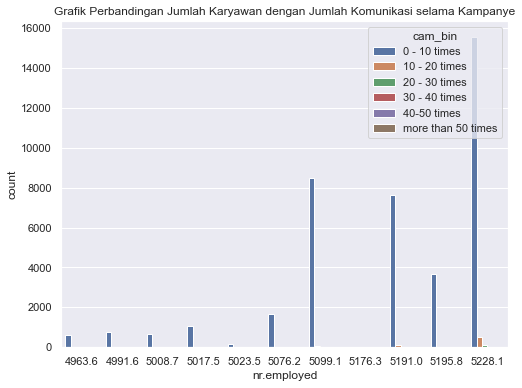

In [526]:
# Visualisasi data Analisis Multivariate antara campaign dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'cam_bin')
plt.title('Grafik Perbandingan Jumlah Karyawan dengan Jumlah Komunikasi selama Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah karyawan sebanyak 5228 orang dan dominasi kelompok dengan durasi jumlah komunikasi selama kampanye sebanyak 0 - 10 kali

### Analisis Multivariate terhadap Pdays

In [274]:
# Analisis Multivariate antara pdays dan previous
(pd.crosstab(index = df['pdays_bin'], columns = df['previous'], normalize = 'all')*100).round(2)

previous          0     1     2     3     4     5     6    7
pdays_bin                                                   
0 - 10 days    0.00  1.77  0.84  0.37  0.12  0.03  0.01  0.0
10 - 20 days   0.00  0.30  0.13  0.03  0.01  0.00  0.00  0.0
20 - 30 days   0.00  0.01  0.00  0.00  0.00  0.00  0.00  0.0
no contact    86.37  8.98  0.85  0.12  0.03  0.00  0.00  0.0

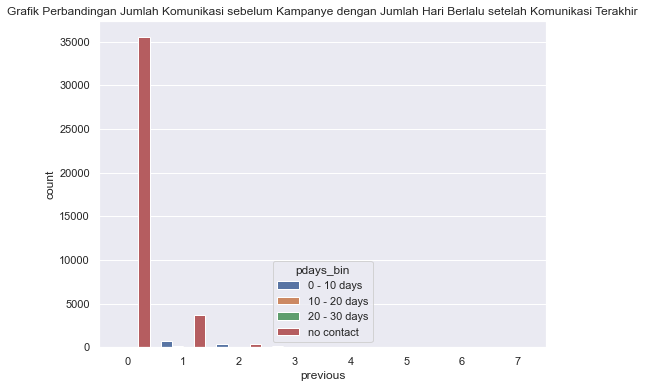

In [527]:
# Visualisasi data Analisis Multivariate antara pdays dan previous
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'pdays_bin')
plt.title('Grafik Perbandingan Jumlah Komunikasi sebelum Kampanye dengan Jumlah Hari Berlalu setelah Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok tanpa komunikasi sebelum kampanye dan dominasi kelompok tanpa komunikasi sejak kampanye sebelumnya

In [275]:
# Analisis Multivariate antara pdays dan poutcome
(pd.crosstab(index = df['pdays_bin'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome      failure  nonexistent  success
pdays_bin                                  
0 - 10 days      0.21         0.00     2.94
10 - 20 days     0.13         0.00     0.35
20 - 30 days     0.01         0.00     0.01
no contact       9.98        86.37     0.00

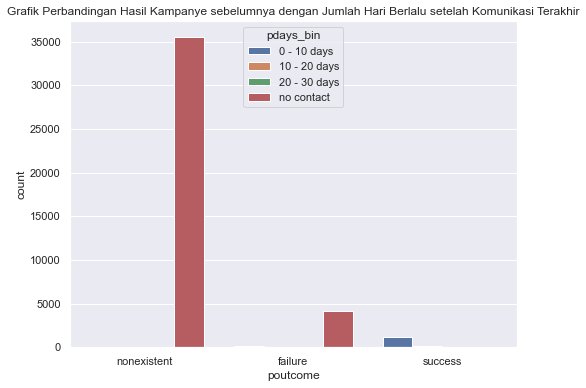

In [528]:
# Visualisasi data Analisis Multivariate antara pdays dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'pdays_bin')
plt.title('Grafik Perbandingan Hasil Kampanye sebelumnya dengan Jumlah Hari Berlalu setelah Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi dengan kelompok hasil kampanye sebelumnya berupa tidak ada dan dominasi kelompok tanpa komunikasi sejak kampanye sebelumnya

In [276]:
# Analisis Multivariate antara pdays dan emp.var.rate
(pd.crosstab(index = df['pdays_bin'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
pdays_bin                                                                  
0 - 10 days   0.58  0.11  0.48   0.91  0.52  0.47  0.00  0.08   0.00   0.00
10 - 20 days  0.01  0.00  0.08   0.18  0.12  0.09  0.00  0.00   0.00   0.00
20 - 30 days  0.00  0.00  0.00   0.00  0.01  0.01  0.00  0.00   0.00   0.00
no contact    2.01  0.31  3.48  21.21  1.21  0.98  0.02  8.86  18.85  39.43

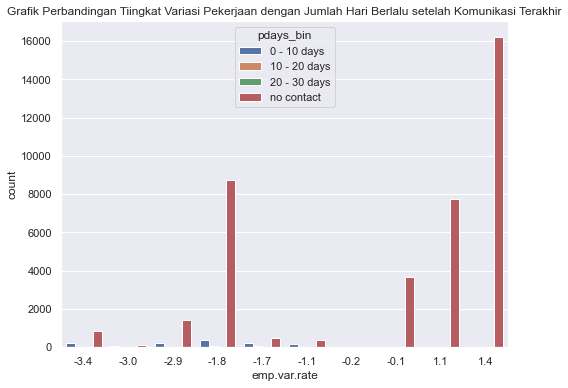

In [529]:
# Visualisasi data Analisis Multivariate antara pdays dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'pdays_bin')
plt.title('Grafik Perbandingan Tiingkat Variasi Pekerjaan dengan Jumlah Hari Berlalu setelah Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan dominasi kelompok tanpa komunikasi sejak kampanye sebelumnya

In [277]:
# Analisis Multivariate antara pdays dan cons.price.idx
(pd.crosstab(index = df['pdays_bin'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
pdays_bin                                                                
0 - 10 days       0.31    0.13    0.18    0.01    0.27    0.11    0.00   
10 - 20 days      0.05    0.01    0.00    0.02    0.00    0.00    0.00   
20 - 30 days      0.00    0.00    0.00    0.00    0.00    0.00    0.00   
no contact        1.51    0.51    0.90    0.40    0.60    0.31    0.02   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
pdays_bin                                                                
0 - 10 days       0.01    0.29    0.17    0.15    0.08    0.18    0.00   
10 - 20 days      0.00    0.10    0.01    0.00    0.00    0.03    0.00   
20 - 30 days      0.00    0.00    0.00    0.00    0.00    0.00    0.00   
no contact        0.68   13.67    1.56    5.81    8.70    0.43   12.57   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
pdays_bin                                                                
0 - 10 days       0.10    0.00    0.18    0.00    0.00    0.17    0.16   
10 - 20 days      0.02    0.00    0.02    0.00    0.00    0.03    0.04   
20 - 30 days      0.00    0.00    0.00    0.00    0.00    0.00    0.00   
no contact        0.31    0.16    0.31   16.24   18.85    0.35    0.36   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
pdays_bin                                               
0 - 10 days       0.22    0.19    0.00    0.15    0.09  
10 - 20 days      0.03    0.06    0.00    0.04    0.01  
20 - 30 days      0.00    0.00    0.00    0.00    0.00  
no contact        0.48    0.50   10.62    0.30    0.20

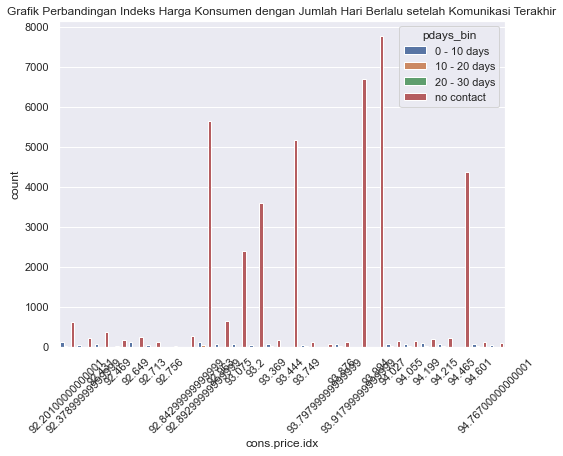

In [531]:
# Visualisasi data Analisis Multivariate antara pdays dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'pdays_bin')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Jumlah Hari Berlalu setelah Komunikasi Terakhir')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok tanpa komunikasi sejak kampanye sebelumnya

In [278]:
# Analisis Multivariate antara pdays dan cons.conf.idx
(pd.crosstab(index = df['pdays_bin'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
pdays_bin                                                                      
0 - 10 days     0.09   0.01   0.15   0.15   0.29   0.00   0.00   0.08   0.00   
10 - 20 days    0.01   0.00   0.04   0.00   0.10   0.00   0.00   0.00   0.00   
20 - 30 days    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
no contact      0.20   0.68   0.30   5.81  13.67   0.02  16.24   8.70  10.62   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
pdays_bin                                                                      
0 - 10 days     0.17   0.00   0.19   0.18   0.16   0.17   0.22   0.00   0.00   
10 - 20 days    0.01   0.00   0.06   0.02   0.04   0.03   0.03   0.00   0.00   
20 - 30 days    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
no contact      1.56   0.16   0.50   0.31   0.36   0.35   0.48  18.85  12.57   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
pdays_bin                                                              
0 - 10 days     0.18   0.10   0.01   0.11   0.31   0.27   0.13   0.18  
10 - 20 days    0.03   0.02   0.02   0.00   0.05   0.00   0.01   0.00  
20 - 30 days    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
no contact      0.43   0.31   0.40   0.31   1.51   0.60   0.51   0.90

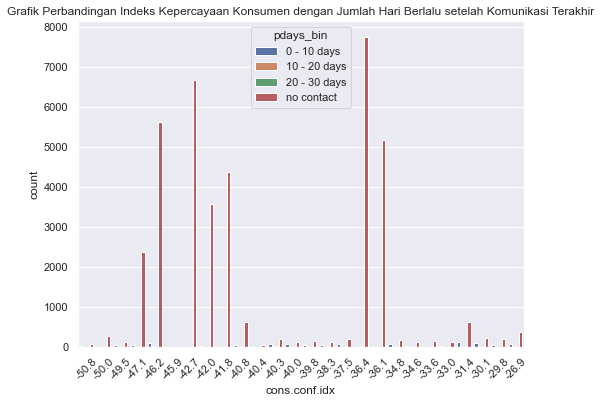

In [533]:
# Visualisasi data Analisis Multivariate antara pdays dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'pdays_bin')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Jumlah Hari Berlalu setelah Komunikasi Terakhir')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok tanpa komunikasi sejak kampanye sebelumnya

In [279]:
# Analisis Multivariate antara pdays dan euribor3m
(pd.crosstab(index = df['pdays_bin'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin       0 - 1  1 - 2  3 - 4     >4
pdays_bin                               
0 - 10 days    2.28   0.79   0.00   0.08
10 - 20 days   0.31   0.17   0.00   0.00
20 - 30 days   0.02   0.00   0.00   0.00
no contact     6.87  22.32   0.03  67.13

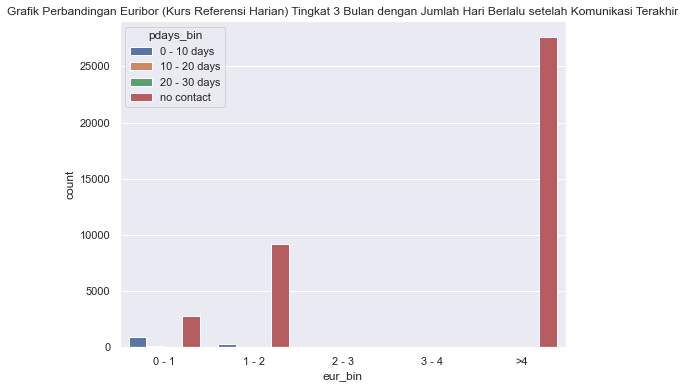

In [534]:
# Visualisasi data Analisis Multivariate antara pdays dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'pdays_bin')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Jumlah Hari Berlalu setelah Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor lebih besar dari 4 dan dominasi kelompok tanpa komunikasi sejak kampanye sebelumnya

In [280]:
# Analisis Multivariate antara pdays dan nr.employed
(pd.crosstab(index = df['pdays_bin'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed   4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
pdays_bin                                                                      
0 - 10 days     0.47    0.52    0.46    0.58    0.11    0.48    0.45    0.00   
10 - 20 days    0.09    0.12    0.07    0.01    0.00    0.08    0.11    0.00   
20 - 30 days    0.01    0.01    0.00    0.00    0.00    0.00    0.00    0.00   
no contact      0.98    1.21    1.05    2.01    0.31    3.48   20.16    0.02   

nr.employed   5191.0  5195.8  5228.1  
pdays_bin                             
0 - 10 days     0.00    0.08    0.00  
10 - 20 days    0.00    0.00    0.00  
20 - 30 days    0.00    0.00    0.00  
no contact     18.85    8.86   39.43

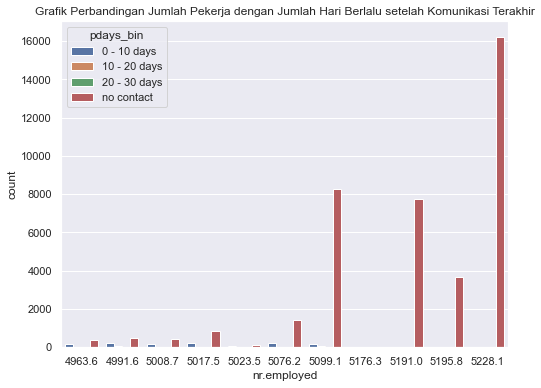

In [535]:
# Visualisasi data Analisis Multivariate antara pdays dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'pdays_bin')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Jumlah Hari Berlalu setelah Komunikasi Terakhir')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanyak 5228 orang dan dominasi kelompok tanpa komunikasi sejak kampanye sebelumnya

### Analisis Multivariate terhadap Previous

In [281]:
# Analisis Multivariate antara previous dan poutcome
(pd.crosstab(index = df['previous'], columns = df['poutcome'], normalize = 'all')*100).round(2)

poutcome  failure  nonexistent  success
previous                               
0            0.00        86.34     0.00
1            8.97         0.00     2.10
2            1.05         0.00     0.78
3            0.21         0.00     0.31
4            0.07         0.00     0.10
5            0.01         0.00     0.04
6            0.00         0.00     0.01
7            0.00         0.00     0.00

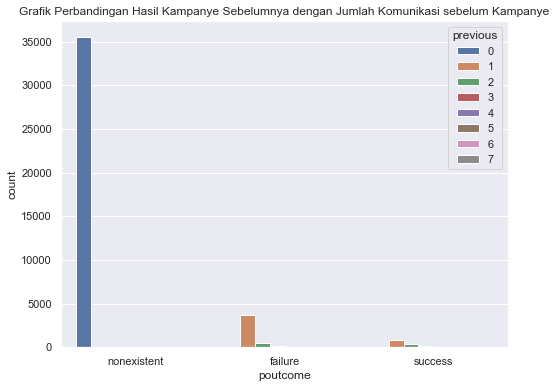

In [537]:
# Visualisasi data Analisis Multivariate antara previous dan poutcome
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'previous')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Jumlah Komunikasi sebelum Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan hasil kampanye sebelumnya berupa tidak ada dan dominasi kelompok tanpa komunikasi sebelum kampanye

In [282]:
# Analisis Multivariate antara previous dan emp.var.rate
(pd.crosstab(index = df['previous'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
previous                                                                   
0             1.44  0.22  2.69  15.15  0.79  0.61  0.02  7.16  18.85  39.41
1             0.81  0.14  1.09   6.33  0.51  0.41  0.00  1.77   0.00   0.00
2             0.27  0.05  0.23   0.67  0.36  0.25  0.00  0.00   0.00   0.00
3             0.07  0.01  0.03   0.10  0.15  0.17  0.00  0.00   0.00   0.00
4             0.00  0.00  0.01   0.04  0.05  0.07  0.00  0.00   0.00   0.00
5             0.00  0.00  0.00   0.01  0.01  0.02  0.00  0.00   0.00   0.00
6             0.00  0.00  0.00   0.00  0.01  0.00  0.00  0.00   0.00   0.00
7             0.00  0.00  0.00   0.00  0.00  0.00  0.00  0.00   0.00   0.00

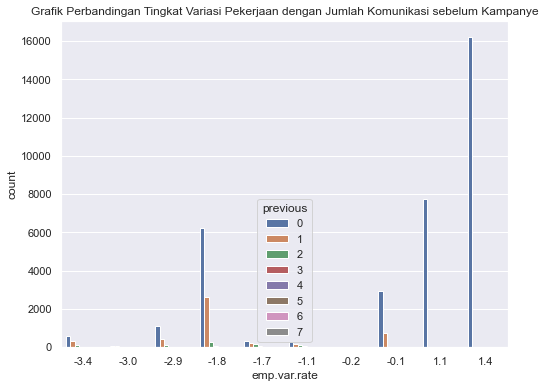

In [538]:
# Visualisasi data Analisis Multivariate antara previous dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'previous')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Jumlah Komunikasi sebelum Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan dominasi kelompok tanpa komunikasi sebelum kampanye

In [283]:
# Analisis Multivariate antara previous dan cons.price.idx
(pd.crosstab(index = df['previous'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
previous                                                                 
0                 1.09    0.39    0.67    0.33    0.39    0.22    0.02   
1                 0.58    0.21    0.31    0.09    0.30    0.14    0.00   
2                 0.17    0.05    0.09    0.01    0.13    0.05    0.00   
3                 0.02    0.00    0.02    0.00    0.05    0.01    0.00   
4                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   
5                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   
6                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   
7                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
previous                                                                 
0                 0.63    9.52    1.27    4.35    7.00    0.26   12.56   
1                 0.05    4.29    0.42    1.48    1.77    0.23    0.00   
2                 0.00    0.25    0.04    0.13    0.00    0.11    0.00   
3                 0.00    0.00    0.00    0.01    0.00    0.03    0.00   
4                 0.00    0.00    0.00    0.00    0.00    0.01    0.00   
5                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   
6                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   
7                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
previous                                                                 
0                 0.20    0.16    0.18   16.23   18.85    0.23    0.25   
1                 0.16    0.00    0.12    0.00    0.00    0.13    0.14   
2                 0.05    0.00    0.11    0.00    0.00    0.09    0.10   
3                 0.01    0.00    0.05    0.00    0.00    0.07    0.04   
4                 0.00    0.00    0.02    0.00    0.00    0.03    0.02   
5                 0.00    0.00    0.01    0.00    0.00    0.01    0.00   
6                 0.00    0.00    0.00    0.00    0.00    0.01    0.00   
7                 0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
previous                                                
0                 0.31    0.30   10.62    0.18    0.12  
1                 0.20    0.24    0.00    0.14    0.07  
2                 0.11    0.17    0.00    0.09    0.05  
3                 0.07    0.04    0.00    0.06    0.03  
4                 0.04    0.00    0.00    0.01    0.02  
5                 0.01    0.00    0.00    0.00    0.01  
6                 0.00    0.00    0.00    0.00    0.00  
7                 0.00    0.00    0.00    0.00    0.00

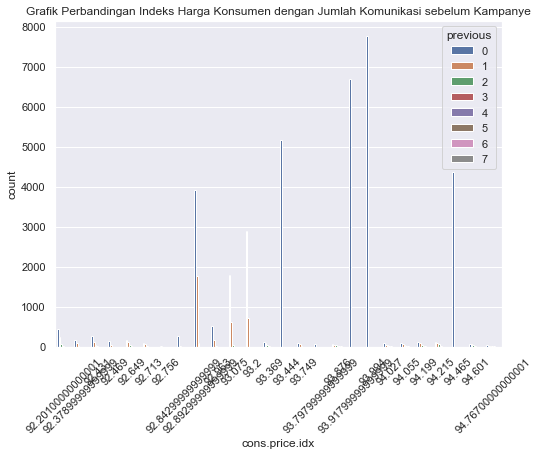

In [540]:
# Visualisasi data Analisis Multivariate antara previous dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'previous')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Jumlah Komunikasi sebelum Kampanye')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok tanpa komunikasi sebelum kampanye

In [284]:
# Analisis Multivariate antara previous dan cons.conf.idx
(pd.crosstab(index = df['previous'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
previous                                                                       
0               0.12   0.63   0.18   4.35   9.52   0.02  16.23   7.00  10.62   
1               0.07   0.05   0.14   1.48   4.29   0.00   0.00   1.77   0.00   
2               0.05   0.00   0.09   0.13   0.25   0.00   0.00   0.00   0.00   
3               0.03   0.00   0.06   0.01   0.00   0.00   0.00   0.00   0.00   
4               0.02   0.00   0.01   0.00   0.00   0.00   0.00   0.00   0.00   
5               0.01   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
6               0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
7               0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
previous                                                                       
0               1.27   0.16   0.30   0.18   0.25   0.23   0.31  18.85  12.56   
1               0.42   0.00   0.24   0.12   0.14   0.13   0.20   0.00   0.00   
2               0.04   0.00   0.17   0.11   0.10   0.09   0.11   0.00   0.00   
3               0.00   0.00   0.04   0.05   0.04   0.07   0.07   0.00   0.00   
4               0.00   0.00   0.00   0.02   0.02   0.03   0.04   0.00   0.00   
5               0.00   0.00   0.00   0.01   0.00   0.01   0.01   0.00   0.00   
6               0.00   0.00   0.00   0.00   0.00   0.01   0.00   0.00   0.00   
7               0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
previous                                                               
0               0.26   0.20   0.33   0.22   1.09   0.39   0.39   0.67  
1               0.23   0.16   0.09   0.14   0.58   0.30   0.21   0.31  
2               0.11   0.05   0.01   0.05   0.17   0.13   0.05   0.09  
3               0.03   0.01   0.00   0.01   0.02   0.05   0.00   0.02  
4               0.01   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
5               0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
6               0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
7               0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

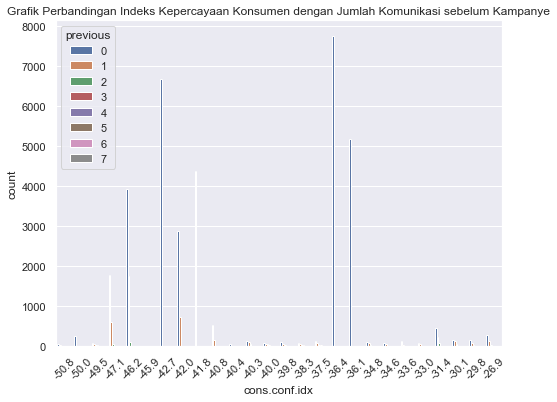

In [542]:
# Visualisasi data Analisis Multivariate antara previous dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'previous')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Jumlah Komunikasi sebelum Kampanye')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok tanpa komunikasi sebelum kampanye

In [285]:
# Analisis Multivariate antara previous dan euribor3m
(pd.crosstab(index = df['previous'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin   0 - 1  1 - 2  3 - 4     >4
previous                            
0          4.69  16.21   0.03  65.41
1          2.86   6.44   0.00   1.77
2          1.30   0.53   0.00   0.00
3          0.46   0.07   0.00   0.00
4          0.14   0.03   0.00   0.00
5          0.03   0.01   0.00   0.00
6          0.01   0.00   0.00   0.00
7          0.00   0.00   0.00   0.00

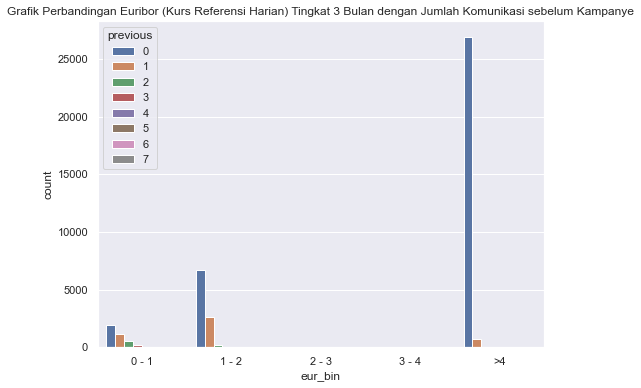

In [543]:
# Visualisasi data Analisis Multivariate antara previous dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'previous')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Jumlah Komunikasi sebelum Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor lebih besar dari 4 dan dominasi kelompok tanpa komunikasi sebelum kampanye

In [286]:
# Analisis Multivariate antara previous dan nr.employed
(pd.crosstab(index = df['previous'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
previous                                                                      
0              0.61    0.79    0.64    1.44    0.22    2.69   14.50    0.02   
1              0.41    0.51    0.51    0.81    0.14    1.09    5.82    0.00   
2              0.25    0.36    0.27    0.27    0.05    0.23    0.39    0.00   
3              0.17    0.15    0.09    0.07    0.01    0.03    0.01    0.00   
4              0.07    0.05    0.04    0.00    0.00    0.01    0.00    0.00   
5              0.02    0.01    0.01    0.00    0.00    0.00    0.00    0.00   
6              0.00    0.01    0.00    0.00    0.00    0.00    0.00    0.00   
7              0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

nr.employed  5191.0  5195.8  5228.1  
previous                             
0             18.85    7.16   39.41  
1              0.00    1.77    0.00  
2              0.00    0.00    0.00  
3              0.00    0.00    0.00  
4              0.00    0.00    0.00  
5              0.00    0.00    0.00  
6              0.00    0.00    0.00  
7              0.00    0.00    0.00

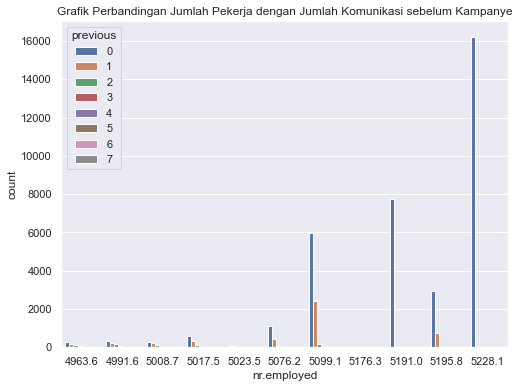

In [544]:
# Visualisasi data Analisis Multivariate antara previous dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'previous')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Jumlah Komunikasi sebelum Kampanye')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanayak 5228 orang dan dominasi kelompok tanpa komunikasi sebelum kampanye

### Analisis Multivariate terhadap Poutcome

In [287]:
# Analisis Multivariate antara poutcome dan emp.var.rate
(pd.crosstab(index = df['poutcome'], columns = df['emp.var.rate'], normalize = 'all')*100).round(2)

emp.var.rate  -3.4  -3.0  -2.9   -1.8  -1.7  -1.1  -0.2  -0.1    1.1    1.4
poutcome                                                                   
failure       0.65  0.09  0.83   6.13  0.49  0.44  0.00  1.69   0.00   0.00
nonexistent   1.44  0.22  2.69  15.15  0.79  0.61  0.02  7.16  18.85  39.41
success       0.51  0.11  0.52   1.02  0.59  0.49  0.00  0.08   0.00   0.00

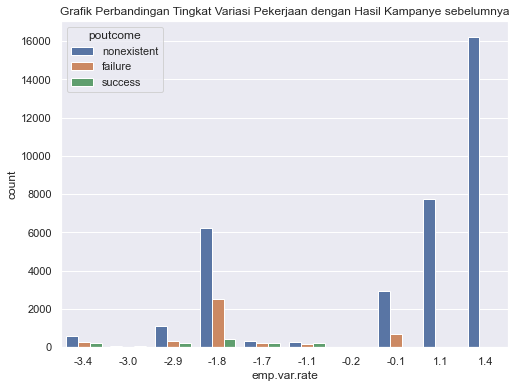

In [546]:
# Visualisasi data Analisis Multivariate antara poutcome dan emp.var.rate
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'poutcome')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Hasil Kampanye sebelumnya')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat variasi pekerjaan sebesar 1.4 dan dominasi kelompok dengan hasil dari kampanye sebelumnya berupa tidak ada

In [288]:
# Analisis Multivariate antara poutcome dan cons.price.idx
(pd.crosstab(index = df['poutcome'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
poutcome                                                                 
failure           0.46    0.13    0.26    0.08    0.25    0.09    0.00   
nonexistent       1.09    0.39    0.67    0.33    0.39    0.22    0.02   
success           0.32    0.13    0.16    0.03    0.22    0.11    0.00   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
poutcome                                                                 
failure           0.05    4.17    0.30    1.46    1.69    0.19    0.00   
nonexistent       0.63    9.52    1.27    4.35    7.00    0.26   12.56   
success           0.01    0.37    0.17    0.16    0.08    0.19    0.00   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
poutcome                                                                 
failure           0.11    0.00    0.15    0.00    0.00    0.16    0.12   
nonexistent       0.20    0.16    0.18   16.23   18.85    0.23    0.25   
success           0.11    0.00    0.18    0.00    0.00    0.17    0.18   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
poutcome                                                
failure           0.20    0.22    0.00    0.15    0.09  
nonexistent       0.31    0.30   10.62    0.18    0.12  
success           0.23    0.24    0.00    0.17    0.09

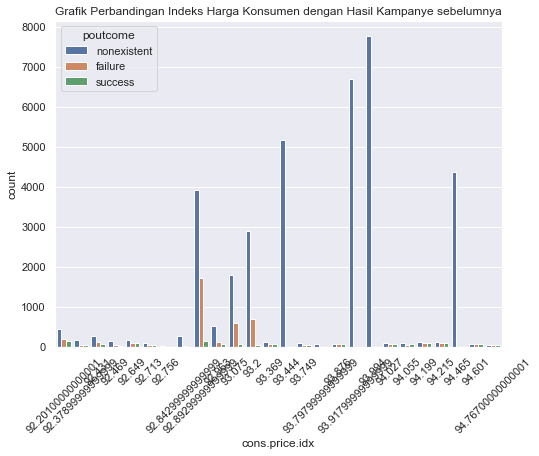

In [549]:
# Visualisasi data Analisis Multivariate antara poutcome dan cons.price.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'poutcome')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Hasil Kampanye sebelumnya')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok dengan hasil kampanye sebelumnya berupa tidak ada

In [289]:
# Analisis Multivariate antara poutcome dan cons.conf.idx
(pd.crosstab(index = df['poutcome'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
poutcome                                                                       
failure         0.09   0.05   0.15   1.46   4.17   0.00   0.00   1.69   0.00   
nonexistent     0.12   0.63   0.18   4.35   9.52   0.02  16.23   7.00  10.62   
success         0.09   0.01   0.17   0.16   0.37   0.00   0.00   0.08   0.00   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
poutcome                                                                       
failure         0.30   0.00   0.22   0.15   0.12   0.16   0.20   0.00   0.00   
nonexistent     1.27   0.16   0.30   0.18   0.25   0.23   0.31  18.85  12.56   
success         0.17   0.00   0.24   0.18   0.18   0.17   0.23   0.00   0.00   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
poutcome                                                               
failure         0.19   0.11   0.08   0.09   0.46   0.25   0.13   0.26  
nonexistent     0.26   0.20   0.33   0.22   1.09   0.39   0.39   0.67  
success         0.19   0.11   0.03   0.11   0.32   0.22   0.13   0.16

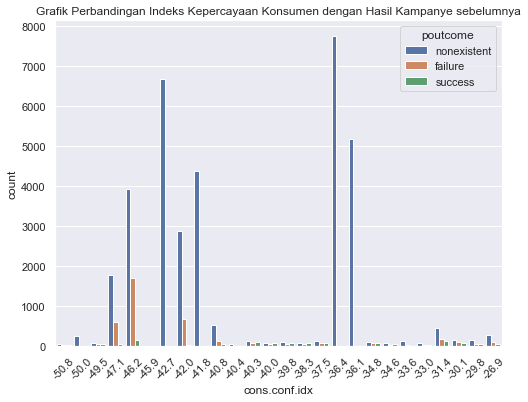

In [551]:
# Visualisasi data Analisis Multivariate antara poutcome dan cons.conf.idx
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'poutcome')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Hasil Kampanye sebelumnya')
plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan tingkat kepercayaan konsumen sebesar -36.4 dan dominasi kelompok dengan hasil kampanye sebelumnya berupa tidak ada

In [290]:
# Analisis Multivariate antara poutcome dan euribor3m
(pd.crosstab(index = df['poutcome'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin      0 - 1  1 - 2  3 - 4     >4
poutcome                               
failure       2.45   6.18   0.00   1.69
nonexistent   4.69  16.21   0.03  65.41
success       2.35   0.90   0.00   0.08

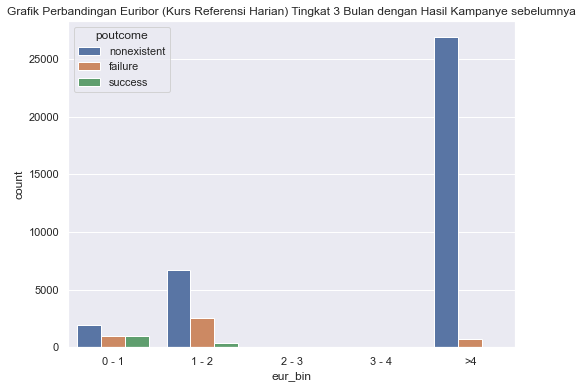

In [552]:
# Visualisasi data Analisis Multivariate antara poutcome dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'poutcome')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Hasil Kampanye sebelumnya')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor lebih besar dari 4 dan kelompok didominasi dengan hasil kampanye sebelumnya berupa tidak ada

In [291]:
# Analisis Multivariate antara poutcome dan nr.employed
(pd.crosstab(index = df['poutcome'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
poutcome                                                                      
failure        0.44    0.49    0.45    0.65    0.09    0.83    5.68    0.00   
nonexistent    0.61    0.79    0.64    1.44    0.22    2.69   14.50    0.02   
success        0.49    0.59    0.49    0.51    0.11    0.52    0.54    0.00   

nr.employed  5191.0  5195.8  5228.1  
poutcome                             
failure        0.00    1.69    0.00  
nonexistent   18.85    7.16   39.41  
success        0.00    0.08    0.00

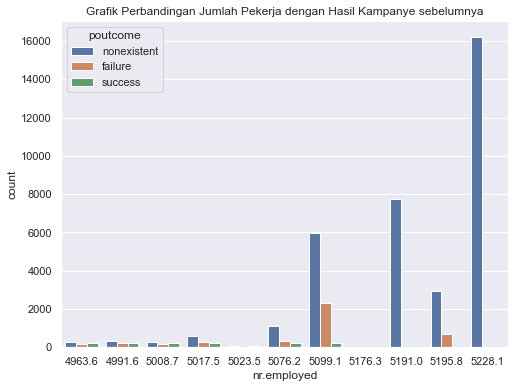

In [553]:
# Visualisasi data Analisis Multivariate antara poutcome dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'poutcome')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Hasil Kampanye sebelumnya')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanyak 5228 orang dan dominasi kelompok oleh hasil kampanye sebelumnya berupa tidak ada

### Analisis Multivariate terhadap Emp.var.rate

In [292]:
# Analisis Multivariate antara emp.var.rate dan cons.price.idx
(pd.crosstab(index = df['emp.var.rate'], columns = df['cons.price.idx'], normalize = 'all')*100).round(2)

cons.price.idx  92.201  92.379  92.431  92.469  92.649  92.713  92.756  \
emp.var.rate                                                             
-3.4              0.00    0.65    1.09    0.00    0.87    0.00    0.00   
-3.0              0.00    0.00    0.00    0.00    0.00    0.42    0.00   
-2.9              1.87    0.00    0.00    0.43    0.00    0.00    0.00   
-1.8              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-1.7              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-1.1              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-0.2              0.00    0.00    0.00    0.00    0.00    0.00    0.02   
-0.1              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
 1.1              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
 1.4              0.00    0.00    0.00    0.00    0.00    0.00    0.00   

cons.price.idx  92.843  92.893  92.963  93.075  93.200  93.369  93.444  \
emp.var.rate                                                             
-3.4              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-3.0              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-2.9              0.00    0.00    1.74    0.00    0.00    0.00    0.00   
-1.8              0.68   14.07    0.00    5.97    0.00    0.64    0.00   
-1.7              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-1.1              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-0.2              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-0.1              0.00    0.00    0.00    0.00    8.78    0.00    0.00   
 1.1              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
 1.4              0.00    0.00    0.00    0.00    0.00    0.00   12.56   

cons.price.idx  93.749  93.798  93.876  93.918  93.994  94.027  94.055  \
emp.var.rate                                                             
-3.4              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-3.0              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-2.9              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-1.8              0.42    0.00    0.51    0.00    0.00    0.00    0.00   
-1.7              0.00    0.00    0.00    0.00    0.00    0.57    0.56   
-1.1              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-0.2              0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-0.1              0.00    0.16    0.00    0.00    0.00    0.00    0.00   
 1.1              0.00    0.00    0.00    0.00   18.85    0.00    0.00   
 1.4              0.00    0.00    0.00   16.23    0.00    0.00    0.00   

cons.price.idx  94.199  94.215  94.465  94.601  94.767  
emp.var.rate                                            
-3.4              0.00    0.00    0.00     0.0    0.00  
-3.0              0.00    0.00    0.00     0.0    0.00  
-2.9              0.00    0.00    0.00     0.0    0.00  
-1.8              0.00    0.00    0.00     0.0    0.00  
-1.7              0.00    0.76    0.00     0.0    0.00  
-1.1              0.74    0.00    0.00     0.5    0.31  
-0.2              0.00    0.00    0.00     0.0    0.00  
-0.1              0.00    0.00    0.00     0.0    0.00  
 1.1              0.00    0.00    0.00     0.0    0.00  
 1.4              0.00    0.00   10.62     0.0    0.00

Insight : Nasabah didominasi kelompok dengan indeks harga konsumen sebesar 93.994 dan dominasi kelompok dengan tingkat variasi pekerja sebesar 1.1

In [293]:
# Analisis Multivariate antara emp.var.rate dan cons.conf.idx
(pd.crosstab(index = df['emp.var.rate'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx  -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
emp.var.rate                                                                   
-3.4            0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
-3.0            0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
-2.9            0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
-1.8            0.00   0.68    0.0   5.97  14.07   0.00   0.00   0.00   0.00   
-1.7            0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
-1.1            0.31   0.00    0.5   0.00   0.00   0.00   0.00   0.00   0.00   
-0.2            0.00   0.00    0.0   0.00   0.00   0.02   0.00   0.00   0.00   
-0.1            0.00   0.00    0.0   0.00   0.00   0.00   0.00   8.78   0.00   
 1.1            0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
 1.4            0.00   0.00    0.0   0.00   0.00   0.00  16.23   0.00  10.62   

cons.conf.idx  -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
emp.var.rate                                                                   
-3.4            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
-3.0            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
-2.9            1.74   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
-1.8            0.00   0.00   0.00   0.51   0.00   0.00   0.00   0.00   0.00   
-1.7            0.00   0.00   0.76   0.00   0.56   0.57   0.00   0.00   0.00   
-1.1            0.00   0.00   0.00   0.00   0.00   0.00   0.74   0.00   0.00   
-0.2            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
-0.1            0.00   0.16   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
 1.1            0.00   0.00   0.00   0.00   0.00   0.00   0.00  18.85   0.00   
 1.4            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  12.56   

cons.conf.idx  -34.8  -34.6  -33.6  -33.0  -31.4  -30.1  -29.8  -26.9  
emp.var.rate                                                           
-3.4            0.00   0.00   0.00   0.00   0.00   0.87   0.65   1.09  
-3.0            0.00   0.00   0.00   0.42   0.00   0.00   0.00   0.00  
-2.9            0.00   0.00   0.43   0.00   1.87   0.00   0.00   0.00  
-1.8            0.64   0.42   0.00   0.00   0.00   0.00   0.00   0.00  
-1.7            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
-1.1            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
-0.2            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
-0.1            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
 1.1            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
 1.4            0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok dengan tingkat variasi pekerja sebesar 1.1

In [294]:
# Analisis Multivariate antara emp.var.rate dan euribor3m
(pd.crosstab(index = df['emp.var.rate'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin       0 - 1  1 - 2  3 - 4     >4
emp.var.rate                            
-3.4           2.60   0.00   0.00   0.00
-3.0           0.42   0.00   0.00   0.00
-2.9           1.96   2.08   0.00   0.00
-1.8           1.58  20.72   0.00   0.00
-1.7           1.88   0.00   0.00   0.00
-1.1           1.06   0.48   0.00   0.00
-0.2           0.00   0.00   0.02   0.00
-0.1           0.00   0.00   0.01   8.93
 1.1           0.00   0.00   0.00  18.85
 1.4           0.00   0.00   0.00  39.41

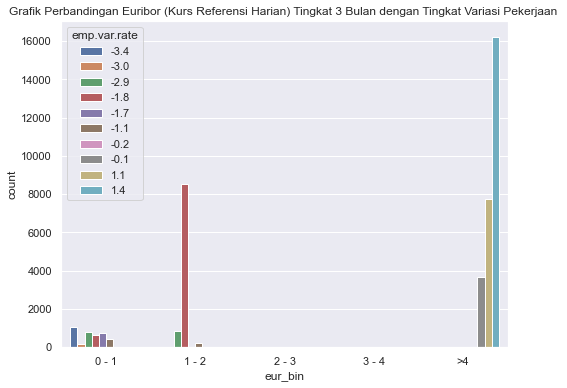

In [554]:
# Visualisasi data Analisis Multivariate antara emp.var.rate dan euribor3m
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'emp.var.rate')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Tingkat Variasi Pekerjaan ')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan nilai euribor lebih besar dari 4 dan kelompok didominasi tingkat variasi pekerjaan sebesar 1.4

In [295]:
# Analisis Multivariate antara emp.var.rate dan nr.employed
(pd.crosstab(index = df['emp.var.rate'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed   4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
emp.var.rate                                                                   
-3.4            0.00    0.00    0.00     2.6    0.00    0.00    0.00    0.00   
-3.0            0.00    0.00    0.00     0.0    0.42    0.00    0.00    0.00   
-2.9            0.00    0.00    0.00     0.0    0.00    4.04    0.00    0.00   
-1.8            0.00    0.00    1.58     0.0    0.00    0.00   20.72    0.00   
-1.7            0.00    1.88    0.00     0.0    0.00    0.00    0.00    0.00   
-1.1            1.54    0.00    0.00     0.0    0.00    0.00    0.00    0.00   
-0.2            0.00    0.00    0.00     0.0    0.00    0.00    0.00    0.02   
-0.1            0.00    0.00    0.00     0.0    0.00    0.00    0.00    0.00   
 1.1            0.00    0.00    0.00     0.0    0.00    0.00    0.00    0.00   
 1.4            0.00    0.00    0.00     0.0    0.00    0.00    0.00    0.00   

nr.employed   5191.0  5195.8  5228.1  
emp.var.rate                          
-3.4            0.00    0.00    0.00  
-3.0            0.00    0.00    0.00  
-2.9            0.00    0.00    0.00  
-1.8            0.00    0.00    0.00  
-1.7            0.00    0.00    0.00  
-1.1            0.00    0.00    0.00  
-0.2            0.00    0.00    0.00  
-0.1            0.00    8.94    0.00  
 1.1           18.85    0.00    0.00  
 1.4            0.00    0.00   39.41

Insight : Nasabah didominasi kelompok dengan jumlah pekerja sebanyak 5228 orang dan dominasi kelompok dengan tingkat variasi pekerjaan sebesar 1.4

### Analisis Multivariate terhadap Cons.price.idx

In [296]:
# Analisis Multivariate antara cons.price.idx dan cons.conf.idx
(pd.crosstab(index = df['cons.price.idx'], columns = df['cons.conf.idx'], normalize = 'all')*100).round(2)

cons.conf.idx   -50.8  -50.0  -49.5  -47.1  -46.2  -45.9  -42.7  -42.0  -41.8  \
cons.price.idx                                                                  
92.201           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
92.379           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
92.431           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
92.469           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
92.649           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
92.713           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
92.756           0.00   0.00    0.0   0.00   0.00   0.02   0.00   0.00   0.00   
92.843           0.00   0.68    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
92.893           0.00   0.00    0.0   0.00  14.07   0.00   0.00   0.00   0.00   
92.963           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
93.075           0.00   0.00    0.0   5.97   0.00   0.00   0.00   0.00   0.00   
93.200           0.00   0.00    0.0   0.00   0.00   0.00   0.00   8.78   0.00   
93.369           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
93.444           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
93.749           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
93.798           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
93.876           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
93.918           0.00   0.00    0.0   0.00   0.00   0.00  16.23   0.00   0.00   
93.994           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
94.027           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
94.055           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
94.199           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
94.215           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   
94.465           0.00   0.00    0.0   0.00   0.00   0.00   0.00   0.00  10.62   
94.601           0.00   0.00    0.5   0.00   0.00   0.00   0.00   0.00   0.00   
94.767           0.31   0.00    0.0   0.00   0.00   0.00   0.00   0.00   0.00   

cons.conf.idx   -40.8  -40.4  -40.3  -40.0  -39.8  -38.3  -37.5  -36.4  -36.1  \
cons.price.idx                                                                  
92.201           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.379           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.431           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.469           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.649           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.713           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.756           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.843           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.893           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
92.963           1.74   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
93.075           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
93.200           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
93.369           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
93.444           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  12.56   
93.749           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
93.798           0.00   0.16   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
93.876           0.00   0.00   0.00   0.51   0.00   0.00   0.00   0.00   0.00   
93.918           0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
93.994           0.00   0.00   0.00   0.00   0.00   0.00   0.00  18.85   0.00   
94.027           0.00   0.00  

Insight : Nasabah didominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4 dan dominasi kelompok dengan indeks harga konsumen sebesar 93.994

In [297]:
# Analisis Multivariate antara cons.price.idx dan euribor3m
(pd.crosstab(index = df['cons.price.idx'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin         0 - 1  1 - 2  3 - 4     >4
cons.price.idx                            
92.201           1.87   0.00   0.00   0.00
92.379           0.65   0.00   0.00   0.00
92.431           1.09   0.00   0.00   0.00
92.469           0.09   0.34   0.00   0.00
92.649           0.87   0.00   0.00   0.00
92.713           0.42   0.00   0.00   0.00
92.756           0.00   0.00   0.02   0.00
92.843           0.00   0.68   0.00   0.00
92.893           0.00  14.07   0.00   0.00
92.963           0.00   1.74   0.00   0.00
93.075           0.00   5.97   0.00   0.00
93.200           0.00   0.00   0.01   8.77
93.369           0.64   0.00   0.00   0.00
93.444           0.00   0.00   0.00  12.56
93.749           0.42   0.00   0.00   0.00
93.798           0.00   0.00   0.00   0.16
93.876           0.51   0.00   0.00   0.00
93.918           0.00   0.00   0.00  16.23
93.994           0.00   0.00   0.00  18.85
94.027           0.57   0.00   0.00   0.00
94.055           0.56   0.00   0.00   0.00
94.199           0.74   0.00   0.00   0.00
94.215           0.76   0.00   0.00   0.00
94.465           0.00   0.00   0.00  10.62
94.601           0.32   0.17   0.00   0.00
94.767           0.00   0.31   0.00   0.00

Insight : Nasabah didominasi kelompok dengan nilai euribor lebih besar dari 4 dan dominasi kelompok dengan indeks harga konsumen sebesar 93.994

In [298]:
# Analisis Multivariate antara cons.price.idx dan nr.employed
(pd.crosstab(index = df['cons.price.idx'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed     4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  \
cons.price.idx                                                           
92.201            0.00    0.00    0.00    0.00    0.00    1.87    0.00   
92.379            0.00    0.00    0.00    0.65    0.00    0.00    0.00   
92.431            0.00    0.00    0.00    1.09    0.00    0.00    0.00   
92.469            0.00    0.00    0.00    0.00    0.00    0.43    0.00   
92.649            0.00    0.00    0.00    0.87    0.00    0.00    0.00   
92.713            0.00    0.00    0.00    0.00    0.42    0.00    0.00   
92.756            0.00    0.00    0.00    0.00    0.00    0.00    0.00   
92.843            0.00    0.00    0.00    0.00    0.00    0.00    0.68   
92.893            0.00    0.00    0.00    0.00    0.00    0.00   14.07   
92.963            0.00    0.00    0.00    0.00    0.00    1.74    0.00   
93.075            0.00    0.00    0.00    0.00    0.00    0.00    5.97   
93.200            0.00    0.00    0.00    0.00    0.00    0.00    0.00   
93.369            0.00    0.00    0.64    0.00    0.00    0.00    0.00   
93.444            0.00    0.00    0.00    0.00    0.00    0.00    0.00   
93.749            0.00    0.00    0.42    0.00    0.00    0.00    0.00   
93.798            0.00    0.00    0.00    0.00    0.00    0.00    0.00   
93.876            0.00    0.00    0.51    0.00    0.00    0.00    0.00   
93.918            0.00    0.00    0.00    0.00    0.00    0.00    0.00   
93.994            0.00    0.00    0.00    0.00    0.00    0.00    0.00   
94.027            0.00    0.57    0.00    0.00    0.00    0.00    0.00   
94.055            0.00    0.56    0.00    0.00    0.00    0.00    0.00   
94.199            0.74    0.00    0.00    0.00    0.00    0.00    0.00   
94.215            0.00    0.76    0.00    0.00    0.00    0.00    0.00   
94.465            0.00    0.00    0.00    0.00    0.00    0.00    0.00   
94.601            0.50    0.00    0.00    0.00    0.00    0.00    0.00   
94.767            0.31    0.00    0.00    0.00    0.00    0.00    0.00   

nr.employed     5176.3  5191.0  5195.8  5228.1  
cons.price.idx                                  
92.201            0.00    0.00    0.00    0.00  
92.379            0.00    0.00    0.00    0.00  
92.431            0.00    0.00    0.00    0.00  
92.469            0.00    0.00    0.00    0.00  
92.649            0.00    0.00    0.00    0.00  
92.713            0.00    0.00    0.00    0.00  
92.756            0.02    0.00    0.00    0.00  
92.843            0.00    0.00    0.00    0.00  
92.893            0.00    0.00    0.00    0.00  
92.963            0.00    0.00    0.00    0.00  
93.075            0.00    0.00    0.00    0.00  
93.200            0.00    0.00    8.78    0.00  
93.369            0.00    0.00    0.00    0.00  
93.444            0.00    0.00    0.00   12.56  
93.749            0.00    0.00    0.00    0.00  
93.798            0.00    0.00    0.16    0.00  
93.876            0.00    0.00    0.00    0.00  
93.918            0.00    0.00    0.00   16.23  
93.994            0.00   18.85    0.00    0.00  
94.027            0.00    0.00    0.00    0.00  
94.055            0.00    0.00    0.00    0.00  
94.199            0.00    0.00    0.00    0.00  
94.215            0.00    0.00    0.00    0.00  
94.465            0.00    0.00    0.00   10.62  
94.601            0.00    0.00    0.00    0.00  
94.767            0.00    0.00    0.00    0.00

Insight : Nasbaah didominasi kelompok dengan jumlah pekerja sebanyak 5228 pekerja dan dominasi kelompok dengan indeks harga konsumen sebesar 93.918

### Analisis Multivariate terhadap Cons.conf.idx

In [299]:
# Analisis Multivariate antara cons.conf.idx dan euribor3m
(pd.crosstab(index = df['cons.conf.idx'], columns = df['eur_bin'], normalize = 'all')*100).round(2)

eur_bin        0 - 1  1 - 2  3 - 4     >4
cons.conf.idx                            
-50.8           0.00   0.31   0.00   0.00
-50.0           0.00   0.68   0.00   0.00
-49.5           0.32   0.17   0.00   0.00
-47.1           0.00   5.97   0.00   0.00
-46.2           0.00  14.07   0.00   0.00
-45.9           0.00   0.00   0.02   0.00
-42.7           0.00   0.00   0.00  16.23
-42.0           0.00   0.00   0.01   8.77
-41.8           0.00   0.00   0.00  10.62
-40.8           0.00   1.74   0.00   0.00
-40.4           0.00   0.00   0.00   0.16
-40.3           0.76   0.00   0.00   0.00
-40.0           0.51   0.00   0.00   0.00
-39.8           0.56   0.00   0.00   0.00
-38.3           0.57   0.00   0.00   0.00
-37.5           0.74   0.00   0.00   0.00
-36.4           0.00   0.00   0.00  18.85
-36.1           0.00   0.00   0.00  12.56
-34.8           0.64   0.00   0.00   0.00
-34.6           0.42   0.00   0.00   0.00
-33.6           0.09   0.34   0.00   0.00
-33.0           0.42   0.00   0.00   0.00
-31.4           1.87   0.00   0.00   0.00
-30.1           0.87   0.00   0.00   0.00
-29.8           0.65   0.00   0.00   0.00
-26.9           1.09   0.00   0.00   0.00

Insight : Nasabah didominasi kelompok dengan nilai euribor lebih besar dari 4 dan dominasi kelompok dengan indeks kepercayaan konsumen sebesar -36.4

In [300]:
# Analisis Multivariate antara cons.conf.idx dan nr.employed
(pd.crosstab(index = df['cons.conf.idx'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed    4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
cons.conf.idx                                                                   
-50.8            0.31    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-50.0            0.00    0.00    0.00    0.00    0.00    0.00    0.68    0.00   
-49.5            0.50    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-47.1            0.00    0.00    0.00    0.00    0.00    0.00    5.97    0.00   
-46.2            0.00    0.00    0.00    0.00    0.00    0.00   14.07    0.00   
-45.9            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.02   
-42.7            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-42.0            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-41.8            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-40.8            0.00    0.00    0.00    0.00    0.00    1.74    0.00    0.00   
-40.4            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-40.3            0.00    0.76    0.00    0.00    0.00    0.00    0.00    0.00   
-40.0            0.00    0.00    0.51    0.00    0.00    0.00    0.00    0.00   
-39.8            0.00    0.56    0.00    0.00    0.00    0.00    0.00    0.00   
-38.3            0.00    0.57    0.00    0.00    0.00    0.00    0.00    0.00   
-37.5            0.74    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-36.4            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-36.1            0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
-34.8            0.00    0.00    0.64    0.00    0.00    0.00    0.00    0.00   
-34.6            0.00    0.00    0.42    0.00    0.00    0.00    0.00    0.00   
-33.6            0.00    0.00    0.00    0.00    0.00    0.43    0.00    0.00   
-33.0            0.00    0.00    0.00    0.00    0.42    0.00    0.00    0.00   
-31.4            0.00    0.00    0.00    0.00    0.00    1.87    0.00    0.00   
-30.1            0.00    0.00    0.00    0.87    0.00    0.00    0.00    0.00   
-29.8            0.00    0.00    0.00    0.65    0.00    0.00    0.00    0.00   
-26.9            0.00    0.00    0.00    1.09    0.00    0.00    0.00    0.00   

nr.employed    5191.0  5195.8  5228.1  
cons.conf.idx                          
-50.8            0.00    0.00    0.00  
-50.0            0.00    0.00    0.00  
-49.5            0.00    0.00    0.00  
-47.1            0.00    0.00    0.00  
-46.2            0.00    0.00    0.00  
-45.9            0.00    0.00    0.00  
-42.7            0.00    0.00   16.23  
-42.0            0.00    8.78    0.00  
-41.8            0.00    0.00   10.62  
-40.8            0.00    0.00    0.00  
-40.4            0.00    0.16    0.00  
-40.3            0.00    0.00    0.00  
-40.0            0.00    0.00    0.00  
-39.8            0.00    0.00    0.00  
-38.3            0.00    0.00    0.00  
-37.5            0.00    0.00    0.00  
-36.4           18.85    0.00    0.00  
-36.1            0.00    0.00   12.56  
-34.8            0.00    0.00    0.00  
-34.6            0.00    0.00    0.00  
-33.6            0.00    0.00    0.00  
-33.0            0.00    0.00    0.00  
-31.4            0.00    0.00    0.00  
-30.1            0.00    0.00    0.00  
-29.8            0.00    0.00    0.00  
-26.9            0.00    0.00    0.00

Insight : Nasabah didominasi kelompok dengan jumlah karyawan sebanyak 5228 orang dan dominasi kelompok dengan indeks kepercayaan konsumen sebesar -42.7

### Analisis Multivariate terhadap Euribor3m

In [301]:
# Analisis Multivariate antara euribor3m dan nr.employed
(pd.crosstab(index = df['eur_bin'], columns = df['nr.employed'], normalize = 'all')*100).round(2)

nr.employed  4963.6  4991.6  5008.7  5017.5  5023.5  5076.2  5099.1  5176.3  \
eur_bin                                                                       
0 - 1          1.06    1.88    1.58     2.6    0.42    1.96    0.00    0.00   
1 - 2          0.48    0.00    0.00     0.0    0.00    2.08   20.72    0.00   
3 - 4          0.00    0.00    0.00     0.0    0.00    0.00    0.00    0.02   
>4             0.00    0.00    0.00     0.0    0.00    0.00    0.00    0.00   

nr.employed  5191.0  5195.8  5228.1  
eur_bin                              
0 - 1          0.00    0.00    0.00  
1 - 2          0.00    0.00    0.00  
3 - 4          0.00    0.01    0.00  
>4            18.85    8.93   39.41

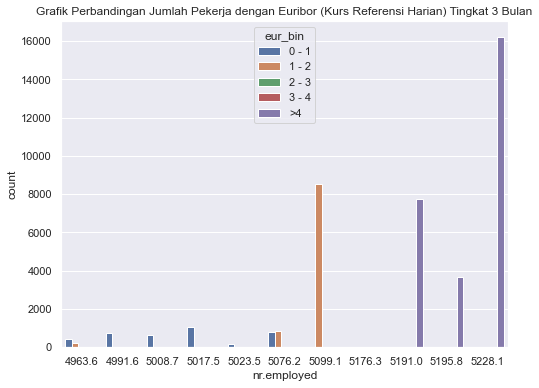

In [555]:
# Visualisasi data Analisis Multivariate antara euribor3m dan nr.employed
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'eur_bin')
plt.title('Grafik Perbandingan Jumlah Pekerja dengan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan')
# plt.xticks(rotation=45)
plt.show()

Insight : Nasabah didominasi kelompok dengan jumlahpekerja sebanyak 5228 orang dan dominasi kelompok dengan nilai euribor lebih besar dari 4